Populating the interactive namespace from numpy and matplotlib


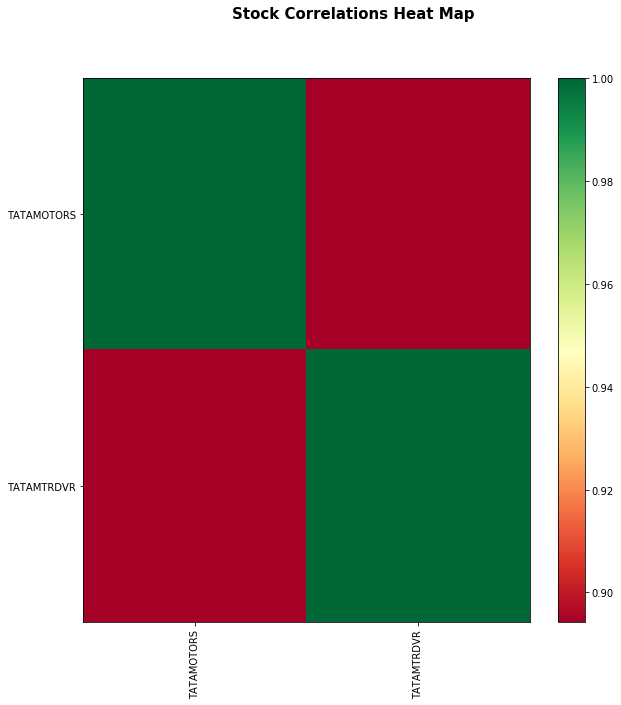

In [18]:

from nsepy import get_history
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt

#Prepare the Watchlist
sym=["TATAMOTORS","TATAMTRDVR"]

#Fetch Historical Data using NSepy
data= pd.DataFrame()
j=0
for i in sym:
    result = get_history(symbol=i, start=date(2010,1,1), end=date(2019,6,1))
    if result.empty:
        pass
    else: 
        s2=result[['Close']]
        s2=s2.rename(columns = {'Close':i})
        if j==0:
            data=data.append(s2)
            j=j+1
        else:
            data=data.join(s2)
            

            
#Compute Percentage Change
rets = data.pct_change()

#Compute Correlation
corr = rets.corr()

#Plot Correlation Matrix using Matplotlib
%pylab inline
plt.figure(figsize=(10, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
plt.suptitle('Stock Correlations Heat Map', fontsize=15, fontweight='bold')
plt.show()

In [19]:
print(data.head(3))

            TATAMOTORS  TATAMTRDVR
Date                              
2010-01-04      826.45      505.30
2010-01-05      812.05      504.15
2010-01-06      813.30      511.35


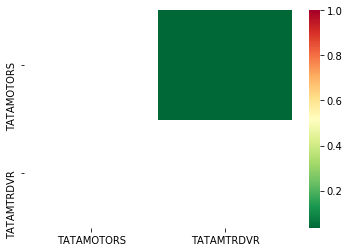

[]


In [20]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.02:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


scores, pvalues, pairs = find_cointegrated_pairs(data)

import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=sym, 
                yticklabels=sym, cmap='RdYlGn_r', 
                mask = (pvalues >= 0.98))
plt.show()
print(pairs)

0.034819342484260406


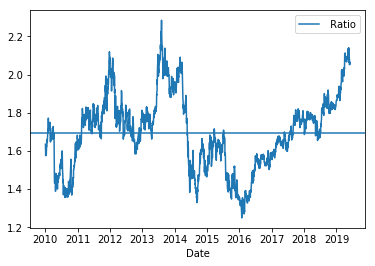

In [21]:
S1 = data['TATAMOTORS']
S2 = data['TATAMTRDVR']
score, pvalue, _ = coint(S1, S2)
print(pvalue)
ratios = S1 / S2
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

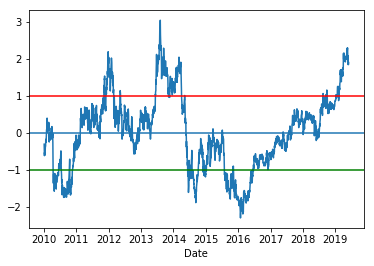

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [23]:
ratios = data['TATAMOTORS'] / data['TATAMTRDVR']
print(len(ratios))
train = ratios[:1762]
test = ratios[1762:]

2345


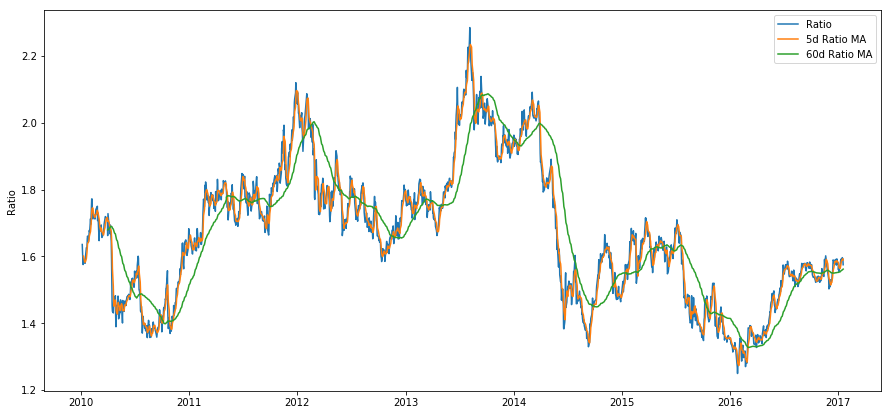

In [24]:
ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()
ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()
std_60 = train.rolling(window=60,
                        center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.show()

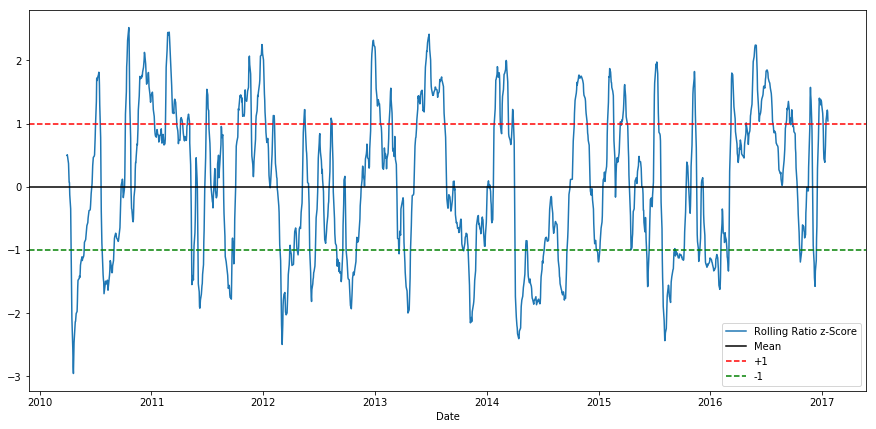

In [26]:
plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

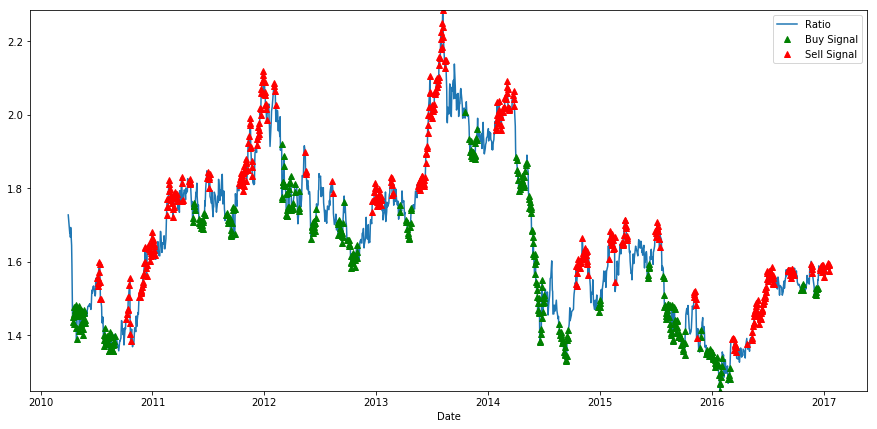

In [29]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

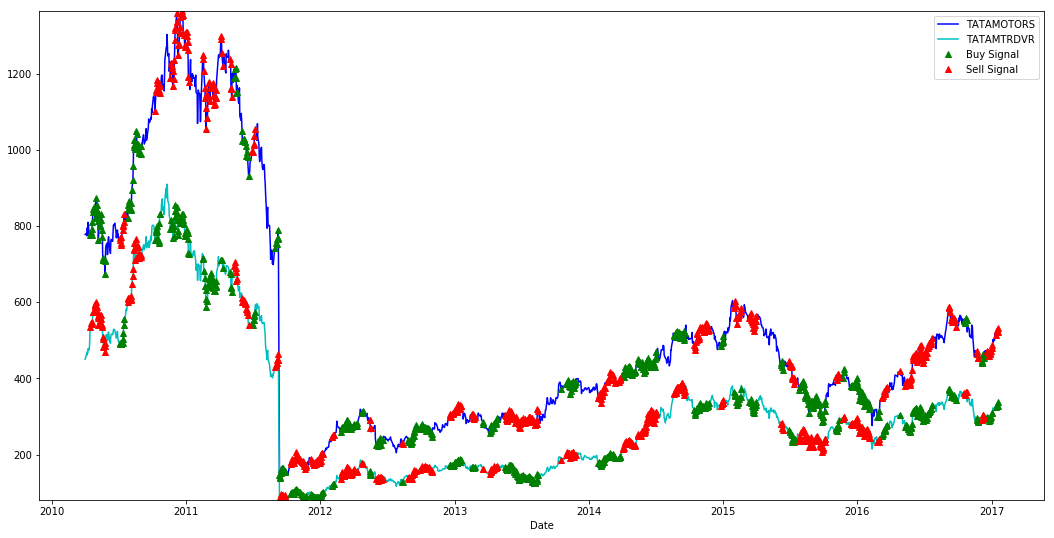

In [31]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))
S1 = data['TATAMOTORS'].iloc[:1762]
S2 = data['TATAMTRDVR'].iloc[:1762]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABB4AAAIaCAYAAACH544fAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvIxREBQAAIABJREFUeJzs3Xl4lPW9///nPZOVgCCIhF1ARFkTRCuIhnOsVmsPCtoKahGsimIXPd/LHmjlSB36wyLnVNvSqi0MKhhQrK2C2iI9gJG4AAlhUUSUJXKzyJpAwiQz9++Pe9bMZF9mAq/HdeWamXvuueczpnp1Xnl/3m/DsixERERERERERJqDI94LEBEREREREZGzl4IHEREREREREWk2Ch5EREREREREpNkoeBARERERERGRZqPgQURERERERESajYIHEREREREREWk2Ch5EREREREREpNkoeBARERERERGRZqPgQURERERERESajYIHEREREREREWk2SfFeQE0uuOAC66KLLor3MiSR7d0Lhw9D587Qqxfs3Yt1+BsMLCwMjM4X2MdFRERERESkSW3cuPEby7I613aeYVlWS6ynQUaMGGFt2LAh3suQRGWaeC/qi9NTDunpkJ8PV10F5eWhc9LS4KuvIDMzfusUERERERE5CxmGsdGyrBG1naetFtJq7Z/mosLjsx94vXDXXeDzRZ7k8YDL1fKLExERERERESDBt1qIVMs0uXClmyQ89mOPB7Zvh6oVPD4frF3b8usTERERERERQBUP0lq5XBhWleoGw8ACIqKH5GTIyWnBhYmIiIiIiEg4VTxI65Sfj7PSE3nM58OgSvBQUQFuN8ycqT4PIiIiIiIJqqKiguLiYsrD+7VJwkhLS6NHjx4kJyc36PUKHqR1KijgmWfg0Udh6lR4zjGNyuf+TJJViVH13MpKu8/D/PnxWKmIiIiIiNSiuLiYdu3acdFFF2EYUf+PXuLIsiyOHDlCcXExffr0adA1tNVCWq1jx+zbjmdMcLtJsipjn1hRAevXt9zCRERERESkXsrLy+nUqZNChwRkGAadOnVqVDWKggdptY4dg6EU8qsXL7KnWlQnLQ0KClpqWSIiIiIi0gAKHRJXY383Ch6k1Tp6FBZzN0mWx65qqGLXeVn2lIuysjisTkREREREWosjR46QlZVFVlYWmZmZdO/ePfjY4/HwxhtvYBgGn332GQBbtmwJPt+xY0f69OlDVlYW3/72t4PX/O1vf0taWhonTpwIHluzZg2GYbBgwYLgsYKCAgzDYN68eYC9tWH27Nn079+fSy65hH/7t39j27ZtAHzrW98iKyuLXr160blz5+Aadu/ezYkTJ5g0aRL9+vWjX79+TJo0Kfjeu3fvJj09naysLAYOHMikSZOo8H+HOn36NHfddRdDhgxh8ODBjB49mtLS0ib956vgQVqtDrsLGcy2YEPJGd/dzMX9LLAsrvqWxbSrVOUgIiIiIiK169SpE4WFhRQWFvLggw/y6KOPBh+npKSQm5vL6NGjWbp0KQBDhgwJPj927FiefvppCgsLee+994LXzM3N5YorruCNN96IeK8hQ4awbNmy4OOlS5cybNiw4OP58+ezfv16Nm/ezOeff86MGTMYO3Ys5eXlfPTRRxQWFvLkk09yxx13BNdw0UUX8aMf/Yi+ffuya9cudu3aRZ8+fbjvvvuC1+3Xrx+FhYVs2bKF4uJiXn31VQCeffZZunTpwpYtW9i6dSsLFixocBPJ6ih4kFbrPzfdHfH4wffvpE0b+35ycswiCBERERERkXopLS3lgw8+YMGCBcHgoTa7du2itLSU2bNnk5ubG/Fcr169KC8v5+DBg1iWxbvvvstNN90UfP43v/kNv//972nj/3Jzww03MGrUKJYsWVLt+33xxRds3LiRmTNnBo/993//Nxs2bGDXrl0R5zqdTq688kq+/vprAEzTpHv37sHnBwwYQGpqap0+Z11pqoW0ToWF9CnbFpxgYQC9SrYxlCJgqIIHEREREZFW6pFHoLCwaa+ZlQXPPNOw1/7tb3/jxhtv5JJLLqFjx45s2rSJ4cOH1/ia3NxcJk6cyDXXXMOOHTs4dOgQF154YfD522+/nddee43s7GyGDx8e/KJ/8uRJTp06Rb9+/SKuN2LEiOB2i1i2b99OVlYWTqczeMzpdJKVlcW2bdsYOnRo8HigcuLZZ58F4N577+WGG25g+fLlXHfdddxzzz3079+/7v+A6kAVD9I63X13zMN/3jYSDhwgJQU8nhZek4iIiIiInHVyc3OZMGECABMmTIiqYIhl6dKlTJgwAYfDwfjx43nttdcinv/BD37Aa6+9FgwoamNZVo0NHqt7Pvz4rl27yMrKolOnTvTq1SsYRmRlZfHll1/y2GOPcfToUa644go+/fTTWtdUH6p4kFbJ+uILqv5rZQBpvtPgcpGcPF8VDyIiIiIirVBDKxOaw5EjR/jXv/7F1q1bMQwDr9eLYRjMnTu32iCgqKiInTt3cv311wPg8Xjo27cvDz/8cPCczMxMkpOTWbVqFc8++yzr168H4LzzziMjI4Mvv/ySvn37Bs/ftGkTOTk51a5z0KBBFBQU4PP5cDjs+gKfz8fmzZu57LLLgFCPB9M0GTNmDG+++SZjx44FoG3btowfP57x48fjcDh4++23g69rCqp4kFap8of34sXBsk7TMLDYuXY/5UaaHUa43XT2HlDwICIiIiIijbJ8+XImTZrEnj172L17N/v27aNPnz7k5eVV+5rc3FxmzZrF7t272b17N/v37+frr79mz549Eec9+eST/OY3v4nYHgHw2GOP8dOf/pQy/3S+9957j7y8PO68885q3/Piiy8mOzub2bNnB4/Nnj2b4cOHc/HFF0ec27VrV5566inmzJkDwAcffMCxY8cAOyTZvn07vXv3rsM/nbpT8CCtj2niW7AQJz5uPbqQLhyg43wXhuWzn/d6ueNzl7ZaiIiIiIhIo+Tm5jJu3LiIY7fddhuvvPJKta9ZunRp1GvGjRsX1Zhy1KhR3HrrrVGv/8lPfsIVV1zBkCFDGDBgAC6Xi7///e+kp6fXuNYFCxbw+eefc/HFF9OvXz8+//zziLGd4W699VZOnz7N+++/z65du8jJyWHIkCFkZ2czYsQIbrvtthrfq74My7Ka9IJNacSIEdaGDRvivQxJNNOmUfmn50nChxcHL/FD7kldhuNMefCUM850run2JR/vzYzjQkVEREREpC4+/fTTJi3tl6YX63dkGMZGy7JG1PZaVTxI62KasHAhSdjVDU583M1i8PoiTnNYXh4+6gq95qqrYKTdeFJERERERERajoIHaV1crqg5mUl4cVRG7qtI9nm47dSLdtDgcsFHH8GHH9r3RUREREREpMUoeJDWZd068EVWNxjAse6D+CMPYRkOmDaN9wc/RDplMH06lX9eGDp54UJVPYiIiIiIiLQgBQ/Sulx7LaSkRBwqJ4X93UYwBbfdYHLhQq761I0TH9aLL+KsPBM62eNR1YOIiIiIiEgLUvAgCenQIfj66xhP5OdTdVxFGh4u2roCw9/3AY8Hpy90TsR0XZ8vvlUPpgk5Oaq6EBERERGRc4aCB0lIXbpAjx4xnigoAMvi6lEW13/bIn+9RVf2k+I5RRr+sMHnw+EfrWnEuERcqx5cLsjLU9WFiIiIiIicMxQ8SKvk8UByMiQlwUxcYPlqf1GAzwfr1zff4qpjmlT+2W2/v9utqgcRERERkQRx5MgRsrKyyMrKIjMzk+7duwcfezwe3njjDQzD4LPPPgNgy5Ytwec7duxInz59yMrK4tvf/nbwmr/97W9JS0vjxIkTwWNr1qzBMAwWLFgQPFZQUIBhGMybN4+HH36YrKwsBg4cSHp6evA9li9fzuTJk4PvM2zYMFavXh28xpgxYxgwYABDhw7l0ksv5cc//jHHjx8PPvePf/wj4vM+88wzTJs2jd27dwffZ+DAgUyaNImKKs38m4KCB2mVKirsVg9JSTCSfJJ9ntpfBFjJKTBtml050dJcLiorvfb9ykpVPYiIiIiIJIhOnTpRWFhIYWEhDz74II8++mjwcUpKCrm5uYwePZqlS5cCMGTIkODzY8eO5emnn6awsJD33nsveM3c3FyuuOIK3njjjYj3GjJkCMuWLQs+Xrp0KcOGDQNg/vz5FBYW8vbbb9OvX7/ge9x+++0Awfd55plnePDBByOuu2TJEoqKiigqKiI1NZVbbrkFgIkTJwbXHf6eEydOBAi+z5YtWyguLubVV19tin+kERQ8SKt03imTX3+QQ9rxAwyngFtvsTCw+GKnBQ89BI7Y/9M2KjzxqTYwTXC7ScOfHlZUqOpBRERERKQVKC0t5YMPPmDBggVRX+Crs2vXLkpLS5k9eza5ubkRz/Xq1Yvy8nIOHjyIZVm8++673HTTTfVa08iRI/k6ZlM8SElJYe7cuezdu5fNmzdz++23s2LFCs6csZvu7969m/379zN69OiI1zmdTq688spqr9sYSU1+RZEWMPWQi8tO5nH8BRcwn9JS+3h6OnYDSl8NWy+8XrvaYP78lliqzeWy3zdcoOqhJdchIiIiIpLgHtm5k8LA/8FvIllt2/JM//4Neu3f/vY3brzxRi655BI6duzIpk2bGD58eI2vyc3NZeLEiVxzzTXs2LGDQ4cOceGFFwafv/3223nttdfIzs5m+PDhpKam1mtN7777Lrfeemu1zzudToYNG8Znn33GsGHDuPLKK3n33Xe55ZZbWLp0KXfccQeGEdkRr7y8nI8++ohnn322XmupC1U8SOtjmtx20o0DHx3ecNOFA5SU2E+lpxNsQPnm3y0KyIp+vcfT8j0e8vPtKodwFRXx6TUhIiIiIiJ1lpuby4QJEwCYMGFCVAVDLEuXLmXChAk4HA7Gjx/Pa6+9FvH8D37wA1577bVgQFFXjz32GH379uXuu+/mF7/4RY3nWpYVvB++3SJ8mwXY1RlZWVl06tSJXr16MXTo0Dqvp65U8SAJzbLAqDqawuUKjc70eZmJiz+W2lUDaWmh09LSYDh2L4f166Fg1DQeMp7HeOjBlq8yePtt6NsXystDx9LT4Z13WnYdIiIiIiIJrqGVCc3hyJEj/Otf/2Lr1q0YhoHX68UwDObOnRtVMRBQVFTEzp07uf766wHweDz07duXhx9+OHhOZmYmycnJrFq1imeffZb1dfyD5NNPP8348eP53e9+xz333MPGjRtjnuf1etmyZQuXXXYZALfeeiv/+Z//yaZNmygrK4uo2Aj0eDBNkzFjxvDmm28yduzYOq2nrlTxIAkt/Hs6EOyVkOofnemo8DAFNz2ObGYNds+HgPBqpQsqTKbgxrDiNFHC5Yre/hHY8iEiIiIiIglp+fLlTJo0iT179rB792727dtHnz59yMvLq/Y1ubm5zJo1i927dwf7KXz99dfs2bMn4rwnn3yS3/zmNzidznqtyeFw8LOf/Qyfzxc1rQKgoqKCGTNm0LNnz2D1Qtu2bRkzZgz33ntvtRUWXbt25amnnmLOnDn1Wk+d1tzkVxRpQmVlVQ7E+ALvoJK/HhzFaN7H8evQF/m0NMjEZA05dP39jFCVRDy+8Ofn21s8wsVjy4eIiIiIiNRZbm4u48aNizh222238corr1T7mqVLl0a9Zty4cVGNKUeNGlVjn4aaGIbB448/zty5c4PH7rrrLoYOHcrgwYM5deoUf//73yNeM3HiRDZv3hzcNhLLrbfeyunTp3n//fcbtK5q1xu+7yPRjBgxwtqwYUO8lyFxEKhaKi6G7t3DnsjOhsLCqPMtwAB7+8KXX0JmJps3wwdZ05jKczicDozw5o5h57WUM2dCW0FWrICbb26xtxYRERERSWiffvppcFuAJKZYvyPDMDZaljWitteq4kESTng+ELXVwt84Mslp8fgvLY5v308lTozwF/urGdqcMJnCQpxY0RMl4lD1cOpU6L5/ko2IiIiIiMhZT8GDJJzwL+VRWy2wMwOvF1JSoI1rOk7CQgWPJ9jDocufXSRjT5KIavsSh20OCh5ERERERORcpOBBEs7nn4fuxwoeAlMpO5SZJL+6JDpU8Hph+nTavbaQJEL9IMpI4xdTTHtUhmXZ1RMtKDx4qNruQURERERE5Gyl4EESTngPlJqCh2vXuiL7NgR4PHYThcCJfimc4bGlw1t+ooWfKh5ERERERORcpOBBEs7evaH7UT0eCFULdNubH/sCWVmQmYlRZfqFE4sOZWbcRliq4kFERERERM5FCh4k4ezZY/dvgJorHv76uN1o0sD++fMLYVsorr02dBG/4OQLfw+IllZbxcOxYzBnTtS0UBERERERkVZNwYMknL17YcAA+36s4CFQLZCcHHm8a9ewB/n5UWUFsSZftKRA8JCJyff/kBMVfjz2GPziF/D22y2+NBERERGRc57T6SQrK4thw4YxfPhw1jdRM/oVK1aQnZ3NsGHDGDhwIM8//zwAzz33HC+99FKTvEe4MWPGsGHDhia/bmMoeJCE4vPVHjwEKh6qFDREBg/+sZtYFuzfD2lpoefCJl+0pEDwMBMXPfbkRYUfgedPnGjRZYmIiIiItEpmiUnOohwOlDbN/69PT0+nsLCQzZs3M2fOHGbMmNHoa1ZUVPDAAw/w1ltvsXnzZgoKChgzZgwADz74IJMmTWr0e7QGCh4koRw+bG9DCAQPx45Fbz2oWvGQickacujurOY/OC5X9EXqW/VgmpATXaVQH6Wl9lqn4MZh+aLCj0A2EquvhYiIiIiIRHKtc5G3Nw/X2qavZj558iTnn38+AGvWrOF73/te8Lkf//jHLFq0iNWrVzNu3Ljg8VWrVjF+/PiI65SUlFBZWUmnTp0ASE1NZYD/y86sWbOYN28eAJ988glDhw5l5MiRPPbYYwwePBiARYsWMX78eG688Ub69+/Pz3/+8+C1H3roIUaMGMGgQYN44oknmvyfQVNS8CAJZc8e+/bSS+3b//f/4IEHIs+pWvEwExejyePC56v5D06MbRd4PFCf0imXC/KiqxTqo6gIXCkujMCIT3/48eyz0LMnpKbah0tLG/wWIiIiIiLnBLPExF3oxmf5cBe6m6TqoaysjKysLC699FLuu+8+Zs6cWeP5//7v/86nn37K4cOHAXC73UyZMiXinI4dOzJ27Fh69+7NxIkTWbJkCb4YTd2mTJnCc889R35+Pk6nM+K5wsJCli1bxpYtW1i2bBn79u0D4Ne//jUbNmygqKiItWvXUlRU1JiP36wUPEhCCUy0CFQ8ALz+euQ5ERUPpl1B4MSH48Vqtk/4t13c/F2LEZdboS0YBQV1W5RpYi10g8+H1YAtGvv2wYgR8OYLJj+sdJOGJ/hBfAvczHnkAMXFoYaT/v9uiYiIiIhINVzrXPgs+wu81/I2SdVDYKvFZ599xrvvvsukSZOwLKva8w3D4Ic//CGLFy/m+PHj5Ofnc9NNN0Wd95e//IXVq1dz5ZVXMm/ePO69996I548fP05JSQmjRo0C4M4774x4/rrrrqN9+/akpaUxcOBA9vj/Wvvqq68yfPhwsrOz2bZtG9u3b2/sP4Jmo+BBEkogeLj44tCx666LPCei4sHlwmlEVhBUx+m0T6k3l4sKj/0evor6N6b85BPYuNGuzAiu1a/ijJfZKfb1Av+dUI8HEREREZHqBaodPF77D3oer6fJqh4CRo4cyTfffMPhw4dJSkqKqFIoD9sbPWXKFBYvXkxubi7f//73SUpKinm9IUOG8Oijj7Jq1Sper/KX1ZrCDbC3ZwQ4nU4qKyv56quvmDdvHqtXr6aoqIibb745Yl2JRsGDJJR9+yAjAzp0gGeesY8FgoaAQMVDxkkT3G5SrFAFQU1NI5OSoLKyngsyI9/DWVn/xpRHjti3I8knyRu55SMVD1cb9paPwkL7mHGg8f0kRERERETOVuHVDgFNVfUQ8Nlnn+H1eunUqRO9e/dm+/btnDlzhhMnTrB69erged26daNbt27Mnj2byZMnR12ntLSUNWvWBB8XFhbSu3fviHPOP/982rVrx4cffgjA0qVLa13fyZMnycjIoH379hw8eJB33nmnYR+0hcSOY0Ti5OBByMwEw4Cf/QyWLIkOHowDJmuYQP+FfapvGjl/ftS1G1TxUFNjyhjvEUsgeBhOAadPw6OPgn+CDk4n3HEb8Ap07GhnDTdtcMHevHq9h4iIiIjIuSK/OD9Y7RDg8XpYX9y48ZeBHg9gVyG8+OKLOJ1OevbsyQ9+8AOGDh1K//79yc7OjnjdXXfdxeHDhxk4cGDUNS3LYu7cuUydOpX09HQyMjJYtGhR1HkLFizg/vvvJyMjgzFjxtC+ffsa1zps2DCys7MZNGgQffv25eqrr274B28BCh4koRw8CBdeGHqcnBzdF7L3Sy56kIcvf3u9mkaGVzwUF0P37nbAUaMmaEwZCB62b4f09MjP5/Xaa+jbF774AsZdZTLmYzfgn3oxc6adxIiIiIiICAAFU+vYq62evDX8lXLu3LnMnTs35nN5eXncf//9MZ9r164db7/9dsznZs2aFbw/aNCgYHPIp556ihEjRgAwefLkiEqKFStWBO/HCjCAiAqLRKGtFpJQDh2CLl1Cj5OTq1Q8mCY93rObSTrLT9lbISwr8qeappGBiof8fHuKxMsv12FBBQWU3/sQ5dgjNLxJKTBtWt0bUwJHj0K3bnDZZfbj8OAB7LAlOdkOIG74OHrqhYiIiIiIJKbLL7+coqIi7r777kZdZ+XKlWRlZTF48GDef/99Hn/88SZaYWJQ8CAJ5fBh6Nw59DgYPJj+vgczZoS2Pvjq98U8UPGwaZP92L+FqmamScqS0CSKhvZ48I/tBaKDh6++ipzQET71or7vJSIiIiIiLWfjxo2sW7cuogFkQ9xxxx0UFhaydetWVq5cSefwL0VnAQUPklDOnIG0tNDjlBS7QmH1GBe8/z4sXmx/+QccFfX7Yh6oeCgrsx+np9fhRTX1eKij2oKHffv8wYPLRbKzyntVVqrqQUREREREWjUFD5JQKir8X8L9kpMhE5NRn7vBsrCq7ruqRwgQqHioV/CQn28HHOEa0OOhpuDB4/F/5vzoqRdUVNTrvURERERERBKNggdJKLGCh5mE+h5E9YKsRwjQoIqHggLeX2dhYP+8/FLNfSRiiRU8ZGLyUVoOXbCrNZKS7PfCsli/fD9lpIUWmeCjcURERERERGqi4EESStXgoXNllb4HgM9wkonJ4UP1CwGqVjyEb+moyalTkeurD8uym0uGBw8dO8J/42JEeR6uZLtaI/wzD35DDSZFREREROTsoeBBEobXa39RD/8S/h+bw76E+xmWlznMiDivLgIVD+Xl9uO69n85fTp0v+pkzdqcPGmHHeHBg+OgyWTcOPBxd6WbLhwIfRbTpO3y2A0mzRKTnEU5HChVs0kRERERkab261//mkGDBjF06FCysrL46KOPajx/8uTJLF++HIAxY8awYcOGqHNWrFhBdnY2w4YNY+DAgTz//PMAPPfcc7z00ktN/hmqW0e8JcV7ASIBgWqC8ECh/+H8iGoHsLdbfI+3SEmp3/UDFQ+B4KGGMb0Rwise6hs8HDli34YHD8Emkl5w4mUmLlYmzw8+Z1jRzSxPzZxOVv9/crjsAK61LubfPL9+CxEREREROduYJkyYAMuWQWZmoy6Vn5/PihUr2LRpE6mpqXzzzTd46vt//quoqKjggQce4OOPP6ZHjx6cOXOG3bt3A/Dggw826tqtjSoeJGEE/r0ODx4mXlpAV/ZTRmR5QltOkXykfn/5D1Q8BIZUVFbW7XXhFQ/13WoRFTyYJrjdwSaSKZaHKbjp7PV/lvx8jKr/gfN4OPjPNzl02sTCwl3oVtWDiIiIiIjLBXl5TbI12TRNLrjgguBYzAsuuIBu3boB9sjMnJwcLr/8cr7zne9gmmadrllSUkJlZSWd/F8GUlNTGTBgAACzZs1i3rx5AHzyyScMHTqUkSNH8thjjzF48GAAFi1axPjx47nxxhvp378/P//5z4PXfuihhxgxYgSDBg3iiSeeaPTnb24KHiRhxKp4OHnSbi6ZTOQ3/mTOkDSnfv+BCVQ8GEbk+9UmEDxkYvL9P+TUeXwnxAgeYozndOBl4hf+z1JQwLGjdiPL3z1r97D43YL99LvnZLCzptfy4lqrvg8iIiIicg7z/0EPny+4NbkxbrjhBvbt28cll1zCtGnTWLt2LWBXLfzkJz9h+fLlbNy4kXvvvZdf/vKXdbpmx44dGTt2LL1792bixIksWbIEX5XvAgBTpkzhueeeIz8/H6fTGfFcYWEhy5YtY8uWLSxbtox9+/YB9raQDRs2UFRUxNq1aykqKmrU529uCh4kYVQXPFzLOpKq9HlIwsJYt7Ze13c6I7/z17XiIbDVYiYueuypX6IaFTzk50ft10jDQ/9vQpM5kpIi1/ezt6aDI7QvxOP1qOpBRERERM5t4X/Qa4KG7G3btmXjxo288MILdO7cmTvuuINFixaxY8cOtm7dyvXXX09WVhazZ8+muLi4ztf9y1/+wurVq7nyyiuZN28e9957b8Tzx48fp6SkhFGjRgFw5513Rjx/3XXX0b59e9LS0hg4cCB79uwB4NVXX2X48OFkZ2ezbds2tm/f3qjP39xqDR4Mw1hoGMYhwzC2hh172jCMzwzDKDIM4w3DMDqEPTfDMIwvDMPYYRjGd8KO3+g/9oVhGNOb/qNIaxcIHsJ7N5w4Aeu4lnIiGzpYAFdcUa/rB77QB3o71KfioWeSPV3DYdUvUY0KHvwjMwM/L71oVzfcPTA0mSM8eDBLTBiyJGqOqKoeREREROScFah28EQ3ZG8Mp9PJmDFj+NWvfsUf/vAHXn/9dSzLYtCgQRQWFlJYWMiWLVv45z//Wa/rDhkyhEcffZRVq1bx+uuvRzxnWVaNr00N64jvdDqprKzkq6++Yt68eaxevZqioiJuvvlmygON7BJUXSoeFgE3Vjm2ChhsWdZQ4HNgBoBhGAOBCcAg/2v+aBiG0zAMJzAfuAkYCEz0nysSFKvi4b77YCSxG0zy1lv1un6gaunMGfu2PhUP/+3hCiiVAAAgAElEQVRo2IjLQPBw/vmxn+/d277duzd0LDx4cK1zRVQ7BHi8HtYXr486LiIiIiJy1ouxfbmxVQ87duxg586dwceFhYX07t2bAQMGcPjwYfLz8wF768W2bdvqdM3S0lLWrFkTdc1w559/Pu3atePDDz8EYOnSpbVe9+TJk2RkZNC+fXsOHjzIO++8U6f1xFOtUy0sy1pnGMZFVY6FRzwfArf7798CLLUs6wzwlWEYXwBX+p/7wrKsLwEMw1jqPzex60GkRcUKHp55Bh6hgO/+3mSPoy8pvrAk7/RpO9WsYwfbwBf6QBhY14qH5G9M7vLEGHE5c2at733kCHToEAo9qsrOtm/37w8dC5x74gTk7cmPqnYAyMrMomBqQfQTIiIiIiJnuxjbl/F4YH3D/zBXWlrKT37yE44fP05SUhIXX3wxL7zwAikpKSxfvpyf/vSnnDhxgsrKSh555BEGDRpU6zUty2Lu3LlMnTqV9PR0MjIyWLRoUdR5CxYs4P777ycjI4MxY8bQvn37Gq87bNgwsrOzGTRoEH379uXqq69u6MduMU0xTvNeYJn/fnfsICKg2H8MYF+V499qgveWs0is4MHhsP/yP5OwioOAQKo5v26jJQNf6APBw1//Ck8/DV99BRddVP3rvvOxC0cD3/vIkSqjNKs47zx4/HEYPTp0zOGwG2DOnQsQGS585zvw7rs1vqWIiIiIyNmtoOn/AHf55ZezvprgIisri3Xr1kUdDw8RwisbAtq1a8fbb78d85qzZs0K3h80aFCwOeRTTz3FiBEjAJg8eTKTJ08OnrdixYqY7x0u1joSQaOaSxqG8UugElgSOBTjNKuG47Gu+YBhGBsMw9hw+PDhxixPWgHLgieegOXLYwcPYDeYHEk+yb7GpZrnnTJZQw4ZJfber1277OOvvmqvY86c0LFw/Q7lk0rD3ru24AHs/OI734k8lhQjEmzfPnK0p4iIiIiItH4rV64kKyuLwYMH8/777/P444/He0lNrsHBg2EY9wDfA+6yQh0xioGeYaf1APbXcDyKZVkvWJY1wrKsEZ07d27o8qSVKCyEJ5+E73+/+uDBecjkJOexaI6Jgd2M8dIB/gaN9Ug7r1rlYjR53PVl5N6v//ov+Ppr+MUv4JZbol839coCRo20GPsfFlnDQo0h6/LedQkeYokIHtqaMDmHtv02U5CVo2kWIiIiIiJnkTvuuIPCwkK2bt3KypUrORu/BzcoeDAM40bgv4CxlmWF/w32TWCCYRiphmH0AfoDHwOfAP0Nw+hjGEYKdgPKNxu3dDkb7AvbgBP4a37V4GHcVjswGP1/dmCQicnifTn161prmlz2kRsnPr532E0XIl8baAIZq+/D6dOQkWE3iDx2rO5vGbhuo4OHHBf0yuPImLso7ZinaRYiIiIiItKq1GWcZi6QDwwwDKPYMIwfAX8A2gGrDMMoNAzjOQDLsrYBr2I3jXwXeNiyLK9lWZXAj4F/AJ8Cr/rPlXONaUJOKDQ4dCj0VGmpfRsRPJgm3z1kBwZ91tqBwUxcDD+dV7+utS4XhmX3aTAsLzOJfG1Wln3btm30S0+fhjZt4hQ8tDUhyw0OH+XttoHhw13oVtWDiIiIiJx1ahstKfHT2N9NrcGDZVkTLcvqallWsmVZPSzLWmBZ1sWWZfW0LCvL//Ng2Pm/tiyrn2VZAyzLeifs+NuWZV3if+7XjVq1tF4uF+SFQoPwNh4xgweXi2SnHRg4LC9zmM4U3Hazx7rO6vXP+XVW2n0aUvEwheiqB7ArG6o6dcoOHjp0gJKSuo/h9Hjsz9So4CHHBUZkY0uv5VXVg4iIiIicVdLS0jhy5IjChwRkWRZHjhwhLS2twddoiqkWInVjmlT+xU2SzxccR3noUGgc5cmT9m1KSuh83G4M/6gcw+Phbhbjwz+eoq5TLWLM+XVQyUxcPN17Ph99FJqKGSt4CN9qAfaYy2CYYJowYQIsWxY1WvPoUfu2Y8ealxdLUhKhaockf2NLf4tWj9eDu9DNzJyZZLat2yhREREREZFE1qNHD4qLi9GAgcSUlpZGjx49Gvx6BQ/SclwuvBU++390lZUwfDiekZsA+8vz8eP2aenpofOrBgZJeDHw2g88nmCAUfVLf4QYc37TqGAU69mzJ3J7RU0VD4Hg4dixsOBh+nRYtw5mzLDXEhZElJbaazrvvBr/qcSUlETMaoeAQNXD/JvrNkpURERERCSRJScn06dPn3gvQ5pJo8ZpitSZv3ohOJayogJMk7H504OnnDhh3wYreGIEBlFzWQNVDzUpKLCnUOzfT0WSffEyI52beIc+fcKCDupW8RDs82CaWIv9k2Rfftne9hG2lSTQLLNNm5qXF0tSEtAjP1TtUIXH62F9cd1HiYqIiIiIiMSLKh6kZbhcWD5fVHDwbXMxXXiKg2RGBw9Vx1VmZ9vzN8N5PLC+jl/AXS67NwR2v4gvJrk48uR8HGHxW1KVfyMqK+23qFrxAHD8oem09/mrL7xeTt33Mxwr3yTd33/Cc9NMIDNmmFGbpCTg+dDntyy7sGPOnLr3mBAREREREUkEqniQlpGfH+zVEM6Bl2fTZwChrRbV9iwpKKAr+1nLtRzabNrfxi0rOqCIJUaDybavuemdGtlgsuo4zfCqhYjgwTQ5760lEUFK+spXcQS2gVRWkvlnV/C19RUIQMaNsz8i2L0vvF77R0REREREpLVQ8CAt4+23sWIkCgZwW9nLdOEAS/y7FlJTq7/MTFyMJo/Oz9VzqkOMfhGxtmlUDR5OnbJvo7ZaTJ+O4YtMAAwglYrghbq+a0/OaHDFA5EVGIGmmzt21P96IiIiIiIi8aLgQVqGy4Xljd0o0YmXOcwIPq624sE0mYIbJz6MRXUcpRkQo19ErG0aVU+pWvGQicl3f5MDb70VtW0kuv+EPTmjIRUPmZbJGnLoVBH6jIFAZtCgUBWEiIiIiIhIolPwIC0jPx9HRexGiQbwH/w9+Dg5uZprhPVoqFNTyXD+BpOHD1kY2D+xtmlUt9UiI8NuQjnL4aLH7jxwOmt9S6fXnpzRkIqHn+6fzrWsY2JRKJAJjhkFSkrqf00REREREZF4UPAgLaOggA//up8DXEisuocOnKQL9l/3jajSAaKnYgRGadan6gFo1y728ePH4bLLqt9q0aaNvYZJPrcdfpw6xe9/YdKV/VRW869RRVIa5aSRUVK/NWKa3HjU7h9x9ZcvBz9jePDw3nvQuTNozLGIiIiIiCQ6BQ/SYrr+xUUXDsX8H50DLzOpoYKhjj0aalNd/4j27aFjx+q3WmRkEFVxccW7LuYwHWfMKAWclR6u4kPa/66e/SimT8fpb1LpwAsz7KqH8ODh5z+Hb76B1avrd2kREREREZGWpuBBWoZp0uOfC6L7IPg5gFHUMBazjj0aahOophg5Mvq55GS74uGTT2DaNHsnRqDiof3p6IqL4YULuZvFNXwme3yo8+V6VGaYJiwJTcswAF62qx5SUoC2JkzOYb+/iqLabSkiIiIiIiIJQsGDtAyXC0dlKDgI9Eb0YVD5w8lgWQynhrGY/h4NUT91GaVZhWnaWxWqSkmxs4y77oI//Qm++ipU8dBzUXTFhdPnqbbawQJ8/n+9jPpUZkyfHj0v02tXPZwyTHjgcuj1PmUj7OspeBARERERkUSn4EGan2nCgshqh8B9BxZJr9h/0f/HP+D555t/OZmZxJw0Eah46NbNfrxjR9g4zS3RFRdOf0VDLAaEtmXUpx/FypWxj7/1FksOTYd2JjgsyHZD2wMKHkREREREJOEpeJDm53JFb5MI5/+L/g03wAMPtNyyqurUyQ4bAg0m//jHUPBwco1dcXHLWItvD9wP117L+JEmTkdoSobnjH37Rx7Cm5QSefG6Vj307BnzcEW3TNYeXRJKbAwvXOuK6PsgIiIiIiKSiBQ8SPNbt672c956q/nXUYvZs+0mk4G2EStWQG6ufT8wErNNG7j3axfk5TF5x3TWJ+cEp3EkJ0MmJvfwIs7KBvaj8G8p+fgjO8TIGmZvKbnvV5fjI2wLRpIHst0cr6znxAwREREREZEWpuBBmt+111Lrn+ZPn673aMym1rMn3Habff+88+xGlPn59uO0NPu2XanJuBNu8Pn47tHFXHHm/eA0DsOAmbhI5zQW8FbPaVx5RcP6UWRk2CHGC5/ncPCLzSzZsiT6JMPLi7vrOTFDRERERESkhSl4kOYXayJFVQ0YjdkcnE77Nj09lJWkpYHD/2/Kv6+aTipn7HPx4sBiCm676sE0mcJCHNg7Im7Y9xf+b9N5UFRU73Wkp9shxoiyPD772V14LW/0SUketp2s31QPERERERGRlqbgQZrVxx+DUVjAyKvsrQOznrAgKyv6xAaMxmwOgeAhJQVSU+37gVtMk9vPLMHhn8kRaLfgxGtXPbhcpBkVwWul4KGNtwTuvLPe60g/bjIFNw58fGvVdrqUxDjJzOJ3A+s/1UNERERERKQlJcV7AXJ2e+UV+/bDD+3b9u1p0AjMlhIIHpKTQ4FDcJfI9Ok4ia48SMXDFBbCQgvDCo3XDE682LbNrnoYOrTO67jgTy68/qkYaUYyB8rug3nzAbj7blji33nh/W6dLykiIiIiIhIXqniQZlV1bGX79vFZR10l+aO4lJRQ4BCseFi5strxmemUw5kz1V+4PlUPpknyYjdp+LenVBnH2alT6NTKyrpfVkREREREJB4UPEiz+vrryMeJHjzE2mqRkgKYZmi2ZgzVBRJBgaqHunC5wOeLPBbWAyM8ePDGaP0gIiIiIiKSSBQ8SLPau9ee9hDQWoIHp7NK8BAjDCgnhYKh91CGf+RFejqYJp8nD/J3gaiirlUPsZpxhvXAuOCC0GEFDyIiIiIikujU40Ga1d69MGgQbN1qP+7QIb7rqU0geHA4qgQPMcKANDxc8sUKUpJ8UEmwKqFX5a7YFRC7dtVtEbX0wOjdO3RfWy1ERERERCTRqeJBmo3PB8XFMGBA6FirrXgoKADLorTEns7hetKiK/tJ8ZzCWRnZi+H+IR/yNV3xYmA9NA0sy/4pK2uSNYYHD6p4EBERERGRRKfgQZrNoUP2d/FLLw0da03BQ6C5ZHCqRdjzZ87ATFwRUywA8HqZvfMHdMPEiYWxKNQUsqn06RO6r4oHERERERFJdAoepNns3WvftqaKh8BUi6itFn7hwcNI8knyRvdi6FX2eWirRVhTyKaSkWFXkgQuLyIiIiIiksgUPEizCQQP4RUPwdGUCSrWVovwNTsckInJ1FdyuIl3mP8HK7SVwrJg0qTIC1YZhdnU61TwICIiIiIiiU7BgzQb07Rvw3sSJLpqm0uGPT8TF3335zETV7BCArA/8JIl0Y0lm6HqIfC+2mohIiIiIiKJTsGDNJsTJ+zbRJ9kEa624ME4YDIFNw58TMHNeafDKhlcrtglCGGjMJt6nap4EBERERGRRKfgQZqFZcGsWfb9lBR7e8Iacpp8y0FTq625JC4XBnZDSQdesleEVTLk58e+aFZWrSMyG7pOBQ8iIiIiIpLoFDxIs/j448gvxTNxMZq8Jt9y0NRqbC5pmuB2k4bdUDINDxfnhfVv8I/cjPpp4tAhfJ3aaiEiIiIiIolOwYM0i8Bf5AEw7e0JTnzN0mixKcVqLhkMHlwu8EWOzzR8Td+/oS5U8SAiIiIiIq2FggdpFp7wKZMuF2kp/i/szdBosSnFCh7S0vxP5udX+WDgrGz6/g11oeBBRERERERaCwUP0ixOn7ZvM7G3JxiBL+zNNF6yqcRqLpme7n/Sv5XCIPTz1pvNs5Wirus8eRK2bWvxtxcREREREakzBQ/SLMrK7NvNt0VvT0jkqofw4CE52b4fuI0lYpxmCzIMe43z5sHgwVGFGCIiIiIiIglDwYM0i0DFw3nborcnNMd4yabmcMS+X1W8goeq7x0YXSoiIiIiIpJoFDxIswhUPBx4p+UmPTSFQHGG0xm6Hyt4CIwHbXMyfltGwht4Hj8et2WIiIiIiIjUSMGDNItAxUObNvFdR33FCh4MI/q8wHjQnovit2Xk4otD9xU8iIiIiIhIolLwIM3i4Yft22BjxlYiMCXC4ai+4iGT0HjQbv+IX6PMMWNC9xU8iIiIiIhIolLwIE3G54NHHoG8vNCx1ho8OJ32jhCIDh5m4sLATiWcRvwaZSp4EBERERGR1kDBgzSZ3bvh2Wfhmmvsx0OHxrf5YkOEVznErHgw7WqHNOyGmUYcx4Pm5ITuq7mkiIiIiIgkKgUP0mQC1QIA558PmzbFby0NFR42BCoeIno8uELVDkFxGg/aqRN07GjfDzTzFBERERERSTQKHqTJnDoVut+9e+TUhdYifKtFjx72/e7dw07Izw9WOwTFcTzo3r32rYIHERERERFJVK2sEF4SWWCSBcCf/hS/dTRGeMXDtGl2+HDrrWEnFBQEKyACFRHxFOihUV4e33WIiIiIiIhURxUP0mQCFQ//+78wenR819JQw4fbt9dfb1c9jBsXe5xmonA4ICWl4RUP+fn25/v666Zdl4iIiIiISICCB2kygeAhvOlha/Otb8GxY3DbbfFeSd2lpzc8ePjd7+zbtWubbj0iIiIiIiLhFDxIkwlstcjIiO86GqtDh3ivoH7S0hoePFRW2retbfqIiIiIiIi0HgoepMkEKh7atInvOppbJiZryInLCM1YGlTxYJqQk0NGif0ZFDyIiIiIiEhzUfAgTSYQPLT2iofazMTFaPLiMkIzlvT0+jeXrHzChZWXx+2f2Z9BwYOIiIiIiDQXBQ9SLbPEJGdRDgdKa/7L/u23w4UX2g0KU1Nb31aFejFNpuDGiQ/c7oSoekjqYLK6V+2/pyDTpPIvbgyfj+v2uunCgeA0DxERERERkaam4EGq5VrnIm9vHq61Nf9l//XX4fBh2LUL+va1Jy2ctVwukp3+b+leb0JUPRwe6OJo29p/T0EuF1j2ZzAsLzNxceZMMy5QRERERETOaWfzV0RpBLPExF3gxmf5cBe66/TX9C+/tIOHs5ZpgttNktdjP/Z44l71YJaYHOrmBqOOvyfTxHK7ScP+DGl4mEJiVG6IiIiIiMjZScGDxORa56LcY/9VvLyynBnvzaj1Nbt2Qb9+zb2yOHK5iNqTEOeqB9c6F5Zhr8lreWuveojxGRx4GfxG/Cs3RERERETk7KTgQaKYJSbuQjc47b+KW1i8XPRyrX9NLy09yyse8vPtKodwHg+sXx+X5QR+T5bDXpPH66m96iE/H6PKZ0jDw4VfxOcziIiIiIjI2U/Bg0RxrXPhsyL/Ku61vHWqejirg4eCArCs6J+Cgrgsp7rfU41VDwUF7P1wP2u5lgf+w8TAwsDixUfi8xlEREREROTsp+BBouQX5+PxeqKOv/X5W8H7u3fDJZfAF19EnnNWb7VIMLF+Tx6vh/XFNVcvtPkfexzo3V+FAgo1lxQRERERkeaSFO8FSOIpmFqAWWLSfW5frKTy4PHTFac5UHqAzLaZPPcc7NwJCxZEvrZPnxZe7DmsYKpdpfDII3aPyxMn6vAi0+T8v9vjQEd+5qYLMzlIpoIHERERERFpNqp4kJjCmxYGhJfxHzpkH6uoCD3vcEB6ekutUALS06GsDArNQjo81YGig0XVnxzWXDIwShNU8SAiIiIiIs1HwYNEMUtMXtr8UrC5ZEB4Gf+XX9rH9u4NPd+tW0utUMKlp9sB0F1/vZsTZ05w5+t3xj7RPw7UWWn/XpO89ijNLhwIBkkiIiIiIiJNTcGDRHGtc1FWWcaFu6fBLIunMyysJ+yfQHl/IHg4eTL0OgUP8VGRZsLUIWz/ZhsA2w5vi131UM0ozZm42LGjJVYqIiIiIiLnIgUPEsEsMVm4yY3P8vFNTze0PcDp05HnnDkDxcX2/V27QscvvbTl1ikha3wuyNwKVujYuGXjok+MMQ40DQ+jWM+nn9oDOkRERERERJqaggeJ4Frn4ozH/qu4hReudUUFD199FfqSGj7V4r77WmiREmSWmKw/8xcwsH/8vjz2ZXTVg38c6Jz/zx6heeK4fXvPkAKOH0fbLUREREREpFkoeJAgs8TEXeiGJPuv4pbTA9kLWZB0OSMXjORA6QEgVOXQv79926cPlJfDNdfEY9XnNtc6Fz4qYj4Xs+oBwDRZSw7nnT6AZcH//I99+NNPm2mRIiIiIiJyTlPwIEGudS58VmQPAJwevknaxIfFHzLjvRlA6ItqdrZ9O24cpKa24EIF8G+LKVhY7fNfHvsy5vF/XzWda1iHMWM6ENoi89lnTb5EERERERERBQ8Skl+cj8cb2QMAhy9Ywv9y0cus2rKZ/+udA20P0LevfXxcNX9Yl+blWueiwhu72iEgaruFaTJixxL7V7p4MRw4QI8ekJGhigcREREREWkeCh4kqGBqAft+th8q/OULXkdEw0Kv5eXet++AXnlwrYsbboAJE2DkyPis91yXX5yPD1+N50SN1pw+HYflte97vTB9OoYBPXvC/v3NtFARERERETmnKXiQCE/8ywVO/1/Rw6odAorLdoDDR+pVbi674gC5ueB0tvw6xQ6KAmNO05LSYp7zxdGw7p+mibVkSeSv1F/1kJ5uTysRERERERFparUGD4ZhLDQM45BhGFvDjnU0DGOVYRg7/bfn+48bhmH8zjCMLwzDKDIMY3jYa+7xn7/TMIx7mufjSGOYJSZLti+0AweICh3CWYYX11pXyyxMalX2yzKsJyweGvEQhi8FgBRnCj/K/lHopOnT7SqHcP6qh7Q0u0FoZSUsXw6+mgspRERERERE6qwuFQ+LgBurHJsOrLYsqz+w2v8Y4Cagv//nAeBPYAcVwBPAt4ArgScCYYUkjrr0DAiEER6vB3ehOzjpQuIvMJXEcth9OqJ+RytXxs6SVq4MBg8zZsD3vw/vvddiyxYRERERkbNcrcGDZVnrgKNVDt8CvOi//yJwa9jxlyzbh0AHwzC6At8BVlmWddSyrGPAKqLDDImzdXvW1dozIJzXUtVDIok1lSTid5SZGfuFPXoEg4dFi+xDDm3CEhERERGRJtLQrxddLMsyAfy3F/qPdwf2hZ1X7D9W3XFJINf2vpZkIyX2k1b0IY/Xw/ri9c27KKmzWFNJIn5Hl1+OBXzj7AKmCZZl/xQUkJYGx4/DN9/4X1dluImIiIiIiEhDNfXfNWNVcls1HI++gGE8YBjGBsMwNhw+fLhJFyc1yy/Op8Kq5htn4DdYkcp/Oc1gU8OCqQUttj6pWaDZ5GOnLJybHsJhOJg2Ypr9OzJNvC/ZjSU7eQ/a/R7CpKXBzp2hx+XlLbt2ERERERE5ezU0eDjo30KB//aQ/3gx0DPsvB7A/hqOR7Es6wXLskZYljWic+fODVyeNETB1AJu7f4QVEZWPTgIG6uZdIY/+Yart0MCq0w38Q5x47N8oR4P06fjwG4saUBwmkVAWpWhGJpwISIiIiIiTaWhwcObQGAyxT3A38OOT/JPt7gKOOHfivEP4AbDMM73N5W8wX9MEsyW4/mQFFn14CNsrKYBJy2T6e9Nj36xJIT3HS4w7F4PXsvLs29Mh6pjNP3TLAIUPIiIiIiISHOpyzjNXCAfGGAYRrFhGD8CngKuNwxjJ3C9/zHA28CXwBfAn4FpAJZlHQVcwCf+nyf9xyTB/HFoAcyyeP86KzieMZbFRYtV9ZCAzBKTAmthMDzyeD0M/N+XsaqO0YSIqoeqwYO2WoiIiIiISFNJqu0Ey7ImVvPUdTHOtYCHq7nOQmBhvVYnLa7CP00zOdm+Xf3l6pjnBaYlzL95fgutTOrCtc6Fl8iRqDft8MUeo+n1gssF8+er4kFERERERJqNhuZJhKrBQ7Izudpzg/0DJGGs27MuuM0iYF/7Gl6w3p54EQgeMjLsW1U8iIiIiIhIU1HwIBGqBg+7ju2q9txA1YMkjmt7X2s3Aw1zxUNO/vyKiYHF5kIrNEbTP0oToF07+9zUVPtWFQ8iIiIiItJUFDxIhKrBQ9kvy7CesMjKzIo61+P1sL54fQuuTmpilpgsLFhoNwMN47W8PLfTbiTZr1/s13boYN9aFjidCh5ERERERKTp1NrjQc4tVYOHgIKpBS2/GKkX1zoXFd6KmM8V+BbT7ZKnaNs2M+bz559v33q99rYLbbUQEREREZGmoooHiVBd8CCJL784P6raIcDCS9vvVr8tJlDx0Latvd1CwYOIiIiIiDQVBQ8SQcFD61UwtaDabTEYUNa5+m0x550Xum3bFk6daqZFioiIiIjIOUdbLSSCgofWr2BqAZYFKSnw2GPQtSv89Kew7qvqX9PeP/kiJwfy8+H48ZZZq4iIiIiInP0UPEiEykr7VsFD62YYdvXCiROwezf07AkXXVT9+f36QV4eXHEFXH+9ggcREREREWk62mohEY54TJicw5EzB+K9FGmk9u3t4OH4cejSpfbzr77arpLo0MF+jWnCnj3Nv04RERERETm7KXiQCKvOuKBXHnM/qr4RobQOgeChtNTu21BXgeChW7eaqyRERERERETqQsGDBJklJgWWGxw+Xipyc6BUVQ+tWfv2cPKk3SgyI6Pur+vQAY4cCT0uK2v6tYmIiIiIyLlDwYMEuda5sPzjGL2WF9daVT20Zg2teOje3X5NwFc1NKUUERERERGpjYIHAexqB3ehG6/hAcDj9eAuVNVDaxYIHupb8dCvX+Tj06ebdl0iIiIiInJuUfAggF3t4LN8EcdU9dC6BaZa1Lfi4ZJLIh9rq4WIiIiIiDSGxmkKAPnF+Xi8nohjHq+H9cXr47QiaaxAxYNh1C94GDQo8nF5edOuS0REREREzi0KHgSAgqkFANxzD6xdC7t3x3c90njt24PPX8RSn60WDgfs3w9bt8INN6jiQUREREREGkfBg0Q4cwZSU+O9CmkK7duH7nfpUr/Xdu0Kx47Z91an9hwAACAASURBVBU8iIiIiIhIY6jHg0TweCAlJd6rkKYQHjx0717/16en27cKHkREREREpDEUPEgEVTycPdq3B9qaMDmH1E71n04SCB7U40FERERERBpDwYNEUMXD2eO884AcF/TKI3d//aeTqOJBRERERESagoIHiaCKh7PHCa8JWW5w+Fi81c2B0vpVPaSl2bcKHkREREREpDEUPEgEVTycPf5+3IXDaY+18FpeXGvrV/WQkmKP4lTwICIiIiIijaHgQSKUYrJhSE69/zouicUsMXlpixufwwOAx+vBXVi/qgfDgLZtobS0uVYpIiIiIiLnAgUPEmF/fxdH2+bV+6/jklhc61z4LF/EsYZUPZx/fmispoiIiIiISEMoeJAgs8Tk+EVuMHz1/uu4JJb84nw8Xk/EMY/Xw/ri9fW6TseOcPRoU65MRERERETONUnxXoAkDtc6FxaRPQHm3zw/zquShiiYWtAk11HFg4iIiIiINJYqHgSwqx3chW5IanhPADn7KHgQEREREZHGUvAggL8ngK/xPQHk7KLgQUREREREGkvBgwD+ngC+xvcEaLL1nDjBan3jjbu2beHUqXivQkREREREWjP1eBDA7gmwbBlMmABbtsDgwfFdz6gCu0eBNWZMfBdyjmvTBk6fjvcqRERERESkNVPFgwTt22ff9ugR33VI4mjTBioq7B8REREREZGGUPAgQfv22aX17dvHeyWSKNq0sW/LyuK7DhERERERab0UPEjQTtPEOymHg6fiO8li7fHjwftnqjS8lJYVCB603UJERERERBpKwYMEbchwUdY5L+6TLG4qKgreP6Ya/7hS8CAiIiIiIo2l4EEAMEtMDvdwg+HDXejmQGn8qh7KwqocjlVWxm0dAhkZ9q2CBxERERERaSgFDwLAk2tdgP2F32t54171EFCmrRZxpYoHERERERFpLAUPgllismizG5I8AHi8nrhVPfgsK+JxuYKHuAoED6dOxXcdIiIiIiLSeil4EFzrXPisyC/48ap62H/mTMRjBQ/xFdhqoeBBREREREQaSsGDkF+cj8friTjm8XpYX7y+xdeys8rcRgUP8dW2rX1bWhrfdYiIiIiISOuVFO8FSPwVTC2guBh69oQXXoD774/fWqoGD+rxEF8KHkREREREpLFU8RBHZolJzqKcuE6QCCgvt29TU+O7jl2qeEgoCh5ERERERKSxFDzEkWudi7y9eQkxQSLQWiEtLb7rOOCJ3PKh4CG+Aj0eFDyIiIiIiEhDKXiIE7PEZMEmNz7LF7cJEuECFQ/xDh4OVVRwQXJy8HGZ1xvH1Uhysl0Fo+BBREREREQaSsFDnDy51oXHY/81P14TJCC03WP/STv4iMdWi3eOHOG7RUVYlsUhj4cr27Xj+UsuAVTx8P+zd+dxUpVn3v8/p6p6gwZBQFDAJdGJcSVKEjUZ2pk8yTOTzCRmU6NGYzKRSBaSmCdpJ3EwlpOZTEzMzxljNEojSyaJxkQR0YhBWqRR0WpAVgFBmj7N0s1S9Fbb/fvjnNqreq/qAr7v14tXVZ1z6tRd3dV039e57usqBdXVCjyIiIiIiMjAKfAwDOygzby1deBzlhWEoqFhy3r40fPOco+H33ICH8OR8fDx9etZ2tZGZyzGvnCYCWVlfHnSJECBh1KgwIOIiIiIiAyGAg/DwF/vJ5YxoR6OrAc7aDPXXe6x1J4LX7mcowzfko/uWIwjkQhjfD58Hg8+y+KIlloMOwUeRERERERkMBR4GAYNTQ2EYulFFEPREKuaVhV1HD9+0Q+WEwCJEIIpq5m/c/gKXXbFYnTEYozwegG4pLqalw4fHrbxiEOBBxERERERGQwFHoZBYGaAt28ycKeBe5q5ZNwM7NtsAjMDRRuDs9xjbmK5hyEGFjz5ztxhK3R5JBolYgwjPM7H8uPjxvHKkSMcyOh0AaXVivR4p8CDiIiIiIgMhgIPwyTeRYIaP4HW4rfU9Nf7CUfDWdvDsVBRx/Jmyoy2LeyMZ6Sb8fDxk0/GAM+2tWU9r5RakR7vFHgQEREREZHBUOBhGNhBm+uX1cDEtTCtDkPxW2rW76onRnbhxliRx9KSks3QFokAJJZaXDpqFCf7fKzIWG5hB20eCTi1KeYG5nL5I5cr86GAFHgQEREREZHBUOBhGNy1ws8brS/Bl69I1FgodnHJGWfMwEe588Ck7yvmWNpTimzuc4MQI92lFh7LYkJZGUfcgEScv95PKOZsC0VDrG5arcyHAlLgQUREREREBkOBhyJrtBv59ZoHAQPlHcPSUtMO2tQ11jkFJQGs9P3FLHTZntK14stbtgDJjAeAKq+XzpTgRHzsGCfwEM/amNs4fLUpjncjRzqBh+efh9bW4R6NiIiIiIgcaxR4KLLr/ngDxJc4ZEz4i5Vp4K/3EzPZyywwcPX5V2PmmKIVumzP0S4zXlwSoNLjoSsl8JBv7KFocWtTnEiqq6G9HT72MfiXfxnu0YiIiIiIyLFGgYciarQb2dS6ISvgEFesTIOGpgZC0exOEVjw2IbHipo5kDPwkJrx4PGkZTzkG3vMFL9Oxomiujp5X91NRURERESkvxR4KKIb/nRDVj2FuEpfZdFaagZmBrjxohtzjsVgmP3s7IKPIS61xkPc6IzAQ2rGQ2BmADPHwIgzs55X7DoZJ4rUwMMZZwzfOERERERE5NikwEOR2EGbjfs35s126Ip0cfuy24syluYjNgvXLco7lmJmPeTKeBhbVpa4X+nx0JlxjB20oWNn1vOKWZviRJIaePDofwwREREREeknTSOKxF/vp8xb1uMxC9YtYG3LWmrm1RRm4m/bUFPDN39+OzGTPeGPMxhql9UO/etnaLQb+fnvLmZkx9u8dsklie1jfb7E/cyMB3C+lljxr6UTPZk1fVaiNoUdtLns4cvUZnOIpAYeRERERERE+kuBhyLJW1chRdREuebxa1j5zsqCLBkwd/kxK1fyiSVP5812iFuydcmQv36m65+4nlD4KLFN/8700aMT20elLLWozKjxkOxqEXa3OOtFUrta+Ov9vLLnFbXZHCIKPIiIiIiIyGAo8FAkz1z3DJW+yl6P29K6pTCFEm2b0EN1WLEYNzR2MPFOG+40jOmclvPwKSdNGbrXzqHRbmTjgY0AdB7dzrq96xL7LCsZFanyevvV1cIO2jzyxiOJ7WqzOXgKPIiIiIiIyGAo8FAkOSfMkTK8ljd9m1vwccgLJfr9GHcCb6JR7sA596f3OcUaM/8VusjlF564Pu3xdX+8jgll2UtRMjMeeutqcfsLtxOKJferzebgpQYeTJ7iqCIiIiIiIvko8FAkOSfMvjDRzFoL7sX+UDQ0dFkPtg11dVTivH4FIW6mjokj1vL0+ALVk+hBo93IZjfbIW7D/g388YxKdl92Wdr2EW7gIeQGHwIzA8T+LZazq0UoEuLRtY+mbYuZmLIeBmnkyOT9cDj/cSIiIiIiIrko8FAkgZkBWr5m4E7D/RMMvHZr3taacUOW9eD3Q0aBRg9R7phwPftHFKaeRE9u+NMNObff+tRNTKlMX45yvjvrXXv0aGLb24f35OxqESV3wUxlPQxO6rdEgQcREREREekvBR6KqKPDue0ut2FaHVhQ5ati1IM2EyLZtRaGrD1kQwOE0rMtKglxRddGsApQT6IX2w9u7/P2K9yik8+2vJXo9nH3S3eD5XS+sCwfVvk4Pn72J/K+XszE1GZzECoqkvcVeBARERERkf5S4KGIOjud22eO+ikrdzIQoiZK5MpaiFTw7orLIHATGE9ae8hBCwTAGCZNNFg4/876xq28/9ayxBiKmRHQ+cNOVn77ENQs57lvtibqSnT+sDPr2CmVlUypqGD+Kz9j5TsrqX2+lt+uexRMBABjIphQK89sy92Fw4PztSx0zYrjmTIeRERERERkMBR4KKLdB234ymWsOFJH2DgZCKFoiM5zFrK/4hW2d6+GixcWLAuhOmjzkreGiSPWsvvkOqIkx1DsrIeOqLMsYoSn94/gZIJs3/lnYibGwvULicVyL6nIJUaMFbtWDHicoowHEREREREZHAUeiujXm/ww5RUiJqPIpBVNFJXEcibVQ52FYAzc1uHn8uhK7phwPcZKr/lQ7KyHpmAzNM6mo+tAr8c2b30YY5Jfl3Csf7Pf6adNH9AYxeHzJe8r8CAiIiIiIv2lwEMBbd4MjY3OfTto80yzU9fBkNFW08q+P9RZCN07bb5EHV5ifHnPRiYcTQ9+DFk9iT767av3wOH1zHvlv3o8zg7a7HnnqcTSCoAKXyVc+jDl3soenpm0YO0CdbUYIgo8iIiIiIhIfw0q8GBZ1ncsy9pgWdablmX9r2VZlZZlnWVZ1iuWZb1lWdbvLcsqd4+tcB9vc/efORRvoJS9973wvvc59/31fmLGCTiUWeXMmj6L5u82U+GtyPv8/mQhPP44rF2bf7/5QS0VdANQ5SmjpXNWorZC/F+x6iDYQZsVW34HGP705sIegwL+ej9kBGrCkQhsujvx9exNjJi6WgwRBR5ERERERKS/Bhx4sCxrMvAtYLox5gLAC1wL/BS41xhzDnAQ+Ir7lK8AB40xZwP3usedEOygTV1jHRG3pkLYONkMt79wO+Fo/plcX7MQNm+Gz38ePvOZfAOwqfzjIjzx/p2hENTVQUvxswDsoM2lD12aCBrEegmuNDQ1EMtYWhEjAh27iMRCeZ6VTXUehoYCDyIiIiIi0l+DXWrhA6osy/IBIwAb+HvgcXf/o8BV7v1PuY9x93/EsqzURQbHrTuX+7OuzkdNlCVblxDLXHbhOnv0+X3KQmhthQsvdO5X5lt5UFsLmQUZo1HwFzYLYG8oxH/u2sWytjaMcYIetctqsY/aRN1gQm9LSgIzA3z9C1vgkt9k7bv64n/hz1/fD5c9Dp7ytH1ey4vX43TtKPeWU3NGzVC+tRNWMAjLljkfHxERERERkb4YcODBGLMHuAd4ByfgcBh4HThkTGJBfhMw2b0/GdjtPjfiHj9uoK9/LFm5q4FQNLumwpSTpmDmGP5pjYHAjcQTEjBwVkXfCiI+/TRE3K923qvRixeTFeEJhWBVYWs63LN7N7e//TYfXbeOR2yb5iPNzF+3MOu43paUVHm9sPnfM7YantywiKMd+2DXfMgR2OlrcEP6bssW+OhH4fnnh3skIiIiIiJyrBjMUouxOFkMZwGnASOBf8xxaHw6nSu7wWRusCzrFsuy1liWtWb//v0DHV5JeeT9Acwcw60dzVjvzMC+zU7LZohU2nDxopTOFvDC/p5rH8QdPercXncdNDc73SvS2DYcOZK+zet1tgcKW9Nh5eHDXDF6NCd5vaw6coQ76+8is14D9L6kZPueeujYmbU9GovwhzW/gCMb04pP5lLsrh3Hq899zrltaxvecYiIiIiIyLFjMEst/g/wtjFmvzEmDDwBXAGMcZdeAEwBmt37TcBUAHf/SUDW9MUY85AxZroxZvqECRMGMbzh9eijyfvN7ldghfFjpq7MmgBvmlybaKMZFyPK7KWze32d9nbn9sILnfv79mUcUFuLycyLj0bh9tv78jYG5XAkwmkVFZxZWUnTkWbmN85LP8BTQfN3m3tdUvL0ym/n3B6JhXlu0yK46KdQs5zN/68dM8cwbdK0rGND0RCPrn1UWQ+DdO+9zm1HR/5j7KBNzbwafa1FRERERAQYXODhHeAyy7JGuLUaPgJsBJYD7nVRbgKedO8/5T7G3f9XY7Kuzx837rgjeb+52ZmMbamqAyuWlfZvj1qSMx/kyS1PZm/McPQoWBZMc+famzdnHLBkSc5UExYv7vXcgxWMRhnl9TK+rIx1Gx/ILqRpotxdf3eP57CDNuHwkbz7YyYGOx6Cxtl4Qk4cKzDTyTB5/putULOcJ/5lE6dWn0pHuENZDwN05ZXwD/8AI0Y4j3sKPPzbC35W7soOsImIiIiIyIlpMDUeXsEpEvkGsN4910PAD4DvWpa1DaeGwyPuUx4BxrnbvwvUDmLcJc/rTd5vbnaKKkYtp51lZtr/yOjUnOcIRUO9XjU+ehRGjnRad4JTtuF733NKOAAwNfe5824fQkcikUTg4eCBN7ILaZpIr107/PX+RJHIXMLRELQ2wOH13PvyT9L2jXC/Cfe/dCf2URuDUa2HAVq+HJYu7T3wYAdtHl5TR4zsAJuIiIiIiJyYBtXVwhgzxxhzrjHmAmPMF40x3caYHcaYDxhjzjbGfN4Y0+0e2+U+Ptvdv2No3kJp8qR8ZbfttVm0fhFYToJHZrHDz+4PwJ2GL2433Dr9VqyY06GhzFvW61Xj9nYn8DB1KlRVwb/+K/z857BkiXtAIMCuj99KF27Xh/JymDWr4PUdjDEcjUYZ7fMxvqwMxlyUtt+yvIz40J96XGIRb0MajeWumlnlq+KJGxsg1gUY5jXOS5vojvR6IbiNF7b8PrGtK9LF7csKv8zkeFVR4WTY5As8+Ov9YDkBJtXVEBERERERGHw7TckjNePhr55aohntLFMnZWXuBX3vGGeibTxOukJfujEcPQrV1U6g45xzktvjV6axbSb/pY5K3BSIUAjq6qClsFeiO2JOfsMor5eK8EFCzUvS9hsTJbL9wR7P4a/PbkOaKmqi/GDJlxMdLbIySTwe2PTj9NfFsGDdAl2JHyDLcj5buQIP8UARvr5/fkVERERE5PinwEMB2Da89VbycevJi7NqOKR2cvC5pTjXjcmeaPd21bi93Qk8AKTW4kxMDP1+TCxj8h6Ngr+wV6KDbo/PUV4vr755P5jsrIVQy196nJQ2NGW3IU17fjTEttbNiY4WmRPdHQfehM6mrOdFTVRZD4OQL/CQK1CkrAcREREREVHgYYjt2eMU4kuotqEyvTii1/Ji32YnlhmE3Tm57cueaPfWajJe4wHgpJOS2x+JV9ZoaKAsljF5D4WcYhAFFHQ7aYzyenl776t5jor1OCmNF4mM/+u+Iwo1y+Gyx6kcO42bLr6JMm96/YfUie7sxTfnPffirYUvrnm8yhd4yBUo6u3zKyIiIiIixz9f74dIf3z1q07GQ1z1p2s5amUvs7h92e3UXVUHJCdx/3ZKgK99Db73Y5uf77yW3ff+niljJvX4ekePJgMOqYGHRI2HZ55h9ZnXsuiTv+e/H+v5XEMpEXjw+bhkyofYc3BLzuP6Mykt93jwWRaRXfPpOriWJV1NeSe6dtBmy4FNec/VHm6n5WgLk6qL9zU5XuQLPMQDaZab3XP89qwREREREZH+UMbDEPvNb2DZsuRjz3tyt8pMveIen8TFAwery/1w+kru/GvvKeqpSy26u9P3RZtsYpdcyvtDL3HTO8VNd1/S2grAaK+XrS1rch5TPuqcHotL5lLRvg3sxYChPdzOTRffhNfjFM4s95Yza/osAjMDTjcMy5v3PKFoSEsABihf4AGcVTxU2/ClGuygajuIiIiIiIgCD0Nu8mT4wAecjIM/v2AToj3ncR3hjkQtgs5OZ1t1tVOg79VQHXhiLNqYXpjvwAHn/A0NyfOkLrXYty/9NcL/rxarxcaLYVrjAApK2jbU1PT6vM9v2MCUjKUb/7ZzJ+AstXjhK686SyRqljPj3C8CFief/lne9eGF/RsP0L7hbsC5lB6JRVi4biHRWHYxw4amBiJu7YdcYiamJQADNGJE8jObafteG2ZOgzPq+cHzqqMhIiIiIiIKPBTMxz8Oz3Xm78qQWovgYMS5QtzpbcFf78eQu0vD4sXQ3Ay//GXyPKkZD1VVye2TsKn4w8JEsoUnNoCCkn4/rFzZ6/Me37+fPaHkkodD4WQhyVE+H+N8PuhuxfPG12l46w+Aoa3paQi19ms4jXYjdOxMPA7HwkRN7m4hdZ+sy3MWi1nTZ2HmmH5nW4ijp4yH25fXQvU+sOC3b6p7iIiIiIiIKPBQUD11ZUgturdtsrO0Yl5TLXWNdUTc1pfhWHqXhnfecZ47dSrs3QurVyfbaQI89BDcdx888QT8B7WQ0s3CE+lnG03bxtTVOefoZ/vN7V1difujvF4qvV587ywgFtxINOoGJWIRtq28sV8T0xv+dEOvx8S/rvmPNWrxOEg9tdN8YtvCxNIidQ8RERERERFQ4KGgMrsyZP4LzAxgB232T3aWVjxnL+yxHWEwSOL2llvg8sudlPf4UotJk+Cb34SKNpsbWJhdWqI/bTT9fkJugcj+tt/clpKHP9rrxQ7aROxnAIgRf39RIt0HqF1W26dz2kGbjfs35tw3bdK0rK/r9oPb855LLR4HJ1/goXZZLWR8fhesU9aDiIiIiMiJToGHYeav9+P1OZO1GNEe2xEePeps278ftqfMq+OBh7grV/rxkmOJR1/baDY2woMPUhFfMhHqW7bE0UiEL2zcyGMpxSZGeL346/2QsSQibsHavk1M/fX+rNaZqcUkM3X+sDMRiGj+bjOVvsrEvtRaENJ/uQIPdtBmwboFWYVUlfUgIiIiIiIKPAwjO2g7SytMMthQ5atiwcU23Gl49eMmrRZBu1unct8+J/gQDzice276eUe8Vp+rkQacfz4E+lDX4IYb0pZpAH3Kerhn925+t28ffzxwgDE+H1s+8AH2Hm2hrrEOcgVCcDIg+pJ9kGvZSmpQpif++uxaG12xCD/46529Pley5Qo8OLVJcvfPTO3gIiIiIiIiJx7fcA/gRJZrQhw1UX7f4gfuJ5LSlKGhARa6TSD273eyH269Fe65J8eJZ8yAt95yMhVSvf/9vQ/KtjEbN2YHLvJkS3SnBCheOHQocf/ikSP5mxEjmLXke3kLbMbNDczljpo7mFQ9Ke8xgykEmStoYWJh6ne/POBznshyBR7qd9XnPX7qSVMLPCIRERERESllCjwMo3xX8TcddSb4qSsdrrgiecy+fdDVBZWV5NbQkB10AKctRm/8frq9XiojEbp8Pv73Ix/h2oMHqfJ44E9/yjp8XXz9B7Dy8OHE/bPdFhs9FdiMC0VD+Ff4uf8T9/c+vgGIBy2u3bCBwNGjnFpezorDh/n39763IK93vBsxwvl4RSLgc/8Huey0GWywt4IvXjzUy8rPNPGhi/MHk0RERERE5MSgwMMwyncVf8UKuBISGQ8PP5y+P55YkDfwEAg4mQtnnYXV3Z3c3t7u1GmYlGcyaNtQV0el+8KVkQg3PP88vnhWw+23O7UegLZwmK9u2ULY5E6vf8+IETnf4wW/uoAN+zekbYsRY8WuFXnezNCp8HjojsWwLCefoztzOYn0Sbxta2cnjBrl1ndYX5cMOgBYUe5prOVDF88bljGKiIiIiEjpUI2HElTm1lCMBx4efzz3cXkDDwB+P1Y4nL4tFOq5ToPfn1XbwReLJZddLFiQKDC5tK2NJw4cYHFra85TXRzv8ZlhxhkzKPeWp20r95ZTc0ZN/nENkQqPh+6UQEmXAg8DUu5+++IfL3+9n0gso3ioBYt3LVQBTxERERERUeChFMXT1+OBh507k/sqKpL3eww81NdnF4iMxZx0inxyLNFIrfVgolEn6wF49ciRHl4cLskTeBhMkcjBSmQ8uI+V8TAw8cBDPJmmoamBGOGs49S2VEREREREQIGHkhQPPITDTvBh9+7ktlNPTR7XY+BhxozkDDGuvBxqesgsCATY393NvI99DEN2HwoLElkPr6QEHj45bpzzkiedxCT3Ncdnvnb8JWYGEm0uU/8NpnhkX1VYVnrgIc8yEelZ/Fsbj1EtvuYZiOXso1KUgJKIiIiIiJQ21XgoQalLLQ4edG7PPhu2bXMCD/EMiB4DD7kKTObpTJHq6O7d3LBsWe52nADRKJHaWgI335zY9I3Jk/nCKadwcXU1E8vLiZTohF4ZD0MjnnUT/3j98C9+iJWBJ0S5t5wrR/8Lf5l9P+vXwwUXDN84RURERESkNCjjoQSlLrXo6nLun3SSc9vnjIdAAIzJ/hfoObPgpH/7N7zuhDxf8MEsXkwoJbgwfdQorp04kfeOHMnJZWWckifbYbhVeDxESdZ2UI2HgYl/e2fPhif/avP7LXXgc6IQoWiIFw/VQXULJRp/EhERERGRIlPgoQSlBh7i6+jjWRATJiSP6zHwMBC2zdjf/z5/toPrkNsVY9306ax83/sYGx9cievu2g+Ns2nr2Os8jsWIxGLMfustTm9oYE0vdSvEEQ88LF0KV/3CT9SkB3BiJgoz/Ao8iIiIiIgIoMBDSYrP48PhZOAhHozw+eDyy537Q55YUFsL0fTuBAbo+uIXE3Uf+NKX+O7jj3NqeTkXjBzJh+KpGMeAFWvvg8Pr2LryixBqozsW48nWVu7bs4fd3d2sCQaHe4jHhLTP3ZQGIiZ9SU+EEExdpcCDiIiIiIgACjyUpFwZD/FtXi+4CQccOjTEL7xkSVa2gwVUPP10su7D/Pl85+qr+XgohGX1lhtROuygzatvPQZAtLsVdjxEVyzG6pQsh7Z4G5EcDoRCxDSTBjICDw8GuKfawJ2Gw99xCoX+6WIDDwaymqqIiIiIiMiJSYGHEpQr8OD1Jm+vv965/zd/M8QvPHVqzs0WJOo+mFiM9735Jt+YO3eIX7yw/PV+TOqSgL3P89vdm7hn927OGzGCER4PbeHslpAAS1pbmbBqFQv27i3SaEtbakvXsjLYu9fZNmqUsy0ej1KcRkREREREQIGHkpTaTjNeXPL8853bCy6Az34WDh+GadOG+IUDAf7a1oa1fHni37dWrIAjRxKZEJb778I//AFaWoZ4AIVhB23qGuuIxFIDCzE6tz8IwIFwmJPLyvJmPKw6fBiAje3thR7qMSE142H0aNi3DyZOTAYcFHgQEREREZFUCjyUoLIyoNrml4drsIPO5P7aa2H1aoh3sRw9ujCvndoKc1JrK3d9+tNZdR8APN3d4PcXZhBDzF/vJxrLfg/WvmUQanMCDz4frXkyHlpCIehu5dHnrqXl6MCCLe/EI0jHa5DLOgAAIABJREFUgdTAQ3e3k/FwyinJbQo8iIiIiIhIKgUeSpDPB9T4eTu6kgXvOJP7igr44AeTk7pCCbuzxfFlZdwxfz4ntbXlPM4CmDv3mMh6aGhqIBzLDioYE6X8nQXcd845TK2oYEee4EBzKAQ7HmLv/jXcvuz2fr/+H/fv54zVq3k+z9fyWJMaeOjsdAIPEycmt3nc/1UUeBAREREREVDgoSTt77Jh2iMYYjzf+jB85XKCpjgT/LBby+Fju3Yxc/HinltrhkLHRNZDYGaAaZNyr0s5L7qTr0+ezEXV1Wzu6CCUoyLirsN7YN8yABasW9DvrId6twrom+3tNNqNjP6P0Ux/aPqAsyeGW2qNh2gU9uzJnfGg4pIiIiIiIgIKPJSknzb4wee0KIwSgimruW9DbVFeO77U4u477sATv2Tt8ZDz4nUsBitWFGVcgxWYGcDMMVn/AjMDAFw0ciQRY9jc0ZH13O0b7wOcWXTURPud9dDtzsArPR5u+NMNBENBXrdfx7+i9IM2ucQLncbFazzEaamFiIiIiIikUuChxNhBm7mBR0hLNbDgyZ0Li3KFPGwMF23bxpk7diSHEIvlznwoL4eamoKPqRgurK4GYN3Ro2nbdx3eQ6jlL2nb+pv10OkGHprbNrBh/4bE9kcCj/T9PLbtfK1LYGlLvL5IahMU1XgQEREREZF8FHgoMf56P6FYKGt71ESpXVb4rIewMSz893/v28GhEKxaVdgBFcm7KisBaIr3L3V99/kfEM92iOtv1kOXG3i49y+3pm3vjnb3PevB74eVK0tiacvYsdDeDj/6UXKbMh5ERERERCQfBR5KzAs7Xsi7b+G6wmc9lLW0cP7OnT3XdgCnl6cxEAgUdDzFUulWROzMKEywbPvSnMcv3rq4z+fujsUguI32ozuy9vUp68G2idbVOUtb6upKIuthxAino0VcasaDikuKiIiIiEgqBR5KTJm3LO++YmQ9XHTvvYR8vvSN5eUwa5Yzk4z/O04CDnGWZVHl8WQFHk6uPi3n8VNPmppzey5dsRhszp1F0pesh+CcOYQjEedBNFoSWQ/gdLSIy5XxoOKSIiIiIiICCjyUnO0Ht/e4f8nWJQV9/VNef53K+CQ37jhaUtGTKo+H7Z2dPNjczG3bthE1hts+tRRqlrP0GwegZjl//vr+tKKUfXE0GoXO5rz7VzX18LW1bUbOn5/8noRCJZP14K5OAVTjQURERERE8vP1fogUU+cPncvI73vwfTS2NGbtn3LSlIK+/qKlS/nO9u20fehDjC3Ln31xPKryeHjiwAGeOHAAgLMqK7FDIbzAZLeHZPcALuMfjERgxnMAmCuv5OHmZr66dSsA/jPP5EdnnklzdzenlpdjWRmLXPx+CIfTt8WzHu6/v99jGUpf+xrMnu3cHz8+uV2BBxERERERSaXAQ4kKzAxw+DCMGeM8LtYkLuy+UFnmBPgEUJXRJ/L7O3ZQM2YMo3w+qtzCBQMJPLS52QoV7tf0nBEjoLsVNt3F0xX3cFF1NZ96800+NW4cdeeemx7wqa/Hk/maJZKBUl4O+/fDli3pLTYVeBARERERkVRaalHC3IvsxX3NvXt5cfZsfHv3Fv/Fh5k343FnLMazbW2M8HgSxSe7+hl4MMbQFg7z0bFj2XHZZQCcU1UFu+bD4fXs2vIbnmtrA+Cp1lY+s2FD+glmzCDiBiIiloUBp95GidTYGD8ePvSh9G0qLikiIiIiIqkUeChh5eXFf83L77uPD69fT3lfW2oeR3altGmYXF6eyFAY4fVSMcCMh22dnYSM4eoJEzgtHknqboW9zwKGlt1PYR+1eVdlJXefdRYvHjpEU1eXc5xtQ10dPnephc8Yp9vI3LklUeMhHxWXFBERERGRVAo8lDBPsb87ts20xx7DawyeefNKenJbCKnZDOUeT2LpRSLjobuVe5/+XL9amr4aDALwwdGjE9vufuluPLjpACZK/br/YYzPx0fHjgXgFfc5+P25Z++hUMl0tshFSy1ERERERCSVAg+S5PdjxSe6JdS2cTj43PaakJLxsGs+b+99tdf2l6lePXKEkR4P540cCYAdtKlrrCMWcwtGmgituxdTGTnERdXV+CyL+r3bqZlXQ/jleifIkCkWK5nOFrko8CAiIiIiIqkUeBBHRlp/KbVtLJZvTp6cuO+zrERdh5EeDweOtsDeZzEY6hrrsrIe7KBNzbyarO2vBoNcOmoUXnc27q/3EzMZWQwmSvNbD1Ph8XB6RQXPBH7JyndW8u2f1NARifCrT34yUechoYQDQwo8iIiIiIhIKgUeSl21DV/KntAOuVxp/SU8uS2E+845h1+dcw7gdPVIzXi4+6W7EzPpqIlmZT346/2sfGdl2vZQLEYgGOQDKcssGpoaCEUzshhMhMNtawHo6NzHtp1/ImZiPLDmAZa+8xqXb9yYDAglTl4anS1yUXFJERERERFJpcBDqavxw+kr+5XePyANDdlp/SU8uS2UeBvR1IwHq7uVusY6MM7kPxQNpWU92EGbuY11xEwsfXsoRLcxnDtiROL8gZkBzByT+Hf1596EmuXM/OclAIxt/l9wMyIMhu8s/hKX/OY37PvKVwjHsx7Ky0uqs0UmFZcUEREREZFUCjyUMDtow7Q68MRypvcPqUAAjOEzzz1H4yWXOEsvjCnZyW2hlLvBhtQaD1s2P5i1PCI16+GuFXfRHXGCEpFYJLG9PRoFoNqb2agzKb5vQlkZdtDm7Z1/BhNJ7N99cAuT3nmdCYsWUXaMLIPRUgsREREREUmlwEMJ89f7sbzOhDdXen8hfOGhh7goEDihllikKndnzZXxThZAa+varOURoWiIVU2rsIM289bOA5wgQzgWTgSJOtzAw4ge2pN8a8oUxvh8fHr8+Nz1H4A5v/5xsuhnXAkvg1HgQUREREREUinwUKLi3Q+Mx5nwZqb3F+ZFbf558WI8xpT0FfVCimc8VKa007zln5/GzDH85ZutcNnjXHTaFdi32QRmBqhdVktXpCvtHOFoGP8KP+1usGBkDxkPF1dXc/DDH+asqqrc9R+AD74dPKaWwSjwICIiIiIiqRR4KFG5rn4XOuvB3HUXVny2WMJX1Asp/gNR6fFg3K/FaJ8PgAtHjoRd81nf3JD4PizeujjrHBETYVXTqj5lPKQKzAxw6/RbKfeWp23/4NfL+frTs7hn1y5OffxxVlx0kbMUpkSXwSjwICIiIiIiqRR4KFG5rn7H0/sLwrZh3jwqjpE6AoXS7c6WKzwe4vPm0W7GQqy7Na2l5tqWtRzuOpzzPD//2M8TNR5G9JDxkCnX9z3sft9Her3cMX8+H16/nvCPf9zPd1Y88TiLikuKiIiIiAiAb7gHILkFZhb5arbfj4nFsFK3xbMe7r+/uGMZRt3ubLnS40l8LeJLJTJban7+sauJkXt2/bk/fI47P7ccGmfTcf6fobq6T68fmBkgFItRUV8PwPRRo3jt0ksBeHrZMv5x8WK8xmA9+ijMmQOTJg30rRaMMh5ERERERCSVMh7E0dCA5xiqI1AoXW7gocLjSXSc6IzFEjU3UltqvtW2Ne95DnYd5NGXfwSH1/Prhp/2awzxlp6QLHYJ8KFvfMOpvwElvRRGgQcREREREUmlwIM4AgF+uH07vuXLCUejzqzxBGynOeOkkwC4/pRTOKOyEnAm//k6TvTkjbeXAIbfr5/fr6KglmUlAg4V8XULjY2M2bIlkYXhKeGlMAo8iIiIiIhIKgUeJGH/O++w6jvfoWzfvuEeyrA5d+RIzJVXcuXYsdSefjr/ffbZfHHixLwdJ3rmzLxjAygKGg84JDIebrgh+6ASzXpQ4EFERERERFIp8CAJ/+d//ofpa9eW5GR2OJR7PHxjyhR8Hg+BmQHMHMM1n3uTc/5hNdMmTevzeQbSCjURePB4nMKfGzem19+Akl0Ko+KSIiIiIiKSSoEHcdg2/7x4sVNDoERT+EuBFWpl1+qvsfT6pZwy5Z/6/Lz+tkJNW2rh90NZWdr+SFkZzJpVkkthlPEgIiIiIiKpFHgQAMxdd2HFL1GXaAp/Kdiw8deEDq2l9vla9jU90+fn9bcVqjfcBo2ziXYfgIYGJ7shhS8cLslsB1DgQURERERE0inwIE4q/7x5VEYizuMSLlw4nOygzaa3nwAMC9cvhDytNDN5LS/2bXa/WqQe3voAHF7HuvW/dLIa4sU+jeHCV1/lqnXrSjLbARR4EBERERGRdAo8iJPdkLkgX1kPWfz1fow7m46aaNb+Sl8ljL8ya3vURLl92e19fh07aHOk+VkAduxanFUbYkJZGU+2tmK9+CK7urr68Q6KQ4EHERERERFJpcCDQEMDVkYqf6kWLhwudtCmrrGOaCx/Z4vuSDcceDHnvgXrFvS5uGTtslri2RTGRN3HSRNS6j28EQz26ZzFpOKSIiIiIiKSSoEHgUCAnR0dWMuXU9fcnEzrL9FU/uHgr/cTMz3PpA35L/H3NevBDtosWr8obdvCdQvTghbjUwIPo32+Xs9ZbMp4EBERERGRVAo8CABd7uXpSo8+Erk0NDUQiubPduiLxVsX93pM7bLarGUc0Yysh9SMh2gJzu4VeBARERERkVSaZQqgwENvAjMDmDmG66d9FayBZRlMPWlqr8cseWtJ7u1bk9vPGTEicb+zBNczKPAgIiIiIiKpNMsUALrdWWKFAg952UGbx99cACaS2FbmrcS+zWbapGl5nzdr+izMHNOnrhb5ghMTqycm7l97yil89dRTgWTAqJQo8CAiIiIiIqk0yxRAGQ994XS1SJ/ox0wM/wo/gZkBmr/bTIW3Iut5cxvn9rmwZDyz4tbpt1LmLQeg3FtOzRk1iWO8lsXtp58OwMuHD3Pjpk0l1d0i/hFS4EFERERERECBB3GZ5mZenD2b6v37h3soJStXnYdoLMSqJqf7h7/eTzgaznpeKBrCv6LvrUnjHTTC7muFoiHqGuvSghdV7uz+v/fsYcHevTzd2trv91Mo8YyHEkzGEBERERGRYaDAgwBwxs9+xofXr+fMn/1suIdSsgIzA3T8KAI1y/nqtZuhZjnzZ9qJJRQNTQ3EyJ5tx0wsEZzoi1wdNKImmha8yMxM2Z/ZDnUYaamFiIiIiIikKr1efFI8tg2f/jSEw5y+YQNeYxi/cCH4/TBp0nCPriSVuxP+o1Gn80RZfJYNfarh0Be5MitC0VBa8KLK603cn9TayvXf/z489VRJfN8UeBARERERkVQKPJzIamvhlVeAZOqLFY06gYf77x++cZUwr2VBdyvP/fV78Df/mghEDKW+BDDKUwIe/gULePeaNSXzfVPgQUREREREUmmpxYnKtjELFyYexqexVjgMdXXQ0rdiiCciz675tLW+AbvmpwUAislyX/c9hw7xxWefxWMMzJ0Ll18+7N87FZcUEREREZFUgwo8WJY1xrKsxy3L2mxZ1ibLsi63LOtky7KetyzrLfd2rHusZVnWfZZlbbMsa51lWZcMzVuQAamtzV/9L571IFnsoE1s77OAgean2N26cdjGErj0UtY++yye+PexqwtWrx72752KS4qIiORh21BTM+wXCUREim2wGQ//H/CsMeZc4GJgE1ALvGCMOQd4wX0M8I/AOe6/W4AHBvnax77h+uVj27BwIXmv1YdCsKrvxRBPJP56PyQKPxr+6y8zh20s044epeLRRykLZ3TSeOSRYf2DRkstRERE0m3Z4v5e9Pth5cphv0ggIlJsAw48WJY1GpgBPAJgjAkZYw4BnwIedQ97FLjKvf8pYL5xrAbGWJZ16oBHfjwYrl8+PWU7AHi9sHRp8cZzjIi3ucREEtt2tm1m3d51wzMgvz/397G7G26/vfjjcSnwICIikrR6NZx7LrzyZ5vIw3XO724taxWRE8xgMh7eBewH6izLCliW9bBlWSOBicYYG8C9PcU9fjKwO+X5Te62E5IJBIj9+tfD88tnyZKe90ejwzpxLVW52lwCXPfH64ZhNEBDg5Odksu8ebBueAIiCjyIiIgkLVvm3J58v59I2P07QstaReQEM5jAgw+4BHjAGPM+oJ3ksopccmX2Z01NLMu6xbKsNZZlrdm/f/8ghlfaItdcgxWfmRX7l8/Uqb0fs3hx4cdxjMnV5hJg4/6NtBwdhqsWgQDceGP2D1Hc1VcXczQJKi4pIiKS9NJLMAmbqS/UUYn7d0QopKwHETmhDCbw0AQ0GWNecR8/jhOI2BtfQuHe7ks5PnXGOwVozjypMeYhY8x0Y8z0CRMmDGJ4pevIa6/he+utZCSm2L98nnkG01s3hr4EJ04wgZkBbp1+K1jpXWjLvGX4VwzDVQvbhkWL8tfq2LKlx89UIBjkqvXr+ef16zkcieQ9rr9UXFJERMQRiThls+7Aj0Use6eyHkTkBDHgwIMxpgXYbVnWe9xNHwE2Ak8BN7nbbgKedO8/Bdzodre4DDgcX5Jxoqm4/vrsjcX85eP3EysrS99WXg6zZjmXqY1xrqZLloamhrQaDwChaIhVTcNQjNPvd7JlelKbOwmp/tAhLnn9dZ5sbeXp1lZeDwaHbFhaaiEiIuJobISjR+FyGpLZDnHhcM5i3r/7nVNuq6OjSIMUOdY1NsKYMcO2zFj6ZrBdLb4JLLIsax0wDfgJ8J/ARy3Legv4qPsY4BlgB7AN+A0wa5CvfWyybcpTsx3i8vzyKYiGBryZtQHUyaJPAjMDcOonAYtZ02dh5hjMHONsL7aGht6PWbgwZ9bDkwcOpD1e0trKgXz1IvpJgQcRERHHSy85t5cQYDN/k7480rKSxbxTOp399KdO1uCaNcUercixqfsz12AOH4bPf364hyI9GFTgwRjT6C6LuMgYc5Ux5qAxptUY8xFjzDnubZt7rDHGfN0Y825jzIXGmBPzv9M8V6CL2kkiEOAbW7Ywpr4eE4spy6Ef7KANe58FDHWNdcNT2yEuEEh+78aNy31MnvohwYxMiV80NfGDHTuGZFgKPIiIiDheeQXOOAMuopH3sDX9wpMxMHu2cz+l09n55zub+nJ9QeREt+eZRsrfdn+2tm5V1kMJG2zGg/TX4sW51+QXucDk9q4u3l1VhdVbrQdJ46/3U+Z+yaImOjy1HXLpqSZHjkyWzMADQPMQZTyouKSIiIijrQ1OPRVePfOa3Ac89himcW1am81xYeeixssvF3GgIseoMbckf7YMKOuhhCnwUGyeHr7kRSow2RgM8mxbG++uqir4ax1P7KBNXWMdYbezRSgaGv6sh7h49kNzM5GKCsD9z/emm3JmsgQjEcb5nCKZE8vKuHz0aCJDFClQcUkRERFHezuMHAnlu7fnvvBkDO2fvp5I2L0gEInwD685FzW2by/aMEWOTY2NjNiTzCRS1kNpU+Ch2MaPz7+vSFkPn92woeCvcTzy1/uJmfTZdEllPQD4/XjcGb8FsGBBzmDWgfYWQoFvQaiNu846ixEeD529FarsIy21EBERcRw9ClO8NlZmUe8UI3dupJKw8yAc5u921TGRFvbuLdIgRY5V1+TJJFLWQ0lS4KHYfD4MkHNOVqQCj/Gp80UjRxb8tY4nDU0NhKLpyxGGraNFLrYNdXV4wuHktlgsZ12RbZsfItjWyKzwC9xy2mlUeb10DlGKggIPIiIijvZ2uH6HPysNMGS53cRuvTXrb0JPLMId+GltdZqepUkpQilywtueJ5NI6UIlyTfcAzihNDZiNmxI/ICY8nIiQFkohKmsxJo2Df70p4IPY6zPR3d5ObWnn17w1zqeDEvniv7I115zwQL4z/+ESZMAZ8lIW9Ni4gUy76i5gyqPhw4FHkRERIZUezu8J9zgXFxKUW7ci03hMJ6M0EM5Ya7Auajx3HPwiU+k7EwpQsn99xd6+CKl7cILnVaamc49t/hjkV4p46GYbrgh/XEohDceyg6FMKtXO1enCxzJ3tXVxVXjx+Prqd6EHHsaGpy2rJlisbQlPLXLajEx5w+g+FKRoVxqoeKSIiIijvZ2uPeLKV2ojOHj/2h4/3Snm1j32e/NynjooIo7P+B0Ops/P7m9c4dN6KFkEUplPcgJLxBgxt8aHht/K12UO9vKy525lJQczTyLpbERUrIdwFmDn1iPH4thAWbhQqfpc4FqPRyJRGiLRDizsrIg55dhFAiQ6MGVacUKwMl2WLR+UWJzvECmCbUNecaDikuKiMiJzBinxkPmytaqKujqAhobKX/y8axUcS9RasN+brkFnnwSNm1ytr/9ZT+xqPvLNbUumLv8IrC0hT17CvmOREpP+B2bTx2soxI3qygUUmCuRCnwUCw33JC7rkOmaNT5TVWgH5hdXV0AnKHAw/Fpxgwn0pvp/e8HnGyHqEnPbIiaKGs3PJCo8bBvkG01tdRCRETECS4Ykx14qKx0Aw+f/WzO51UQ4qyWVfz4x1BdDTfe6Eyu/mZV7slV9x1+YvUrWfVxPz/4QWHfk0gpMQZubvLjIeNqV1cX3H57zuesWQOvv16EwUkWBR6KJV/xkwyJYwrU4SIeeFDGw3GqIXsdKQCLFzs3Wxdn7QpFQ7QceIOOaJR5ts3EVat4Ixgc8BAUeBAREYEjR5zb0aPTt0+M2fzvzsswO3bk/NswwDR+9S8BJk2CX/3KmSj94d21eMLd6QdGo1BbizWvDg8xvkwd+9a1qJOgnDCCQXh/tAFfRvF3jHHq5uVYvn7llTB9OmzenP4UO2hTM6+GlqPKlCgUBR6KpbOTfd3dWMuX86umpsQ6v8h7s9f2AQVJE7KDNt/+4z9BqE2Bh+NVIADNzcQyv78dHezdtpYj3UfSNnstL/ZtNt/+1FJiwPfcKsBN3Rl/3PSDAg8iIiJw6JBzO3Zs+var3vRzSeSV7CdUVXHVB20uIUBbm7PpM59xbj8WWZJVhJJQCJ5+OrG20WdF+dR6PxdfDK++OoRvRKRENTfDJQRYtNDwn/9hOJVmYpbX2Xn4cNby9WjUqbsC8NWvpp/rzuV+Vu5aiX9FYZa7iwIPRdXhFu+rilffs218mzfnz4QY4qwHf72f7S2v4t01n1N66Cctxzi/HyuzwEI0yvpvXpNzmUXtslpOragAoNUtdtoxiEKTKi4pIiICH/6wcztmTMpG2+byTXPxQPbff9Eo88/x4/HAzTc7m3w+eFeVTTXObCnxq7WsDG66CdrbnQ4ZQJkJcTN1TKSFe+8tzHsSKSW27dyedhqccw78km9huX/rGgBjMA88QDwNaPbs5HNfey3ZrtYO2jzyeh0xYjyw5gHW7VXaUCEo8FBE8TX0I7xuJM7vT14eziXktloaAnbQ5pFAHWBg77Psbd87JOeVEtTQgJW53CIUYuLabTkPX7J1CVPcwEPcoazG4X2n4pIiIiJw4IBzm5bx4PfjzUwLjwuFGP3mKqJRuPTS5OYfGT8WzmQq8VdjOAyPPprVRruqPMqi9/h57DFUaFKOe/HAw6mnwnvH2HyeZLHWxM+KMXDddUB6B9rubrjoIlj9ps2lD11K1P3D1WC47o/XFWX8JxoFHooo1NzMi7NnM2b/fmdDfX3Ps7Pzz3dS54eAv95P2I0AejFKIzqeBZy2Xe9fs4Z/aGxMLOu5cc6FOQ+fctKUrMDD4UFkPGiphYiISFIi48G2oa4ue8lE3Nix2X/32TZf6KqjkhztsiGrjbYVCnFZzAleNDYObtwipa652bk99VQ45/5v5cwitwA2bCC1+MkZZzi3mzbB5XfUYgdt8CUDghv2b1DWQwEo8FAsts25f/u3fHj9es77xS+cbfk6EMRt3DgkNR7soO20TIw5v5ziLRRVPOX4NqWiIq1WwzPXPcOEkZPA8gFQ7i1n1vRZBGYGeHdKTQifZQ0q4yFOgQcRESlpbhvKQrfdSxSX9Pt7vuAUz4hN5ffjsfI/xwCduL/Dq6rAtjn8ohO82LVrYOMVOVbYNowY4fyMlT2zuOdC/tclsxj+/u/dO9U2XLgox7onlPVQAAo8FEnH979P+d69eI1h8qJFzi+5fB0I4srKhqTGg7/eT8yk/9KKmqiyHo5zmYGHby39FvvbW8A4QYXUAJTP4+GvF1/M8osvZqzPR0soxGtHjvCO2wWlvyxLgQcRESlxfr9TfO6SSwoWfHjve2HyZPdBb3/3TZmSva2hIVHDITeLsniLTbc22KRJznUtBR7kePfOO87Pl9Vi9/yzBbBxI+ePa2HMGPif/3G31fjBkzvLd+P+jbpIO8QUeCiCfTt3Uv7b3ybXHHV3O7/s3JT4a59/nvaMVHdgyGo8NDQ1EMpYTxiKhljVNDT1I6Q0TamooGrfPiIzZrB321oe3/R41jGpAai/GzuWK8eOZXJFBfNaWvjAG29wzcaNA3ptj0eBBxERKWG2jamrc4rP2TbU1g7p6eMrFq+9NmWj+3cfxvArbiWKh8PXz0psy7m8Nv6cW2/NmSVrYfDhXlxyO6J59rVw+ukKPMjxb/NmOPdcnHlVL4XzTVkZt7b6+fa3nSwJqm2YVpcz2wGgzFumi7RDTIGHIrD+9V/xpqTWWQCPPJKIrl/94INUdXcTc9sBRCzLWf03a9aQ1HgIzAxg5hgqJ18FWMyaPgszxxCYOTT1I6Q0Tamo4I758/G+/DLrv3lNzmNyBaCuPeUUAMoti60dHQN6bctScUkRESlhfj/RUErBxoULhzTrId6yr7o6x07b5mbq8BJj9B/72Dq9t2yJODfr4YwzYMuWfg1Z5JgSicDWrU5WUV9+PqxQiCtYxWmnOY+nfy9/tgPoIm0hKPBQaLbNuN//PjuYFs96sG0+/tRTeABPvA+zMVnBiUEPI2jTZT8DGNV3OEG86+BBbn72WaxYjCuWbWFiMH3/2q+tzRmA+n9Tp9I1YwbfP/10DkUiRAeQuqClFiIiMtR+/Wt48cUBPDFey2Ht2uRtXR2+WEphxmh0SLMejh51bnMGHvx+Ksrc6Hysj62AkY9dAAAgAElEQVTTAwEn66E3brZsVZVTXHLlyj4PWeSYsnOn83E/91ySPx891M5rO+18LiGQCDxEJjWAN0fRVgNfuvhLmDmGN24J8P3vw5o1BXkLJxwFHgrN78fKd+n3hRfA76c8XyG/eHBiCPx4xV3g1nlQfYcTw3m/+EXis+cxcMeK9P1XP3Z1zud5LIsKj4dJ5eXEgP19ucKSQYEHEREZSvHVBn/3dwN4st+PeeklzBVXYOrr4YornMulmdysh5TySAN28KBzO2pUxo54Z4uw87vVcpdH9DnrIQ9TXu5kyrpLNm67zdmuwIMcrzZtcm7f+153Q56sh/2MI4qH/22uYfRo+PCHne2BmQHGVY3LPrEFT25eDDhTsZ/9DN7//gK8gUxFKnY7nBR4KLT6+vwVVo1xfvn0lJM+d+6gP4B20ObRtfNyFhWU45RtM3rBAirdP6wqo3BzI2lZD1tat/T4GTjVjRrbCjyIiMgwi3ci7zfbJvybOixjoKMDCzAdHTkDDyYa5fWr/FRWwvLlgxoub7zh3F6Y2ck6V2eLaD+zHnLVesgIYFx5pVN07+mn4ciR/o9fpNS9/bZz++53uxtSaqgk/jU3U007XmLcTB3/+uUWTjopeY6pJ03Nee7gHmf7UAQh+8zvdyKFQ3TRuRQp8FBoM2bk69YM27f3vhA+FBr0B9Bf7yeqrhYnlhyZNrmyHnr6DExy/7BpGUDgQcUlRURkKG3fPsAn1tbijTgdmhJFviHn32YWUP6K84uyh+SCXv3wh3DjjU6Lv/POy9iZ66psf4qJ97SWPSOAcccdsHo13HBD38cucqxoaoKKChg/voeD/H4st/iqhyi3Hkj/uzdeBy/+z+s3cKch8j8BbDs98LB+fQHeRFxjI+bXD0Is5hS9PU6zHhR4KCQ3nS4t48HtsYwxThi8t0ldLAYrVvR4yIPNzbzWQzi7oamBsLpanFhy/GFSGYUrmtIP6+kzcOogAg8qLikiIv1hB21q5tXkzMSzgzY319dAdQsnn9yfk9qwaFGPf+yajPtrmA7Aww8PPID+k584tx/4gBOIT5Prqmy+jha5BAJw4425L2plBDBmzoQvf9m5iGoM3Hcf/OY3ycONgR/8AF57rT/vTqQ0NDU5HWitfKnl7jys0m03W0mIUb0Uc42m1Jr8x39MDzzs2zcEg87nmmsSS+KtvmZAHYMUeCik3tLpMn/55EqfKy931vvksaG9na9t3coH3niDlw4dynlMYGaAld8+BDXLee6brYmonrpaHMfcz9aSAwd49sCBxGfsfbZJi+z29BmYqKUWIiJSBHbQ5tKHLuWlXS9R+3xtVgDCX+9na+dKmOFnwoR+nLi2FhPNXbXeyriN3/8iC/nI+S28/TbMn9/fd5LuzDMH9/yc3GBK1lwrXuMhI4BxwQVOvQnbhtmz4ZZb0k/1X/8Fn/lMAcYpUmAbNsC73tXDATnmYb1N6uOBwg9+0OkK09WV3NfZOYjB9qSxEbN1a/Jnuj91X44xCjwUUn/T6QaQflefEmy4t6mJSCzGM62tmIxZ367DTdA4m1DXgX69BTm2fWLcOP5hXI7COX0wwutltNc74IwHBR5ERKQvvvdsLXbQxmB4dN2jvLTrpcRSQDto88jrdRgrBtMfoL16Xd9Oatvw29/mr7OVh5coS6fVct558Ktf9e053d3w6KPZ15r+7//t54v3hd+fflk2Ls/fi/GieLmWjqxd69yOHj2E4xMpgrY2WLfOqWWS1wDmVfH6D2ee6QQd4t1poICBh2tytLw/TrMeFHgoJPeq82fXr+eCV17pPZ3OPf6lgwexli9nWWtr2vHbOzv5+tatNKWE33Z0dVFhWXxm/HjWt7dz165dfGL9el7MyH549NV74PB6Fr76s4K9XTn+nFJezv5wjlZDvVDgQURE+sIO2vxu46Jk6oEBg+HhNx6m+ifVXPTri4jEZ/SWwb7iuqxzHDmS4+Lgt76Vu3NFLyyg7HcLueWTLbz6KjQ39/6c730PvvQlOPtsOOUUZ1tNDXzuc/1++d7lKz4xblzOvy+nT4eysvR2gPEvyzo3huPzOWnr8UCESKnbutW5veiiHg4awLKmU091bidNcm5Ti9p2dAxuzDnZdnq2Q1x/6r4cQxR4KIKOWIyRXm+fj69083y6MkLn9+7eza+am3niQDJr4e3OTs6srOSi6mq2d3bybFtb4jXj7KDN8s3/Cxie3LBI3Sykz04pK2OfMh5ERGSIHTgAd/yXzbRfTyNGyhV89y/wUCxEe7idAx0HiFmhxL7oyRtYtzc96+G885ITBsD5Y/7xx/O+dq+/nqJRrt/hXG185pne38vTTzu3b7+dnKjMmNH78wYkEHCiIZWV6ds7OnKmZpeVwYQJsGNHclt8rXo88LBuHUydCtOmJduAipSy+Oe5x6UWA/Dkk/D978PFFzuPU+s6FCLjYf9XanPveM97+l735RiiwEMRdESjjBhA4KE7ZeZ2KBxOpLzv6urC7u7mK5s388cDB3hXVRUXjhyJAV4LOv0S21PS8Pz1fmLuuWLqZiH9cEp5OfsGkPHg8ai4pIiI5HfbbXD3a99iX0f/K7Z94bH0rIc9ezIOqM3zx7yrL8svxm1dxemnw+LFPR9nB212XukUvgQn8+G225x6CgXTz5acVVXwhz8kH7e2Orfrcqxa6UuGh0ihPfAAPPQQbNwIn/xkdkAsHng466yhfd2zz4af/hTGjHEep2Y8FCLwUPb8ktz/H23ZohoPMjDt0Sgjssoa51fp8TCptZUPf/KT0NLCf+zaxdiXX+aPbqbDrq4u7ty5k7nuB3JqRQXTqqvTznHQzaOzgzZ1jXVEY07QIhQNUddYp6wH6ZPxZWUc0FILEREZYkdiNpyXPyshLws2tW7M/3dMjuKLMcA0roXzz+/ba0ybhhUI8LGPwcsv93zoD57xw+lO4UuASy+Fe+5xVj4UTD/XrsdbkVZUOLcHDjh1KTZvTh4TD5RccAH88pdDPF6Rfpo1y+nKcv75TvDv4YfT92/fDqed5gTVCiFe92T37uS2Qiy1aGFS/p2q8SADMZClFnfMn88pr7wCfj9PHkgvCLmru5vXg0E+MmYM8889l5+86128q6qKS1OCDwfdyaKT7ZAeFY8q60H6aITHQ2eeiuA9UeBBRER6smlKbd9SD3IwkTKuutefu4RDjk4WFmBdc3VyBp6psjLnGvDJk53sgJUrcz/NDtr8bksdeGLwvjqobmHixIG9p37p59r1+ORs9Wrn9sABpxhmJOJkdH/iE+ndLr7znQKPXySVbUNNDdtWOsFEY7JbZH7/+zBxYnLp044dQ7/MItVppzm3996b3FaIjIeV1gzyJgirxoMMREc/Mx5G7N3LzUuXYhkDc+fSmZH3tquri22dnZw3ciRfnDSJcWVlAHhSfkrjGQ8NTQ2EoulR8VA0xKqm4+/DLEOvyuOhcwBrJhR4EBGRfOygzZaKRQMOPOAL8cqeVbz2WvqKg2gUWJKdumyBk7r89tu5J+x5ZhTjxzu3f/u3uYeRdnHHisIMP2PHDvA9FdAbb8Bzz5EIitx9t3M1GeDOO50aFZMyLrzu2lXUIcoJbP9sP9H6lTz3t35+8hP4yU+cH8sPfjD9uH37nJqxxjiBh3e/u3BjOvfc7G1DHXiINtlcH65Ln4xXVTmBmF6KYB6rFHgogvZYrF81Hqr/4z8ocwMHJhTilkce4WSfL7F/fzjM4WiUk1K2AURSZnrxehCBmQHMHMMZZ10NWMyaPgszxxCYefx9mGXoVXm9hIwh2s8oggIPIiKST+2yWqD/2XQA/Got3GngwQC7d8ObbyZ3dXXhVEnMp5+pyyNH5t+XWMqKe3HHF4L31RGuKL2lrOeeCx/7mFNk8oIL0ms7jBjh3J58cvpznnqqeOOTE1fHdpvqx+rwEuNm6rjvhy386EfOvnPOyT5++3bns7lnT2EzHizLadmZqr19aF8jPMePlZnvcJy20YxT4KEIOqLRvi+1sG3K583D587arFiMLy9dygdyfNpHZ5zzkfe8h6snTGD6qFHs7u5OnjJos3vXk4BRfQfpl6p4odN+Zj2ouKSIiOSz5K0lA892+GyysOQ116RfFe3qAv5/9s49Pory3v/v2c2V+/0md0ErSI2AAmqJ1tOe6k9tvSAWUtH2VIRa6amnNthaq3tOT+3pOae1pygCiXKxClgV5FJBlIAEFNglEO63cJtwCSEk5LLZnef3x8zsdTbZJLvJJjzv1yuvzc7Mzs4mu7PzfJ7P9/N1Otm/T/AWj4d3r8jJaVBgW+ClV2jVoVUpK4qXhUWJO2hIStLbas6Z418WWCP/zW/qg72hQyEvr/mPT3L1of0ym1T0MYsNLy/i//wECg+lpVBWppc/fe97+uRWPIUHgK5ddZPU88/DddeFCxFN4fJl0Dbnk0b0WS1tASk8xBkhBJWaFn2phcOBEhLml1xby/ScHABGmNI00DFEeLi5Y0feGzmSoWlpnAoQHgK/HGW+g6QhmB1WGlpuIR0PEolEIonEgM51uBLqQem9l03OYt8M/ZNP6kF04LdCu79y8TgLw7UNt7tBs4nf/77/9127gtdZlbKS5GZ3aWIPGlJTYcYM//2Ay0rWr9crUoYPh+PHm/3QJFcbqkr7D5ZgMyTCNNw8SS690cXBkSP1jhYvv6x3mejUKbhhzcCB8T/EwYP1Lhe9eunZKLHippug/UEnCoIP/h5dVktbQAoPccYcsEVdapGXFzZVnCQEt375JQB3BxQPdgwptTAZlp7Ooaoq/nZyL+PnjyfXmQtCFzNkVwtJQzAdDw0NmJTCg0QikUgi8clDTvitoJ+S0eDHKorC3047KCjQZ0DnzIEJE/R1pvAw8IUsa0OFpsHGjVE/V/fuentJmw3efTd4nXO6k0dueASfrUKzwx9VtkxrXYOGQOFBUfSfIUOk8CCJM6pK7chRoAVfX6Yl+10PXbvCRx/Bb37jXx8YghqaSxJPevSIrfAQ+Pm6/vrY7TfRkcJDnKk0Bmzto3U8TJwIKSlBiwTQJS2NhV/7Gn8MSFIJLbUwGWf0gJny8b+y7fQ2qr3VQeul60ESLenS8SCRSCSSGLNjh367ZKKeQ2X+ZPSpX4jQhMbGoo1cc42/5Z1ZLnDddbB7sYvOpwqthYeUFMjMbNCx9u2rl3S8/rputa6ogM8/18tYl+9b7i8ZUbxwdzYh3c0THqt2hP366YOsRnTTlkiiQnvZQVJpSdjn1Fbr5jZ011DHjuGPCxwi9e0bv+MLJdbCg8nq1TBiROz3m6hI4SHOVDbU8WDRm1kB0g8c4AdAis3G7cY3baTyyHu6dePryTVwbr3letnVQhIt6cb7VgoPEolEIokV27frtzffHLzcDMQ2f2aMnUGKPXgyJsWeQuagYPHAHIz0QeX6H94e+YkbWT/9wgu64LBoETz4INx1F/zo788SFCKhADct5lxl63KUBjoeTMxQzXi0D5RcJRgtMi0zVVQV75sLwscxaWlUHFIZje4ashIewB+EGml9POjeXW+tG5NrW1VlS0omsyYXc889MdhfK0IKD3HmiuF4iDrjwejN/Obp08x54AE8RqtMkpN9dYm/GTwYgBsixC0n22yMOrsELDrDpthTmDl2puxqIYkK0/FQ3YhwSSk8SCQSicSKHTt0d0LnznVvF21L8JtugjvugP8km+TaSuuJmYyMRtdP33gjdOig26PXrwc6qKw5tjx8BsjmNTp2tB6shAfTBVFZ2bzHImkjqCqMGQObNllnqsyaRZJwhy+vqaH9//i3jyQs7N4NX3wRo2ONkh49dN2yoiIGO3M4uNW9mUf2XX3ucyk8xBnT8RB1VwuDa/buZfrKlSQZPjfF7YbcXCgu5tvduqFlZnKtlT8O3f737p53LNfJjAdJQ2hKuKTsaiGRSCRXH6oKBw/Wvc327fq4pD5CHRDmT+jkycCBsGmpShZLwkWHlBQ9fbKJgW09esCnnxp3/imyuLDq4KomPU9z0b+/fpuWFr7OFCOk8CBpFM8+i1BVXegzxi4+VBWWLbMWB4VAyfNnsEQSHvr1g9tui+kR10uPHvptk8stVBXvAr196Li9uQ3qstMWkMJDnKkwHQ8NFB7ueOYZbKFTxgG9XRUlch+q7PXZeEXkMECZ8SCJli5GgGlJAws9ZamFRCKRXJ3ce68elrZypfX6c+fg1KnohIcG4XBgw+LaJ0bt6Xr00GdaAbhuZcR61/6d+zf5uZqDjRvhtdewzKQw57W2bWveY5K0AVQVsXy5/+MRMHYBELNmhbe5DeSWW3y/JlJeSsyEB4eDWrd+nlI0T4O67LQFpPAQZy4YA7YeZslENKgqnQ4etG4DFcWX56pDdavtMuNBEi0DU1MBOBnQnjUapPAgkUgkVycnTui3K1ZYr9+/X78dNSqGT6qqkJsbdFErQO+BGaP2dN2767dZWZCSYn35nNEno9WUsg4dCj/9qfU60/EwZYr8Lpc0kGefDb4f4NgGEB+tiJhRBwQpltFWqTcH5ue/pKQJO1FVRG4uaehjwyStNtwR0sZJoH9p2+S8ERTZsyHCg8MBVq0y09NhzZp6H15Xf2wFxdKmKJFY0T05mTSbjZPV1fVvHIAUHiQSiaTt88UX4PEEL+vVS7+N9LVx7px+G9NWeA6HdX3flCkxewqzJGFYhoot9UrQuvSkdNTn1DZzbRWY+xADzUZytaCqEOh2MDFdDy4XirueiawBkccwLUlMHA8OB6I2xJXlubpcD1J4iCPPHjrEjEOHgAY4HgzVXrGytofYlSIRqSZSvCTQXpKF95LoURSFgampnGig40GGS0okEknbZsUKPdBx3rzg5efP67eR8gFM4cEUKGJChI5g7N0bs9lEs978M82BFhLe3dZKWAMjxCKVzEgkYWRnW5dRmI7trKzIj5050+dOsgo8bWnChIe6unYEErhdXh42b8j4rrY2JqVgrQUpPMSRuWfO+H5PidYvFEm1h5jVKUokDWFgWhona2pYVVLic/DUhwyXlEgkkraLS3XxyI4u0KuAs2f1ZQsX6qKzaUWOJDy8/bZ+a17IxwSnE2bM0DuABZKUFLPZxEyjg+cpouu00ZpJCehgGqlkRiIJY9Uq6zKKHj1g9WooLIxcZhEwvikq0jvIJBKdO4PdrgurXi/6eWXz5jrPL6Wl4HnJgcjL0xNwhwwJF2aidLO3FaTwECc0Iehgt5OqKPxuyJDoH2ih2gN6cVGM6hQlkoYwIDWVrZcvc9/u3fz4wIGoHiNLLSQSiaTtMvXvWdQqZfDwFMrK9GWffaaf92fM0MsoIgkPX36p31pVlDaJ/Hx99jCQGM4m/uhHsHMnHP5FdJ02WjOBZTI7d8Lp0y13LJJWgMsFXbpEVhN79/YN0L2hQ0+LrjM9esCgQfE62MZhs0G3bvC738GYfipaTq4+wxYho+HHP4YR3VRq5+WiAKK2FvHxx5HLUK4SpPAQJ149cYKLHg+P9OzJ7IZ8epxO/ZtbCDhzhipTdq6svKrCRySJgxkwCf72sHWiqiw5lUmnSvl+lUgkkraGS3Wx90KhXsvQq5A95wsAvYXmnXfCnDkwejRcuRL+WFOQDs2fiwmrV4f3hozhbKKiwM03x2RXCc/o0XoZzRtv6Pe3bm3Z45EkMKoKt98OZWWQlIRjxhnO0Bc3xvglJQXGjsUzPxcAe0iZUmtyc5u6ylPnHNTW6K9DhAgHarnKuDcymf9uMS/iQEEPwYno9GhFrz8WSOEhTrxnFDGqUVrTLXE4SDa/pa8yRUySOAwIuJDrE+i/jITDwdjqzTy4R75fJRKJpK2R9UEWgX7hLX31AMcDB/Q2mqCHE1o5HsxLot6943BgVqWq8tqpUaSnw6ZNMG2abi+XZltJJDw/+jHC/LAXFvKt5U/RF5UUjA+72w2LF+M1QhV9p470dF20aEVu7h49oA8qT5JLqvH6lJCuHdnrs/nybB59bn+WJ8klDX/6bpj4kJam/w1ayeuPBVJ4iAO1msYuQ+r/47XXNm4nRshkkmkbDHljSyTNRaDjoc4WSOBrFWRD487j8v0qkUgkbQmX6qLwfKH/y0CByvaFbNxfQEkJXHedvjiS8FBVpd8GhhfGDKtS1atsNjHWpKXppelFRS19JJKEQ1Vh/Hjsa4JzHcadDy8nEF4vqUYLSd+6VigK9ugBL+LAFuraMF6LWq6yuGAJAC9eWOZzO0TE7W51f4OmIoWHOLAyoMnrzWYMckORyr0kQRgQIDx46gtucDioMXqr2YR8v0okEklbIusD61T6Jz/WXQ8tKjwElqoG/lxFs4nxoE8ffYwpkQThcMC2bVFtajlp1QonVLt3hwnk+9wOPgyBM3t9NprQnR0TThPkdrBE0646YVQKD3Hg09JSAP4ybFjjdyKVe0mC0DOgvKKqrowHw6WTZggPyVrr+1KRSCQSiV6nnPlWJsUVwefvI6VHwjdW4NQVfbkpPAwZoqe/Hz4cvGlchQdJXJDCgySU09tVql5fAISLCoH3K0nHM7gO53crm1BNTYV7WU0VwVkylaQy5/tvsWT3Et8fYPTTUFufTfiJJ646YVQKDzFGCMGaixe5v3t3nunfv/E7ksq9JEHoEhA9Xun1Rt5QunQkEokkoYkkKITiyHOw+cRmHBuDz99Vv6rC+ZQTNP3yMZl0+KPKD9UqkpJ0wQEgK0vPBpg/X78/bx4MGyaFh9ZI374Q0B1eIsHzkiN81t8CG160cxfCW0iatLIJ1SFD9FKLJFvwtW4aNbRfPBmvCL5G3lNfls3KlTE+wsRHCg8x5lBVFceqq7mnW7eWPhSJJCbYFb9kW2dXC+nSkUgkkoQmkqAQyI7TLl7/6g00oZHjzAkTKR5blgWKkeiueGGig7lzYeRISE7Wt+nXD+6/H3Jy9LD7p56CI0f8BjgpPLQehg2DS5fAyEyXXO2oKv3X5UQ1gEzDTXJlmXWpxciRrW5CdcYMeOK6fN3RG4ANGHf6YNj2o5+GES900VviWDFgQByOMrGRwkOMWXvxIgD/LIUHSRvkSl2OB6cT7emnEeipxcc7tr4vFYlEImmrqOUqua5cNKGR68qN6HqY9LcszOz5Gm9NkEjhUl0cKPWHS3qEG27OhQ7F3HNP8H6ys+HiRfjZz/zLjhiVGlJ4aD3ceKN+W1hYj2NGVSEzU5ZXtnUcDmye2jo3EcClPtdHdjoA7N3b6t4r7dpBuwO6I93ztZG+1ycAj2Ld9e3fNlT5FVmTlBSYOfOqvD6WwkOM+bS0lOvS0xkqv1UlbZCzbjciUsCkqiJyclDQr0kHlRdCQUFzHp5EIpFIIuDIc+Dx6E6FGo+H0XNHs6t4V9BA0qW6OHbFLywIhM/14FJdjHlzTPiODddDqPAwbhz84AfBbmIz80FeIrUezLiyY8fqccw4HLB5syyvbOvk5aGIOtyv6KePzsUHfNeDliQnt973istF0v7CwOY+jCyp4cfu+wlVW8YUuaUbOAApPMSYpSNH8vGoUS19GBJJTNl/6638vH9/TrvdHLCKKgddBQ89uU6ZEv+Dk0gkEkmdqOUqC3bm4jHqsjVqUStUHl76cNBAMuuDrLAL52pvNbPXz2by8slooW3kAJLcMGALEyaErxo/HgIafbF7t37brl0sXpWkOejXT7/96qSL17+c63PMvPI/xRw7ZmxkhEujaTJUuq0zcWLdToYQ2kq+QxBZ1t19fjpvZZjScuvMZH7y8UyZ2WcghYcYk2qzMVx+o0raGNe3a8ezRljqGqOcKAhVhQULgs63CujeTOl6kEgkkhbFkefA7Q4XDY5cPOIbSO4q3kXh+ULLKcq3dr3FwYvhNcwp9hS+030mOeOcYW5igBtuCL6/di3YbDB8eGNfiaS5SU2FHj1gcaU/28OreXnpUwf33mts5HDgNdw03loZKt2mycuL7GIIQAm59bFrV+sffB8J7+6jANeWhm/q9rrZcqqVCixxQAoPEokkKgalpTGiXTtWWwkPDke4lcxEuh4kEomkRdlyMl93JkSg2lPN5OWT696JxdSl2+umOHkLTz5p/ZBAgeHmm/XbESOgQ4d6DliSUPTJcFGR7hel3Jqe7bH/VDGv/kx3O9g9+vvL7nHrqaLS9dA2mTgRb5J1nkFUtIVrwqqqIPfC7/9yBuXXqbT/tX+TVHsq6nMq4iWBc3orFVjigBQeJBJJ1NzTrRt5ly5R4fEEr8jPj/wgC2VYIpFIJLGlruC/N+5YDV57+IMCshwOlByo+wkCpy4FfPr4p/VeVPfpA7fdBq+/7m+1eeut9bwQScJRkmlhLTeyPTr+2YGnNsRNU10No0dL8aEtkp/vE5kaRRu8JvzU4wB7TdCy0GBeiY4UHiQSSdR8p1s33EKwuawsaLl49dWwybBqe5pegmE2bpdIJBJJzAgUGtRylTFvjiGvKI/Rc0eHiQ8vfJYNtjq6Epk0oHj7ofceqncbRYEvvoCnn4Ya47p83Ljon0PS8qjlKsXeveGeeTPbg3ySvBYDUVWVJRdtEaeT+fMECoJTJ4XeYzIlxAGRkgLTpkFaWvDy9HT8wSBth33VGyxL1D499mnzH0yCI4UHiUQSNdcaUeRqSFmF+9FHw7a1CU1edEgkEkmcCOwwkL0+G7VCBUCtUMlenx207baLq+qIlw8gmm2M7cpqyiK25LRCMybFv/71qB8iSQAceQ4UJeSNIYAvZ8JcJ6NxoiB4i8eD2gsCMmiyjWKKiCkp6I5Xq64NH3/s/9CbeNtm/kdKUpKlaJtkS2r+g0lwpPAgkUiipoeRHnah1t/DWTidpJSVhV2vpmitOLFYIpFIEhi1XGXe9lw0oTFn+xwWFSwOWr9o16IgUSC1ZkBcjmP2+tlRb/vXv8KLL8Itt8TlUCRxIq8oDy20faICDF3Pe+/pd/ugksWS8EBBj6dNDDTrKmO6GjF1hpQU9IDI0OdUzmQAACAASURBVI4NQsCAAVdNG0m1+oilaHuktO2VlTQVKTxIJJKo6WC3k6wolAQID+6pU8O2q05KYvnwf2m9icUSiUSSwDjyHHg8/sGgCBkYamjMWjPLd3/4p07u3iTI6JMR0+P46MBHUW87ZAi88grYLaImJInLxEETSbGHWOkFdO8Ojz4Kq1fD1juzsWNRylNb2yZcD4HuIgkknVf5nExSS+v4v0YSJNrgdWHVr6sQL4mwn6pfyVLjUKTwIJFIokZRFHokJ1NihkuqKin794cJvWkeD6MubGv245NIJJK2jlqukuvKDe5SYTHbtnTvUoorijldprJ9VCaDbyzGOd2J86nYXfhfrrksZ4HbOPmn8nGHZjgoUKIcpLiimHvugUG7V0Wu0mnl9nq1XGX+Dt1dlOPMbZvvd1WFzMyoBaLx6xzcwWZS/9B6/6+SlkEKDxKJpEH0Sk7mjFng53DgTQquYfOmpPDX736XrHs3t8DRSSQSSSuigRf8oM++hlnfIzBrzSx++lE2Wv889vbTyyKyPrDoUBDCpBGTotq/V3jlLHAbxzndyYyxM8JdDwSU2gyoo5SnldvrHXkOamt1N0d1jYdffdIG3+8OB2zeHJ1ApKpkuHKxo2F7u/W7WSTNixQeJBJJgxjZvj27r1zR7+TnkxRQdgFgd7u5rbCwIeHoEolEcnXSkAt+A8sZ6Ags3buUD44uBAW2Vem5D9HUHa84sCLq49lyqvUOKiXREek9t/LgSv0XpxMyIpTxZGS0Wnu9311kXOck1bKksI25HlQVz/xcPQgymrIYh8MfGtnK3SyS5kcKDxKJpEHc2L49J2tqqPB4wOlk5LZtPFBQ4KvfW3vhAqPnzUOT0oNEIpFERlXxLtAv+MWcOTB2bFSzh7kP5Dbq6TS8zF4/m6pf6fXIkWaxQe9Bv+vpXZZ1y6E/zumtc1ApiR7ndCdnfn6GtKTg9oiVtZX+QXhATf/gQYInprXCmn6XC7p0gYICQHc7eL3B2RW1mqfNuHzy8mD1BAee2iiFBFWF3FySNUOEcrvbRIaHpPmQwoNEImkQvY1+zRdqa6nRNA5UVjKqfXvfepvRdktE25ZNIpFIrkYcDjzugIDIHTv0XpN1XMQfOADfeqP+UokgAs7Fiwr83S7qc048uiy8TbLk6sWqxCdSqU16OlRWNteRxZCsLCgrgylTAP0zUiuCXZ0atW3G5fN/v1K5qyiXNKIUEgLdDibS9SBpAFJ4kEgkDaK70VJzvqpy/+7deIGvd+jgW2+eVIR0PEgkEok1xsxhqnHBrxg/nD8P2dkRH/bMbJUL7G3003qF11eX75zuRLwkUCLEAh6+eLjRzyNpe1gJVW6v23IQnp4OVa0s0L96mwtRWAig3xYUsHrKalJswS4PmzedNVPXtMQhxpypRx0oNEBIyM+/alpkSuJDUv2bSCQSiZ/uRpjkf5w44Vtm5XjQpO4gkUgk1ljNHJosXgy//z306RO26uQQB7pEIUBAh+TOVHjKfOu7pnXlcvVlvFatDQ18dfnoNeyRGNV7VL0vQ3L10JCSmgFJKq9sfgyK37N8HyccLhcp48cELfI8PAnHn+5GC/mcaobL46//76/NeYQxY+lS2LsX7rkHrj2X73c7mLjdiC+2WMuRTidbP1CpeegxvEve45tTWsH/VpJQNNnxoCiKXVEUp6IoHxv3hyiKsk1RlEOKorynKEqKsTzVuH/YWD+4qc8tkUian26G4yGQ4enpvt99jgdFKg8SiURiidXMoYnXG+56UFVq7phAGQvAZgyEFIJEB4DS6tI6RQeAAZ39HQgceQ6S7cHn9BR7CjPHzpTZDZJG86MzDkZd2gQ33QQTJiR8BoD3wYdR0HyDbQWwHz7Iprc+xRM6ME9yk3e8/hl+tVwl863MhAuifOklePllGD8eRnmc/Me/CzSv4JaxAgX9p3RD5M9+hz/prTRvWSvLKyQNJxalFrOAfQH3XwX+VwgxHCgFfmQs/xFQKoQYBvyvsZ1EImll9EsJDiN7ZfBgkm3+U4kv46FZj0oikUhaEU4nNUOui3yeXLQoeLCWnU3KF1v53afRdbOIREafjCBBoSH2eYkkKlSVfz6Tgw2BOHcOsXVrYmcAuFzYjh+1nOFfuhy6Hp4Bmo3po2eydryA3wpeG+Gsv/lDnoPNJzYnXBBlSQk89hjccYd+f9AgsNl0LXTmTH3ZuXO66aq6OuTBqsr1X+RgR6PDspyEF5QkiUeThAdFUfoD/w+Yb9xXgG8Cy41N3ga+Z/z+XeM+xvq7je0lEkkroktyMuqECbw8eDAAfUKECPOkIrtaSCSSliLa2cYDB+Dy5WY6qEBcLlKOHYyQroBehmEM1rTTKp6Fi1GArF3Qu7xhT2U6GKw6UJg5D7JThSRmOBwkiZDskpwcrhwp5sEHoaioJQ8uHDHVOqxVAYZzmNJBuWDTWFiQS4/B+vnkm9+Evn0tBuYGarnKm1/mogmNXFfitN/UNF14GDoUVqyA55+HBx7Q1yUlwbhx+u933w2zZ8Nnn4XsIDubJG8NAIrbndiCkiQhaarj4U/A8+BLJukOXBJCeIz7p4BrjN+vAU4CGOvLjO2DUBTlKUVRtiuKsv38+fNNPDyJRBIP+qSm8vyAAfxh6FAeD6nflF0tJBJJS2M12xgoRsycCYoCX/saZGa2wAFOnlz/Nhs3AlD982zsxmVWEvCf64M3syt21OdUxEuCjD4ZYbuRDgZJs6GqkJODPWTiQVRXc2babD780KKKqCVLElwu2FsYUQBUbIJ+1Xrpkld4WXDYQY8e/vWnTlk/btaaWXiVat/jEsX1UFamiw/du0PXrvDqq9Cpk3+9WTV75ox+e/ky+v80MxN27UIsWeL/W2ka5EjXg6RhNFp4UBTlPuCcEGJH4GKLTUUU6/wLhHhTCDFWCDG2Z8+ejT08iUQSZ9Lsdn4xcCCptuDTiM/xIKTjQSKRND8u1cXr299AExo5zhzfgCZ7fTZ5RXnMXj+b1xep8EQmA24oxuXSZwGbi8qcdxEHQ9wOdju1D07yXRQJgLFjQVVJX7Y4qPY81PUQOLCRDgZJi+JwWGaXKMDQLxbRm+KwTNUWLUnIqrs1raIJXtiot9N0e9285cpl1UbduQEQkLHtQy1XWb5vuW/U4/a6E8b1YJ7nuodN++oExHUBUHNchYwMyMuDhx/W82cCka4HSQNpiuPhduABRVGOA++il1j8CeiiKIrZLaM/YOhmnAIGABjrOwMXm/D8EokkAZGOB4lE0pJ8f3kWGMKn2+sme1024+ePZ3HBEgAWFSwi+Z7ZMGgzo36iXzTPmQOPPgqXLsX/+FKemha+0Osl+cPlQQKDWLQIZs0CETxSs3I9tFlHg8sFXbpAQUFLH4kkGvLyfJ+9UGx4+U9mB612qS7e2D635UoSjhyJXO6EPki6LcDV4BVe3j7m4A9/0O9blY1M/2AWIuRvkCiuh7Nn9dtevazXhwoPYxc/izh3Tr9j9bfSNJ8zSyKJhkYLD0KI2UKI/kKIwcBjwAYhxFTgM+ARY7NpwEfG7yuM+xjrN4jQT6ZEImn1+LpayIwHiUQSJ/7yF9i8OXz5uiPr2H+x0DfbqKGxqGAR205vQxN+y3TtiLdB0dhQmgsdivnNb2DZMnjvvfge97H567B73daDndBLIk1DfPBh2LYK8OSJrleHoyErS/eHT5nS0kciiYaJEyOuUoD7WBn0Ns/6IAthCGvVnmpmr58d5wP0U1wMA3pUsfRPZ6giLXhlejr/9OpIlN/C6Kf9i82ypSFDoEMH2LGDMFYfWxHm8U6UciezhOKaa6zXpwX8GQalqHxtj18MtbyiS0lpoVo1SWslFl0tQvkl8HNFUQ6jZzgsMJYvALoby38OZEd4vEQiacXIrhYSiSSebNgAzz4L3/hG+LrJyyeHnXw0/O0nQ9HwMnKmg8ce0zMf9uyJ/fGaPPccdPpxFNkOBgqAp9Z6pd0ek2NKaN59F1FYqP9eWChdD62B/Pw6V7enkorDuqth+c51FJ7zi4QCwaKCRc3meli5Us9ouPAzBwoh9R9eL+uLMiOWLdntMHo0OA29z8ypeG/3e3hFTdhzPTry0RYRB7/1LT0kMjMTdu6E06f15ZGEh0DHw595NuiUaSmWut2wpeUFFUnrISbCgxDicyHEfcbvR4UQtwohhgkhJgmhfwKFENXG/WHG+qOxeG6JRJJY+BwPipQeJBJJbBEC/u3f/PcDSyNcqovS6tIIV8ghBNRfH+2Uy//OK2bo0MZnPbhcMHw4fPFF5G32LHbRjdKoDq9e+vePxV4SGjHNX5IiACZNarFjkUSJ06l/SIWAxx8Pm4BItnl5YJeDqir4/t/DRTiv8MbF9SAEXHutPggHKC2F3/1O/30C+aQRkksRxYC6Xz+97aRLdTH4T4PJK8rjsb8/ZrntssJlzV5Gommwfr3eFjMvD/76Vz2TIi0NunWzfowpPAxIUrnfvbz+c1VGhl99kUiiIB6OB4lEchVjOh40qTtIJJIYU1mpX+fefLN+P7DGesr7WY2yWpn11927N154mD8fDh+GP/0pwgaqygfnbrdeN3KkPjI6cybY62xFSgrMnNk2L/ZVFcaPhzFjdBXH7Q7KvODgQd3u0kap1TT2VFS09GHEjlWrwgauyZqb8WIL0//yLp4ka5Fw5cGVMT+Ukyfh6FF9EK4o0KcPHD+urxuNEwXBZxuEXzQRot7PWM+ecP48TFo6Gbc3QLiweE0C0XwZD0YXCtNZYjJ0KOzaBTfeqP8NrDC7o/8xObt+0SEtDdasafLhSq4upPAgkUhiinQ8SCSSeGE6HG65Rb996CGYOhX+9Tcq+0r2Rud2CMGsv26K8GDmr0XsLJedTTqV1od35Ih+63AQGvkftn1btjY7HLBtG2LnTsThw2GrBeB56CEuWHRNSHSOVlUx0enkeFVVxG1ePXGCUdu3s6stiA+qCleuBC9LT+fCbpXROFlUbhGwalBZWxlzd8Du3cH3R4yA55/XtYWVhs4xfHjD9tmzJ5SluThcejCq887GomYIYVRVXbjbtAnl34OFjvLyYNHWiq5d9dv7WVn/S5IdLSSNQAoPEokkpsiuFhKJJF6YwkNGBtBB5ejETN5ZUcyfdjrAk9zg/aXYU5g5dibO6c46hQch9JiBwGA8jwfmzYMPP9Sv9wEuWvXqUlXEkiV6pwqAadOCZ1bNwWh+vmUrwuobMho0E9saEU4n2uuvA/oYzvwJRAHsZWU8/OmnzXx0Tee5I0fYVFbG9vLyiNs4L54A1yyWntzXjEcWJyxENLxeerzuoN8d68DujjhYj0cHiMuXg+9v2wavvqqfR+67T/9YNbR6qVcv4JHImS2p9lRsmt/BNLbf2IY9QWPIzkaoKghB+6W59MYv4Lz6ql5iUpfw0K2brheltYtieJhgHS1cqosuv+9CwVmZBZPISOFBIpHEFNnVQiKRxAtTeLj2WiDTAQM3w0QH9M+HpIbPhAemzXft6t+/EPBf/wW9e+uDlP/+b92i/Npr/sc+8ww89RQ8+KA/tM1SuMjOBq/eUUMBWLzY2hoRWB8f8JO2t+0JDaG4p0yJ2qzyxJ//HNdjiTUbSkv58MIFAEo9nojb7S6cA2W7WbDtv6jRNI7U4Y5IeKxENMOtc+7OurM64tEBorpav92wQW8paZYUNIVeX3dBj8huhxpvDZrNHzS5uGBxfHMeAgROAOHx8iIOPvkkeLO6hAeAdmUqSqhbJRIJ1NHi4WWTKKspY9IymQWTyEjhQSKRxBTpeJBIJPHCFAY8aSpk5IJNI3lcLt8+v4YLz+ip8zPGziDZFp37IaNPhi9tvlMnfWZUCPj4Y92Kfe6cHjvwi1/o28+Z43/s3Ln+348d09vrXbwY0hVTVSFgMADoIkS2bOzlw+UiZf/+qDNBf/DJJ3XUtCQe/3f6ND2S9fdjJOFBLVc5cvxDQHD25Ap+XLCFYdu2caiyshmPNIZEENFcq3Px2MvqLE3ont495h0gTA1nxAjDqRADXnRmRbGV/2TgFV6y18fpc6+qMGqUT+AEsHvdPEkuPTzBn5VRo+rZl5VbJRIJUva18vhWjpbq5VkHSw5K10MCI4UHiUQSU+xmuKR0PEgkkhhjCg+LTzpITtUvjhWbl2E/1MMhAfJP5VOrRWhDGUB6UjprpvrD0Tp10q+377xTNyWkpfk7aIwdCy++qOcbbt0KtpCrp1699MT82lq9ltpHgNshiEiuh6uRrGgGcH7sQrSq2vIT1dWM7diRJEXh5OUzZL6VGTbz7chzIIQx2BNelm3/HwDeOHOmuQ83rkxeXn872XhkPJiOh8B2kU3lSOmRBmfKLNq1iAkLJsTe+ZCdDSUlYYdjx8u17/g/K/36Qfv29ewrQskXGRnhYlKClH099WHwOeTB9x5s3I7MgNsJE+T5OU5I4UEikcQUf6mFRCKRxJZLl4AOKh8cy6VW0y+O3V43ua5c38W8c7qTjD4Z9e4rtJa8c2f9Ni8Pli6FRx7RU/DfeEMPoLv2Wn39hAl+V8M//gH33gvvvKOnxoPess5Mlvcl14U9ubdVDZ7jhssFhYUNGr8pkFC15fVx2u3mmpQUuiYlsWHXn9l8YnPQ+04tV8l15SKEIZYJD9XqanBfZIGqcsVKuGqlRDNYj0fGg+l4qK9pTIP2+auqqM4zgWhobD21NbavT1XRFi22XJWKmw4FW9izBwoK4NSpKPYXwa2SKCJDKC7VRXHZkaBlR0uP1ul62HflCh+cP895U2Axz9ezZ+u1dVu3yvNznJDCg0QiiSn+UgspPUgkkthSVgZkOtAItgKHDlac052IlwQT2j0ese4rtJbcbtdvr7kGHnhAz3Ow22H6dL39Xt++wY9//nn49rdh1Sq4+26/8HDsGPpF6+bNdb+YBLEptyiTJ0clUgduU5OUlFC15XXh0TTOut1ck5pKL1HO3qN/RxMar29/3TcwcuQ50ESItV14oWghZV4v+WVlLXDksUctV0m2B5dApSel45ruIs3uVwRChcRYUF2tu5SSG54/Wyfmecbqpy5RIpavT7ziQAl9/xjstmdg2+Vk5Ei9xCJSG83WTCQXzbh54yL+jZ86eJCHCgv55q5dAJz81a8QeXmIt9/2b5STI10PcUAKDxKJJKZIx4NEIokXly6BMjAftzfYCmwVSKeWq2yrXAIBImh6Ujrqc6pvcBBYS27mqX3ve/DRR/7WciYDB/p/37BBT4kPZMgQ/bb4Hy601+eCpiEuX0YAXvPMmJICM2cm9Axis6GqiIMHo852MEn1eCA3t1UMCg5UVSGAYenpDDj7HhgDRIFg/PzxFFcUk38q/P2M8JBavheAbXV0wmhNWAksXuFl6t+nhgmJ1Z5qZq+fHZPnXb0a/v3f9TKq5hx4r56ymrSkEIuFcSqKmatDVRE5OeGfodRUfniPyjO3t/1zzJHSI5bLq73VZK/LtixtKjacDnuuXOHef/yDHqE5PCDbhcYJKTxIJJKYIh0PEokkXly6BH0+tJ5lDA2ky16fjUawTb2uC/7rr9dvb7vN+rmvv14XJK5cgbvuCl/fo4dePz3+r1ko5kDK69XbQJr33e5WM2iON1qUAZtW3ySilZSqfGX0cRykXOHz/e+C8IdLVnmqmLV2lm/WPPXOz/ll1mH+54cnIPMzMjL/Rr+UlNbd3SIAK4HF7XVzpPRI2HKBYOXBCGVK6KKi1YAyFK8Xfvzjxh9zU7B0shijW7fXHeR6afyTOKzzGGpqmNvfwccfN233rYERvW6MuG5RwSI2FW0KOud/VlrK4aoqxnXsCMB9c+agGKGvQeKDpknXQxyQwoNEIokp0vEgkUjixaVL/iyG+lh1aFXYsrpa9X3nO7B3L0yZYr0/RdFLMNq1i7z+O31d3Ig/s8BygrWVDJrjilW3j0CmTdNdITNmWK5WjNaM8cIrBEVmImET2F5eTge7nb999cfwQSiwrHAZxRXFnLp8hpodM1jyj0ko7osAJNtsDE5L43gjj0OIxPoWjlSWUPWrKsRLgnaFM4IuHK64r0QUFhx5jrCsDCs++ABaKp/T0skSgEAw5f0IJ5uonyQfW4SrreQtGzHG1m2aOY99Dn0fIMkW3iNVQ0MggkSebxnlFaM6dKBPSQlPrl1LWqQuHtL1EHOk8CCRSGKKdDxIJJJ4UVoanfCglqtcqQ3uRW+WWdTVqu+GG5p2fP97pv7UfuI8aG4VZGej1BWauMoQjfLzLcUJ57BhvP/JJ3E5NIDnDh9m8NatXLCaTW4AzooKbu7Qga2nt1oOQgWC7PXZ/HbjK1C+j1Pnnax1/hmADnY7Q9LSOFBZ2WAR4b1z5+i1ZQvHW4lbQi1Xqbx+QZBSV+OtsRQWDherzP0yF01o9WYlbNkSWSiMN6bQ8p1jzogzMXvP721a1sMvfxl5kmfs2MbvtxVRcOUKXN6LR4tO5DHPOqW1tby4cGHd5yFNk+fqGCOFB4lEElOk40EikcSaK1f0RPadO6MTByLVk8c6LT8IVaV/ZT2ZBeZM/tWe77BqVd1/p/799dvVq8NaEVSmpnLPq6/ySGEhJ2LgSrDiz6dPA3CoiQP349XVXJuejnO6k8e//rjlNgt3LWTBzrm++xv2vwPui3Sw27mra1fOuN24Kip86+srMzhYWclje/dyobaWTa0kmNKR5wB7eLlFjjMn7HU+uSQbTakB6s+CKCnRS6Bakk29LdrFGhdIyfbkJp2TxLRpkVeuCnd8tUV2X7lCl/G5aL/ReGBEZAdJ4flCCs4WMNg4n0zq1YsfHDtGmoXwIACeeEKeq+OAFB4kEklMkY4HiUTSEObN08sUSkqgslJvW7lhQ/A2L7wAAwbAxYt6J4n6iFRPHqnMIiZEk1mwYkX8nr81MWCA9fKMjOCLfYdDn3UMwOb18uLChYDuKIg1xwLEhsPRCA9mK76QWvBaTUN1uxmQmgoQMbNAhMj0Xm8tFC3kwR49eKB7d2zABxcu+NbXV2awImDbx/fvT3jXg1qusmDnAsu6pGpvdVjr0S0V/sBYgWBRwaKIIszFi9C9u97idv/+uBx+najlKlfSC8NfW0DWQ6M7XKxbB253ZAHPFO/aOIerqrguPR1FUdh0dE2d205aNolkReGhHj2Y3KsXHQsK9DdICApw5aOP+MOJE3E66qsXKTxIJJKY4juptMG2TRKJJPa89pp+e/iwPjg4ehR+/vPgbdYY15MDBug5C/URqZ68rjKLJrNyZf2nPbNn59WO08mw/Hwe3r1bFxrMn9DZxfz8sPC8NI+H2woLAeISvLiipMT3+/vnz9f/AKN1qvbKK0GLT9bUIMAnPNiU6C65NTRSz/6Db7YX9ExJ4RudO/uEh2OXTvHmzgVoQrN0AwgheLmoKGjZf586FdXzthSOPAfuOmzy64+uZ/z88UxYMIFZa2dZBsZauR7UcpWNQzPp0KeYAQP84bHNiSOvfjdDY51Ynkcsyrquwq45x6urGZyWhlquUlZdt8PnYMlBDpWd5tZOnfwLI4igB7t355dHjwLwztmzbG0l7qFERwoPEokkpvgcD7LYQiKRRIFZvn76NJjjSK8X7r8fHnoIqqvh2DGYPRuKivTOEQmHqoLRwaBOrpJZyPq4WFvLkerq4AGAFU5nsDAhBMpnnzF63jz6pKTw8vHjPFZYiPL559yyY0dMjm1VSQlfa9eOlwcP5qOSEl9nCktcLsRcvXVqdU4OK/bsYd+VK2hC8KaRajixSxcABnSO4PKwoFZz+wajD/bsyZ4rV1D+8T43vHEzXq0W0GfLzW3M8ot3Tu6jwrCO90hOBqC9LbEv9fOK8upc7xVetp3extZTW1lxwNox9NGBj8KWOfIclHfdzJnhLRcOmFeUV+8kjOl6mLBgQtTOhx0LXNgvl1q3gLyKMgkKr1zhcFUV16an6+V1RAiJDOTom3y/Vy///ZBzjO2zz3znGIByj4ep+/YxwenksscTYaexIdpuLa2ZxD4bSSSSVod5Uoni9C+RSCQ+TpwA0yVeXQ0ff6yn0r//Png8MGaMXpKRkDgculoSCbtdFyeuklnI+viqvByAW5sQu//asGH0T01lqyEMbDf2aUWkC/rA5Wq5yh25E/n87BHu696df+3fn57Jyfz62LHIB5GV5SsFsXs8nPz1rxnx1VdM3bePV0+e5Ftdu3K9kW4Y6MIZfu1jdb42TWi+sqBHevbUFx59k5qaC5gBARp+14Mjz8Gmos3MWP8iAH8eNoyvRo8G4HxtbZ3P1dJMHDSRFHt4RwKTI6VHfL/XeGsst7lccznof6uWq+TszAVFo6hbI0sZYsDEQRNJNrotJNuSQYQPuzqndqbKU8XWU1ujdj70+YVFbgTAyJFX1TnmnbNnUYCn+/Uj/1R+VI9JLd3GwJDcmEDaGULdtN69AYK62+ys4xwTC6Lt1tKakcKDRCKJKabjAZnxIGkLRKjflsQO81quqMgvPBw+7F9vRieMGdO8x9Ug8uu56JUtNIP48vJlFGBMI4SH4+PHc3L8eCb16kXhrbdScMst9T4m0gW9I89BXtEmRs8dzfPrs9ly4gtqixbyra5d6ZiUxORevci/fJkjVVVUhwpLLhei0N86NdXr5cm1a+l98SLvnjsHwK8HDQo7FrVc5ejxDyyPM8WewsyxM4PKgq5JTeW5Xu3g3Pqw7d1eN9nrspnvzEWgUX56FSuu68ez/fszOD2dzM6d9dT/BKa+tpPRmCe9wkvGGxk+gcGR58BjZoMocQ6VjYBarpLryqXWKCOp1WpBCZ+SKavxW/jn78yh4Gj93zXdy45YGymOHLFa2qoRQuDWNLxC8PLx474ME4+msfT8eSZ06sTAtLQgYS+jT0bE/SlaTZ1C1FjjnHSDYa07FiA8lMbR8aCWqyxwRtetpTUjhQeJRBJTfF0tEnVmUiJpCNnZkJcHs2ZJASIOeDx6Z7QOegAAIABJREFUiQXoHStcruD1KSl6N4tu3cBiDJc4BNp1MyJc9F5FFuj6+LK8nBvataNTUlKDHzsoLY3+ATOWnZKSmGy4AjSLtpMu1cUb2+eiCY3Xt79OwdkCQL/Qn+/MBQRqhcrigoUINCheS6rnEgDdkpIo93oZtm0bvbdsYW1A/oNn6tSw57J7PPzH4sUA3NG5s6/MIhBHngOEtScwUgDqlaO5WPkINTRWHFyBR9MHRMkIXztO0Ms8dpaXx90i3hQCB4wzxs4Idz9EeS1x9spZHBsdvgG/F33A7xFNCHBsAladdSwJeMu6vdXc9PPIXTpMbhxSxfcfE2FlSCR4kGgkIjmS/nDiBLaNG0nNy+PVEyf47fHjfHfPHso9HtaXlnK4qoqfWZSvme8pq/eTVk+mxvKRI8m9/npu7tABgAf27PGti6fwkL0+G7fh6Il7B6YWRAoPEokkpsiuFpI2g6riXagPIsTSpYi8PBg4EAoKWvjA2g6nT/srFPLy4P/+Dx580L9+zhz9tl27BC6zCMXphBkz0JKNC14z8O0qskDXhRCCLy9frj/foQGYzolKi3KXrA+ydEEBPXto0tJJZL6Vyay1s6j1WrTjFF7e2vYHADobwsig1FSqNY0Nl3RBAlXFvndv2Jg41evlvgMHALhicSy+QbFmXf6w6+ldYQGoarnKW7vestwe9DIDIfQBUa0WPMjO7NIFDfiilQTj1et+qIccVw6zP53d/K10LYj6tSghv399EWcu1y2SXLqki7FtBStH0uelpb5wR4BfBZQ8zT1zhnfPnaOz3c4DdfRLbUx3ox4pKTzRt6+v7WYg8RIe1HKVJbuXYKpQTep2kuBI4UEikcQUn+OhRY9CIokB2dnYAmYZFUDU1sKjj7bcMbUxzAB+hwP69tV/nzRJdwxv3QqPPQa33AJz57bcMTYYVYXcXGy1xgWv2w25udItY3CipoZztbXc0oR8h1A6Gt1CykMG+y7VReH5wqBlBy8eJK8oj2V7l1nvTHh4r2AhxRXFdDL2O7FLF3qnpPBxSQmvHD/OhRdftPyOE0BNTg4AZ93hg876ZsEfXRZ+bqnvMV4R3uXBHMBN6NSJZEVhoymYJDjO6U5mjJ2BjeRGPd7tcbPq4Krmb6VrQbTW/zBsXn64bFadm1RUgDEhn5A0JCQxsMRgzs4FzDu+hwd272ba/v0MT08P2vbWjh25s0sX/nL6NB9cuMCDPXuSWkd4alO6G4U+N0BpnPJSZq2ZVefnuC0hhQeJRBJTpONB0iZQVcTixb7JqMBbceCAdD3ECFN4mDQJTp6EjRth8mQYOhTGjdM7WHz5Jdx7b8seZ4NwOHyBgz5kxoOPw4YdfGQM25N0MASCigDhwaW6GPNm44JBzIt+87+Yoij0Sk5mX2UlLx0/zoV//CPiBfSAH/2In15zDe+NGBG2rr5Z8MMXD4cta6gLIHCQ3c5uZ1ynTrx68qSvNj6RMR0hGo0b4GloVLgrSLMHz1anJ6WzZuqaWBxiowgcAI/sObLujRX49FR4lw6T2lqoqYEY6nZNxqW66PL7Lr4ypoaEJP7q85dxG6VCCC9Prfs1K0tKOFFTQ1bv3vRNSaGj3c6xceNYd9NN3NutGydqarjs9fLd7t3j9poUReHyHXf4xEeAkjg4Hs673Xx4MPz/3RJiWXMghQeJRBJTfCeV1mKLlkisyM4OHzwGIl0P9RNFMKcpPAwcqDd+mDgRErz7X/3k5+suh0CugjZ3XiGoiOLCvNj42/RNidzJoKFYCQ+PLn80uvZ6FpgX/TXGOSDVZvO1pxyclkZtUpKl40EBlCNHeG34cO6wyHdwTndy5udnUCJ8QY7qPcryMQ2ZNQ8dZP/x2msBvU1oohN1LkIduL1u3Frw5y+RZo8nDpqIrZ7hl0fU+AbxoZhhvInieFDLVW7PuZ2ymjKmvD9F7yjizAnLVIn02MWuXBCm8OCB4rXgvgjowaqHx43jzIQJDE5Pp1NSErd17ux7fF3dKWJBx6QknGPH8sw11zCyXTtOVluUZjWR2/KWUWshLE67aVpUzozWRmv/epdIJAmGYjoeZLGFpLWybh0sXBhRO1MAWqProbk7dDgcsHlznTP9RUXQqxdYuFpbLyF94X0/rTXjweWCLl3qfb/f7XIxYOtWy2yDQEzhoU8MhYchxhvo3/Z9yTdyJ7L+yHoOXTzU6P2ZF/13d+0KwJTevUk3xI0XkpO5sajI+vyQkVFvwJ8jz0GyPbiUwOxmUddAwxQt0pLqHmyFDrLHderETe3bc8btZs7p0+Soqm+dJgSTCgtZd/FinftsLpqa8QC66yFUvEiU2WO/o6N+cWXK+1Msl1dU6LeJ4HhQy1VumDOSSk8lAIXnC5m1dhY1Xt2xIhARXwfon4XaEJEI4YWihQD0T02lnd1Oh4AQ2jEBiksszyGRGJqezl+GD+fa9HSKaqzbuTaG3x47xvf37uXwzmzL9YsLFsuMB4lEIokGRZNdLZrKuXOwcKE+XmlIvaSk6YjJk+uVzQTAlMgXVAmJKQRkZ8dfgFBVRG4uaBri9dcjDlqPHk3wbhUSyMqCsrJ63+8by8q45PHwzKFDLKrjvXWmpoZ0m82XyxALburQgb8OH84G12t8cWIzjyx7pEn7W3VwFQAj2rdH3Hknt3fu7HNV3P7aayjJIRkEDQgQbUzgnUk0jgCrfaXb7XxcUsJPDh3iR0b4JcChqiqWnz/P5L17633u5sB0dzw9ZgZ4GjeozOiTgXhJcM27Z+hVNRH1OTXquv54E7WjQ4G95/dSXFGMx6Obpdau1U14R8+p8EQmnrSWvR5Qy1Uy3sigrLo0aPnyvcsJ7MBSeL4wouthhfE5C0J4oEzPZbnGQlhICzhv9Az9HMaRQWlpFFVXIyw65zSGl4uKePfkPqg6Zbk+kVw6sUQKDxKJJOYoKCAzHprEL38J06bBRxtUxrw5hk1Fm8h600GMvvMkkXj3XSgtrbdSSIHW1TM9UAh4+23YtCm+mQMOB95a4+JTCMtB6969sGED9O4dv8OQNBGXC1GoDwJEYSGMHasLViEuCHdAWdJbxcU8vn9/xF1uKivjpg4dfO64WPHdjgqcXYtAUFbTtC4O/TuHt+j7upFJ0XfnziaV0jQl8K4+R0Ak58SDIcn/59xuzrvdbLt8GdDT+l87dYpHCws5XFkZs8FVY9l6Oh+S6nY+PHHTE76/XdfDM0DYgl77hREOzqVFlzPQXET6/6XaU8OWJduTueu3Dv75n+H22+Gee2D1avizywEDN7OyrGVf10/X/JRzlefCllu5Xa1cDy7VxenLJ4KWdU3rinhJwNh5gO54sOJf+vbFBiQ3Y13eoLQ0yr1eLsUy58FwdkQiEVw6sUYKDxKJJPYI2dWiqZhu5WfXPItaoSIQfHoxly92SddD3HC5EN//ftji0PdyJem8899q6+qZHigEgC4GxKvTgtHVIcm4wFYACgvDXA/btum3P/xh7A9BEiOysoLv79ihC1ZZWYiyMi49+ihuTeOCkfb+T0ZpAgSLEYEUVFRwewxbaZr8x6Z/R4nBgDmjT4alCPDzAQN4f+RIuhQUtFgpjb/rg/XleyTnxPMDB7Loa1/z3V+gqvTasoWXjh/3LZt1+DDLzp9n+Jdf4jDDV1oI53Qn/PEMHJ9Ix6SultusPLgS0GfeLw3JAUUjx5lDcUUxp8tUam7IBUVLqLaEVqLTmZ+fsRQj3F43+yu2sGED3HijvmzvCZWPT+WCTePTiy33uorKTvP+vvej3t50b5io5Srj3hwXtl1pdSkbjm3w3e8cUGIRyJvXXYcnM7MBR9x0zPaaRTHIeXCpLpTN95Fc5rJcb7p2EsGlE2uk8CCRSGKOgiK7WjSR8nKgg8rJDsv9CxUv/7E5cWZv2gRm7sGuXYhbbgHqz0W14WXg2/X8H1QVxo+HCRNavo2ilRAAunAyq+62bY3CoquDVWnKwYOQnAz33x/7Q5A0EVWF0aOhsDCsswvz5iGM5Z0PHGD1Z59xznAATO/bl6HGBfo7Z8+G7bZG06gRgq4xtkibtfNCNL7dXVpSWp0X+3ZF4aGePWPu1GgoeUV5lhkBCgrqc2rE48/q04ePjBHsC8eOAXA8YBA1OCCob+6ZMy3uerDdpc/s223WJTkDOg8A9PIFYdP/726vG8dGB8+tcOg1nyS+Zd0q8wNPCrcwE+bq/8snntAXv3/BX6qh0XKva9rHP2nQ9gIRdKw/+PsPcGPtaHlk6SPc0K4dQMTPmqIozf45HGS4L47HQHiY+vepCO8VOienNtr91FqRwoNEIok5ipAZD03l1ClI+96zwQuT3KwvyWXjzmJOnLB+nKRheJ/PRuTlwXe/Cx6PpegQuiwNNwNObuHjj/XSd0scDn1Kf+tWmD3bt3jbNvjJT4hbyUx+Pvz1r3pbyq0fGKLK7NmRO3QsXRp7YcSiq4MCem1FwHOdPAnXXAMRJrUkLYnDEXkGP6SX/dinn+acsaxPSgrrb7oJgC8MGz9AtdfLkaoqygybcucY5jtAw7ohjOw50vJiv+pXrcPBNHHQRMvlCkq9A9FvdulCus1GSsCg7Sf9+nFmwgSOjvPPQJ9xu/mfU9a1582BWq6i3aTP7Fd7r/hyGkIHZ2YHBVNk0NCYv2M+7x/N9ZVquL3uhHI9hGJZfpHk5kCl37nyzW9C+z4qO7RcNFvsX1dDcqTUcpWNhyO3+4zE+qPryXwrk13Fu/j0+KcRt7tUfYntY8ZQevvtDX6OeDLIdDzUFzBZTxivS3Wx94KeqXKh7FCdXT/aIlJ4kEgkMUcRCtik46EpnChVqb52edio16t5ufNFBwn2ndw6UVXE4iUogIiUUh/ItGkgBDeOFHyjg5P774c5cyLsNyfHf3/RIt+A+4c/1B8Tr4YY//Iv8MwzcOedsPMhh57lsGRJeE16ILF2PTidMGMGHntIMFhyMjgcfPkl7NsHpaXQrVtsn1oSA8w8kDoIdEFcc/gwNS7dMtwzJYUh6elcn57uExkAnjxwgIzt230lGZEs1I2lId0QjpS2omwWC/KK8iyXa2j11oR3SEpi/623cvGOO3zLbu3Uib6pqSiKQv7NN7N85EgA/u3IEarr6VASLxx5Dux2Q0yow7HgyHNQ6w0WwtzCjUckbjvNUELLLz65TcBvBe0X+YW/668H250ORIi4FovXJYTggVXPs6koujyM7PXWXRjqIsWeQrI9mc0nNvOdJfdabpNsS2bm2JloL2m0s9vp0ozBkdHQIzmZdJut/lKLesJ4p/59atD9urp+tEWk8CCRSGKOArLUognU1sK5UdZf7sLmhgFbaMHJqLZDdjZ2GnBhvUpP4O7YUZ+tB/jyy+BNiopgTj8H3pqAC1+vV2+zV1xM3776ohkzYOBAMBzPMcMc6/VB5UlydWuFxwNDh0bOXfnoo6hbJgbhckGnTv7AwUDy832lHT6MAL5x42DECLh4UQoPCYnDgccYcApFiSqv59YZMwDoZQwWuiQl+ULY1l+8yLvnzlHh9bKjvByIvfBgtpqMVChl1ky3JmdDJCYOmkiyLXxQZlfsrJm6pt7HD0xLo32A46RbwP9ifOfOPNyzJ98xPpjnahtfutJYzLIZr2LM7GuRZ/YjlZ2YDgiTJrfTbMz5sZGY8ScBXU9p1w481+T53A4mTX1dx6qqeOXgDrYfWoogujwMM1ujIbi9bvae34smNIorzlhuU6vVJnSYoqIovs4WEQkJ4/2/NWuC3CSBbgeTurp+tEWk8CCRSGKOIqK7WJVY43IBw1dZX0Nf6QFznQwb1txH1cZQVcSSJeH163XRX0+6Dxwzbd8evMn6RSpPkkNS6Cfg7FnIzvaVWOTn6+LFk0825uB1zAua3cf0C0VN03MTAF7EgRIoqhw9Gvk11tToeRSRZmnMHIxQcSErC1FejtixA559Nngbp5PnfyFoly74lx8JunUVzJ8n2P83/yzeuXPQ1To3TtJSGHkgycaAUxEiqg4vXY4fJ0lR6GJ8ODonJVHm8SCE4NnDh32lFZuM2qRYCw+gz37bQuq+bYrNsstDayb/VD61Wrgg0NjZb6u8jZ/06wforgetmbMerMpmIr22iYMmkhLqrAIQ0JORMaubF1OnRtVSNohI58166NzZenl39xh/0rGAaTdNa9TruuzxsLakhN8cO8bQbdv47UYHGH9vj/Dys/W/qfPxNqVhQ8cuaV3p26Evop4hZ1pSWsJ/TgcHCA9W5Sna1GA3w91PPYUjz0FeUR4D/3cg9//NOtDoanI9SOFBIpHEHAVkO80mMHcuUD7Acl2quz8jRuiDNpnz0ASys/2tQyJht1um1h86pK++6y49i2PfPv9DRq9ykBwhNIvFi6k9WcyDD8Jf/qIv2rgxcvxCvS9hfTZ5RXl8/V+zWbAAXntNX266HdKIbrZSAMKoWxUW3SdwOGDzZv1vZl5Ir1vnCxhUAJYtC2vRWVUFaWlwww16WcWPf6z/bnL0KJSUNO61S+KERTBofdQkJTH/nnsYaNj1QXc8lHk8lHo87KusJHvgQDrZ7Sw9p7ff65NiMVhsInlFeWEDVk1obCzaGPPnakmc051k9MmwXNeYGeNuFiJQb+P/s+z8efIDsjqaA6uymUgz+xFLbBQ4T2xmksUnn+j5NOjnR4/LuhNBGOZ5s4FtiwMbvvTqBc8/rw9yT3VdElTjtLhgcaPyHe7bvZt7du/WO5fUlMDZtSB0d1Kt1817uxdytOx0xMeboZ7Rcrm6DLVChTrchan21FbhRBqUmsqOigoe37eP32x8mc0n9PKUjZcuUfLVVyh79wZNZnzt1Cm2rp4P6I6OU+XWVtXWXv7VEKTwIJFIYo4iFBkuGYBLddHl912ivgjasAG+V2zd6736T04mT4bLl2HQINi+oPksoG2KVavqdzmMGmW5+Px5/faFF/TbRYv863ocyg93O5h4vTxe5KBfPz2HwRQfLlyI+qh9qOUqiwuW6HduWsxPXyjmww+hRw94a2iI26EefOKByaRJxpOoiNGj0V5/Qx+MLl6siwvZ2WjfuSdoHwJ0ceb1133vxZQSlVVXMrnGHn5xbDp2jIlVSaJgEQxqIrBuk5zq8XBbYSF/uPZa37LORqnFy0a7xuvateOuLl0o83q5r3t3rjdS62OJ1ex3ij2FzEHN23avObBqy9jQ2e9kQyTqaiE8DE1P9/2+7uLFph9wA2jIazPbi1q6HmjcTLI5k33y8hmeOXiQiw8/HLTeG43rweVCvGGcNxvYtjhQeFi0CF591chVsAWf073C2+C8BSEEzooKsnr35uLtt/N07Xqf28G/kZdX6nDOOKc7WTRdhczPOPiLK0aJU2QsS2FCaOlOMdFidn5ZdGIvuc5cNKEx37mAO7/cQFWE98WS96wnAMxMi7ZQ/tUQpPAgkUhijnQ8BJP1QRZlNWVRXQQVFel1/3fdFXmbESP8v/f617qDjCTWeHv1sV6hKLpFNsDhEIo5IXz77dCzpy4cVBnXDT+82ckum/VsJMAUdy7DO+oXoWbeQ2Atb7Q8vy4bTRgXooqXqgnZ7NkD994L/9QhP2q3QygK6PUaBQW+zgZm4ZTwevW/y9tvo2jeILHC97sQetlGcTHf+crBOPdmbv1H+EXs++/Dnj16Bw5JArF6NZot8qWh1fCgZORIVqxbx8M9e/qWDUhN5VxtLa+dPu27/70ePUiz2fivoUNjfdRAw2bKJfCUcQKyKrXonpzMlW98g1s7dmRdaWlzH1qDqCtYtDH18448B5tPbObxtS+wb8UKulVUBM1ip+zbV7/Q//DDvtZFwuttkOuhfXv/7x076kLIkt1LLLdtqOtBdbup8HqZ0KkTXZOT2Xp6q8/t4EN4+PJUfp37qTFeW5rNhiOv8eGWrW3gfVOHDvovRQvxamYL1xo4+ibdT54MOz8qwLAIul2tVpvQ3VbihRQeJBJJzLFJx4MPl+qi8LweNlR4vpANxzbUuf1nn+m3d94ZeRtTlPg6LgaU6/vGyiIvicgX9ol4rL4CFaXei8Q1a+DppyE9Xa/HnTdPD/+qrdXH7HMfWK3XGFhgw8u3t+n7N4WHnYeib2UG+oXoO7uDbbfctJiSmmKGDAH7LqceZtkU7r8fsWBBkBvCvBXUk4lRVQXTpjHxaC42NAZ9lktvgl/boEEwcmTw7J4kAcjORolQamH5Px85ku579vDS4MFBiyd06hTkjhjdsSPT+vSh+Lbb+FrgyCqGxMIFcDXx5+HDuXj77aRGEJra2e18q2tXtl2+HNShJNEw/+/DOo20tOQ0xPWglqvkuPSZ7E0H32X5y7+13rAuod/lQgRk6ihud4NcD4GT/+3b60KIV1g72Bqa63GwshKA6wxHS+hn5sOfnIfMz1j0g81468j2qDbOEak2G/n1iBR10doG3uM6ddLLU4rXEPRmO/sJ9730S0tHWK0depdb78+jeRK220q8kMKDRCKJOVdLV4v334fDh+veZvLyyUHfT99e9O2IX7Rqucov92fS9f+3d+/xUZRnw8d/9+YMyBmJclQ8oCAEjAK2hda+tra1aj1gPdRDbUWwBd+2bxsfHx5rV6s9aR+tggeCIGoFPIugoJaABBBIQML5bMiEQBJCCEk22b3fP2Y32c3ObnaTSbIbru/no0kms7P3LJPdmWuu+7oGFTNyZOht9uljfl3AHYG/kKyHiJlTIiwusDweWBP+DunVV5szCiCwEFhysll3Y1qZM2T9iFRcDPbegR01ygw+/O59J6sjbGVmVBpkvJCBp+lUCuWG72Zx5ZXenz8KHfyIyKFD6BAp95HEFPUnn+DwpvAqj5uZmPt2993m70MVUBMdyDDQCxZEVmjVZ9s2ywuqy7t3bzjB/Nf555OgFEqpNikqKVomQSnLbAd/V/XujRv4z/Hj5oIWFkxsD4Wn9lq+OUUzf96Z46TOY7639quop+fJKsu72Oxtsk3f67J5M57x44M3HGXWg0/XrjR7YR8uo2dpaSkP79vX8PMub2reBSGmOp3hLQL7wK5dJK1cyfaqKsv1ar2Bh1SHIyh4Ear+iJVYbnNqpXdSEr+sWw5BgSDNwsf+bPkYh4aZIcrMxHonj7YggQchhO2UVhG2CYhvN90UOO2hqeV7l7OrbFfAa+HWbqZ8OKXhZ//KyI/+x0lJ6mr63egkTLYzAHvfzmckBYEvcyfIerCqFB2JaAqv19XBiNo8/viIX+FIiyKSkbC6EXhxRa75JE14gH1XT6PrLnP73brBk88ZlA3OxoOH7LzsZvfbmeOkpKok+BcKuGAJEyf6VnRaDy5CmtafICRpM3DhqHNxD2bWw5w5li+NiAUtKCxJUpLlBVX3xERGejMbLvCrFyDiy4Tu3enqcHDD1q189OmnMHRoUBHZWLFv+j5wN7YJTU5IZlrmtIjT+H1tPD3eFPqZ/3FTmxC4jispieeuu45D5eUcrq3l65oasw3V0KGQkwPjxqFqa4NPf7ythKPVtWvoTJ5IMnp++NVX/PnQIa7evJk9p06x5eRJujgcDExJsVzfF3hYV1mJhob2t02VnCyG/BmUnwr+LPKNN5IARDxOhVpzaDU0uWlx5R7ofare8rQ31Q1XhGh/npKQctplZEngQQhhu9OhxoPv4incRdTNi262TP18f+f7DReYvs4Elzx/CS9tmAvKw4FezacfnjvzDuvYTpxkPYQKMPjm10ZzF+Tii+FHP2p+Pa3Nc0Tfzbr+/aMZsbXNm82vv/udmSL73nvgyLee6uAAzi0OPMnKTXJCgnkQ1bpdlvvte602F29mzqa5Iccy/OyBfhvODR94aKaYV2vjhk0f78DMenA4AtuRihiSkxP9v3uYC6orvGktoe6uitiX7HAwsmtXPMA5d99tZkFpHXXBxPaQtSILEhrvRLvcrqhS+Z05Ttx+gbcJheZFo7/kujquKChgyNq1DMzNZfDatXgmT27IDtNWQQefefOi2R0gsN5DpPYfL2R89rcoqmwsHvRxeTnLyspYVlbGd3r2DGo76+MLPPjkHt5kWRh7Rf7/QsVX/GXVYyHHMffa0J9V0BgYircL74lDJpLkCMwUWrjYet3jXRyoP8LY+4N/l5yQzL1j7rV/gDFOAg9CCNudDl0tQmQgNsg38qmorQh5BTdj6QzyjXzmb5kPwLHqY3i8bRi1iiD9sGmqZ3PLY4xVgCHfyGf2htl4tIc5Edz999m+3ay7MHEihLhBA0B2NowZA77i+2ee2Zo9MF12mfn1ySfNm8XXXuv9RV5es9kU5h22bHCYJ7saD9n5wfvtzHGy6uAqrphzBa764CkcqQmpGL812P6g3wlcXp7ZDtRKQoI5WK2pv29qqB4ctkrFxe1D4+vO1mln4kTqfKn3SUmhjx+fESPCZgjdd9ZZ/GrAAAaFuLsq4sPEnj0ZtWcPwwsLGz/O6utjKushVAHGaFL5cwtzqfM0Ti8bez+oP8KY2RkN79/37djB2Jdealhn1J49qN27g+rgWGrBTYFoY3ZGpcElL1zKuq+/4MFP/weAp70feOsrK9lbU8MPfXM1Lfim3gzv0oX05GRez5lBRW0FE+ZMaPhcMioN8vcuBjSv5L8S8nP6jnfusFzuE4/ZDuA7TgLvOPWssf6371mtmZo51XI78br/rSWBByGE7U6HjIdQF7i+u9M3LbrJuvec18JtCxk/Z3zgOt4L0DpPBHdqqqtBa667VpMx2u/CtrqaAwdiO53dqDR46UuzgJf/ft7xzh1o75yJWncto2eNDjjhac6qVWZpA39lZWbniU8/hWXLzGW+18aOwMOyZWasp7lrNCvmfOLAfyhXk6wHo9IgO28uGs2p+lPgCP6HbfqYBiHagTYsNwwS589t+1lRyckwbRo998fXna3TimHA3Lkk+adyhahT0iBEfQefMWecwbPnnx/y7qqID48OHcr6v/wlcGFdXUxlPYQpZloaAAAgAElEQVQqwBjNxd1Ht31EUoIZJEtOSMH4rRE0leHXAwYwIDmZH/XuDcC/H3008kEWFMCll8KECRG/btF+rmStyKKqpgTQvPXVq+Aq47y0NFIdDl49cgSAH3jHbqV/cjIfjBzJurFj6VqRx/ETZhGrU3WnuO+D+xqew+3tIhIusBOqtkZqYmpcF37Nm5JHn7TA4E3iH80gVb+/9A280eDxhKzRkZGeEZf731oSeBBC2E6hOv27y8mTjd/7X+T7pk7sLbcudOWv1l0bcp1I79QMTDDI3jG+4WRm+3Y45xy4I/zNhg5138Is6qkFoMbl5lcLnY3dPxr7MlJyqoS1hWu55PlLuPTFSy2DEDU15tfHHjOnTrz5ZuBzrVtntrt86CHzOum66+Beb3bjoEGt35fevaGl3QFzDubgadJD3aM9fLStsRKVM8dJXTMXgB48rDxoUb2quayLlszpb4koq7qLDmBjfQfRuaR99RUpe/YEf1TFUNZDay/ujEqDS1+8lDrvBXW9u87y8/eSbt0ovOIKPhw1infq6gKzQCw0vfegN22CtWubfd2aNImJSNOsD492w8H5nJOW1tCF4pKuXTmnmZor1/TtS/fERPZuzApY/sGuD1ixd4U3S9Pcs3DTWaofrrasSREvrTPDGdTD+uRhYI+BQcuk206gTn5pIIToCL6Mh2gK/sUb/8DD979vdjP4ar/B/LwF5sJW7nukd2pu3uEko3Yd2nsyk51tLl+/vnXP31aMSoMlX7/WkBGjHS7e2jeXa1+7MeRrdqz6GJuMTawtXMvYF8YGnOT4Wsz36QO33goffmhmOfj4Cnp/+aU5JWPMGHjxRdi6tWUnd3aaOGQiyQnJgQvrkzm+eRLgV+yM8OkryQnJTBoyKfoB5OaaQYGWysgIOY0kSAuruot2EupY8P0bW7VnbWHBPBFnQkWx6+o4+NlnTMzLo6i2tuXbt6FTRjQXd1+eOMG4jRu5evNmSrzHfNaKLIyTBr4PIU+IaW/+rnnwwWbHZdkRA2DOnMb9tdj/TZvM1szRmL50emDWh66H4mX0cFc0LPo8wjbLy/cuB/fJoOU/fuPHQcvirTOFHSSY0HISeBBC2E5pM+OhMwcefFMt7rzTvKi96ir47bKshukSlrdBong90hLTWHr70vArGQbjt2fj8D6dzs5m6Vzz5KV798ifqz39fnkWOqgVZD1fn9wXUUVD46TBjKUzqK+H22+Hb33LXN6rF1x/vZl9sm5d4/rbtplfx4836yleey04HOb09I6WW5iLy93kYi/RxYkea/B4fMXOmkl3pxVzRZtmRIQ7KW0aZLAKNIRLs5GL1NhlGNC9O55zzml8i/JOj2n4N46gZonopELUDTqVmMjQWbNYVVHBb/fu5fCJohZ1JCIry+wIkZHR5llRGysruXzTJnaeOsXH5eU8vH8/hSeKWLBlQdC6rvoQU9i8Evfta/k0tdpaGDvW3N/p0839nzGj4de9esH550e+ueV7l7N4e3CFQ4f28MSqxxvG2aeZ9qk+tyy+xXJ5jbsmaNnpWqtAtIwEHoQQtnNAp8948AUepk+HP/4RdhUZLC9eEP7iOYqzlIjuIjidJPvdDde1LqaWOunWzTyviUUf7Pwg+HVIjK4gxcJtC/nbos94/fXGc+IhQ+CCC8zv9+yBnTvN77dtM2ehrFkDJSVmxkOs8L9rsuq7ml+Xaq7P13iez+OCC+DdjcFFrPxNy5xm752Wjz6C1NTg5XfdFdkFZqjCpqmpcpEaqwwDMjLQOTmo/fsb/zRleozw8dYTYupU6r0XrhrYO3AgF3fpwoDkZP5dUsINH/0h6o5E5Oej55sFlvWRI2YQog3NLioyv15wAZN69OBlw+AXnzyMh+BpRiGnsPlUV+MZPbrlgzEMmD4dvdgbMFi4sMXtsG9edLPlco+uY03hGkquuIKSK66IbFiVBuU15RGtm6ASMH5ryJ1+ETEJPAghbKdQoDp3xsPRo+bXfv3ggQcg5UdZoOybL9/sXQTDgOxsHH4nTA7t4edkc9f3ixtqH8QSo9Kg0nUiYFlaYhoJrl5R9298dNdPAPj73+Gaa2DcOEhPN69xp0+H4cNh8WLzWveSS8xshzDFvDvcN78JzzwDb78N//M/5jW88UhwESt/c/LmRH93MRyn07qg4IIFkV2A+i5Qmv5XHf9zejsrzx/+gC4psf7zk+kxwsdbfDTRW9BIASMPHKAgNZUre/WC2lLW716IR3t4fsPzfLb/s8i2OW5cw48KIn+vaaGCqiomdO/OT/v3Z/GIEVBbyortr4dcP/PszLDbc+TnW7/neQM1JCeHfbxetKjxe4AbbohmdwC/DloWfDUu+iYn06+Zsfg4c5zBUwBDcGu32cZUiAhJ4EEIYTulAYdul7p1HcV746ThYjfhYos7+VHISM+Ibr6g02nZuiIJFzduc8ZkxkPWiiyz4JWfek89nqQTIR4RWq0+gWPkYn7zG/jgAzOwoJR50X722eY6N98MFRXwve/ZMfr2oRQ8+qg5dYduBpW1wfNsfWrdtfbOrc3NtW6HIhegnVN+PurVV0O3ApTpMcInVPHR227j+fPP57ySReBXKPemhTc1u8mTv/oV2uUKPO7c7jbLephfXEzuiRNc441A90lKgoPzcYfJKluya0nLnzDCGjr+f396796osx4mL54ctCzF25WjJZkIllMAw2jVayROOxJ4EELY7nTIeDh0yMx28N1EaE2r+mmZ06I/QcjNtTwRTMTD+UfXxGTGwwe7goMzdZ664JoPEfLcMJkjVYF3xx56CA4fbvz5jjvMThbx5he/ACY5cXnCR5BsnVublxe6zoNcgHYOfoXs6m+2Ts9ucPfdMj1GmCwuohXAtm1UHSig8NB7ZjFDr/KachZvC6454FO4fz9d3n7bOlbfBlkP+6qruX/XLr7dsye/97YzUkrB8S2EK75k1aUgYnl5UFQUtrST5f5fe23ET5Fv5LO7bHfQ8tYEpf2nAI7o13wxpFa9RuK0I4EHIYTtHACOTljjwTCou2w8eWkT+HBOcUAbRYdq/u00NdFi/jwtvHj0K/a2bKlmwasa7TF//t+782Iu48GoNDhRG5jZkKASzBOblmSKKEBppnw4xfLXDzwAF10E8+ZBYmILtt/BzjoLGGqdrjyi34i2q6ItRQQ7N18hv8mTSbBqkejvgw/aa1Qi1uXlWU8dSEpix4zbg9oCA0xeNDnkVDB3VlboY68NMqzWnzhBtcfD08OGkeho/Ky+Zth3SFDBBRdtq10QZfaGAjh4MOLAyx3vhC7o++n+T6N6bit7y0PU7UHqO4iWkcCDEMJ2nTbjwekkccM6MmrWMm+Yk3ffNRcblQZVdVUBq6YlpmH81gjqX90WLZiuvtq8s6+8Z3KpqVBTE1uvf9aKrMBWX5jzQy87+zLL12Rq5tTmN6rg/Z3vW57c/utfUFBgdrCIR+PGAZ7EoJtxLW6dKYRhoF97DQC9alXz66ent/GARFyxmjrgctF/y17L1HxNYGD4RH09V23ezP69exm0cGH4oNe8ec1ffEfRhvOEt3ZN3yZdHQqP5eHWwVMtbGsRuWRJy2ZgPvRQRKtZZTv4JDpaH3GvfriaqZlTzXO6JqS+g2iJOD0lE0LEMgWdL+Nh+XL0rFnmjXbgqsJs0jFPeJw5zqA7Ph3Z2zolxQw6WE3X7ygf7LK+expqeW5hbsTbDnXyo1p0xhcbSmsNVP9tQdkg0rpMtFhWVkDx0LB/HsnJ5kWdED4hsqGGf10dMiXfPzC8tKyMFeXl7Pyv/wp57Gkwex1XVzdmPVgFGAwDLr0UVq2KKDviRL05DaR7k/S3vCl5ZKRbTy9r9fusYUBVVfPrWYkw2yg1sUvI34XLVohGbmEuOsSEEanvIKIlgQchhO0c3oyHzlJcUmuouT6wr7WqczWc8FgVY+rIC0RfR0T/6RZGpdHQY72+Ht5/P6K6V1ErLYWVFh3IrFJxAQb1GGS53H+eqX8WRJIjOC12wZYF9nZ3iAHOHCdJCYH7mpyQ3LJ6IEJ4sx1CFpJsSgpLiiiEu8j1BYZTvelnwzduDHn8KUAXFIDHg541yyy06HTC6tWBAYasLLRhmB/OEbR9rfQG3LolJAT9zuqzxpZpbKEKckaiqirsPlXU13PrqvmcqD0esNw/07L6YXu6CYULzkh9BxEtCTwIIWzn62rRWTIeDmYvJ+VUecDJkvJ4IDsbiovb7sSlhXyBB/8Ck84cJ6sOrmLsC2N54tlirrvOrCPw4x9DfWNNMAoLzW4QxwPPZyKiNWRmwre/DbNnNy43Ko2gdl8O5Yj6Ijq3MJc6iwrkHZld0lZiLZgl4lyTbIdmZWRIXQ8RMV9KvlVgeN7meWS+mElhpQFA3tix1PkyD5KTYdo0Tt13HzVNi/FoDT/5CXr2bPMC3hdgMAw8CxY0fh7X1FhPTcjPR/fsyaqVK/nTwYMAONozDS7CrhZWtKvxxka9x8Mxl4tv5eWxo6oKDIP948bx+YfB0xHb6rMw1s5xRPySwIMQwnadrcZD+vRbrH/hd3IQS3wdNnwZD/lGPrM3vIBGY5w0+FPpCLh3AmWuYj780Dw/8nn8cVi8GLxTwaOyeDEcOGB+P/X/GYx/wcywmL50etC6Hu0hOz87qkyFNk2LjTFyoieiFm7O+wcfhM9yUMp8vBQTFS0UKjAMsNHYyL/X/5300lKufu89knzRbpcLsrNJmzePVO+ygPaS+/Y1nkh4AwzHpk41A/8+WsOrrwYd9/r226Gigp53323fTkbDampKUVHjnQEfi2CI8ngaUgd/v28f/dasYXVFBX86eBD9pz9xSV4eMz87FfQ4CU6LWCeBByGE7TpTVwtjWX5QtkMDjycm05G7dTO/njhhZht8I/sbaL+pDvWJZTBwLdc9ZQZNJk40p1688YZZ8B7M86Pm/O//wr33mt9XVsKDD8KYMfDll+D4jpN1xipGzxrN4u3WbdVcblfUd2c+uu2joO4gaYlpLL19aVTbEaJT8AUbNm8257zn5MDYscHBh+aqrGodk0FUET/CBYYB1u5+k5mvvISjaeaNy4UKU5Co4bNXa3jlFfq8917w57HbDaNGNR73+fmwbRsKGHngACP32lPvoNWspl8kJcGIEXj8/kbdDkdDjZVXjxxpWN7r6FH0K6+QoDX35EP/ysBNjeg3QoLTIqZJ4EEIYbvOkvHgdsPxa0K0qxoxImbvDJ51lvm1qAh+/vYvOVV3KnBSt7dC5rIj2dDNPFG77jq47TbYv99cZdOm8M/h8ZiBhuxs2LbNzHYoKoJnnoEBFxqosXNBaUpOlYTehvZEfXcm1gp5CtFh/Ars6cmTzTnvvuUZGQHBBz3IupZKgBgMoor4kjclj6LfFAHBUy7q3XVM2JxLStPAg8cTshZCNBMj9NGjjcGzOwI/t9f+/e98eMklUWytjYToDEJBAQ6/1yDB40FnZ/O71as5VlfHz/r357zycv50ww0NcygTNMxsUk/JroKSQrQVCTwIIWzny3iI9+KSO3bAEPde65OfWLmDYmHAAPPrtkMGyw4sCXn2Vud28d1Hnbz3XuOynTvNLIbPPgu/i6Wl5td0DHpdP4lXniyme3e44gozOIAKP5+8b1rfFk0dkNoHQphqfvWrxgJ7u3YF/pkfORIQfNi5ejXq88956fBhy84EsRpEFfHHmeMErDIYPNxzzang/ghpaXDuuSH6JgQLV5iSOXNgxQooKAiYstF1xw5+dPhwhM/QhqymX0ydap2R5HJxzt//DsB/DR7MnFdeoXdZWcOFW4obHihIQ09pbNttV0FJIdqKBB6EELZTKHDEf8bD2rXQlWoUmh7dm5wsVMfuB7wv8PD81/cR7mzOg4cvqrO5/MpivvwS/vxnGDTIrNOlFPzjH6Ef67u5OhMnZ+5exeu7xvLzHxZzpMpgbv5c3JYnno1aWg1bah8IARgGKW+/Hf6O8JEjZlFJ4HNvtdjv9OzZ9mMTpy2j0mDOpjkhf//q4vrghfX1sG9fVNkNIdXWwuTJ1h97t91mxzPYLzfXMuNDeTxcUVAAwPATJ/jGhx9aTzGRKVIijkjgQQhhOwWdosbD+vXQsycsW2bdIjJWdekC3Ybls1N/2Gyuqq/OQmZmY2HwYcPg9tth3jwoL7d+nGGY2Q73MJcENGdj8HRKFs4cJ25P+GyHu0bfJYECIVpjemDB1pB/5vPmwaJFTLruOsacPMmwtLQ2H5o4fTlznLg81p0c0ithxFGLYzVMfYcWKQ9RkylWsxSbZEG8UlSE+vxzRq5bx9iXXjLXcToDpmI0kLa3Is5I4EEIYTtHJ6nxsGcPDB8O3/++mbUcT2qvvzGi9ULVWfj1r+HUKXjzzcDlNTXw8stmXYeZOElymEEGBbBgAbsKckJWNvdZsGVBVN0shBB+DAO9eHHkd4gnT+aijRt5+uWXUe3ZTlCcdnIO5oT83cyVoJKTAxcmJze2YbKRJyEhcEFaWmMBoxg3yNv1ouCU2bUivbQUsrOt/95TU2GpFFYW8UMCD0II2zlQnSLj4fBhGNiyGQEdyqg0qOu2L2y2w4h+I8JOUxg9GgYPNqef7tvXuHzGDPjlL+GvvzH4uZpLon+Qwe1mxbZM+qT1CTs+KQYpRCt4p09ESmO+FXzzww+tW20KYZOJQyaSnJBs+bsrCkFZFVYMEQzbPWhQxHUfgjQtYBlHUxLO88tK+sewYez95JPQWSEx2tJbiFAk8CCEsJ0DQIUsVB0XtIbCwsZ6CfEka0X4C5PkhGQmDZkUdh2l4Nxzze+HDWvMXtm40fw6EyeJVgUkFywgg/RmxyjFIIVooQ8+iGo+vG9dh9vdOJ9KiDZgVfzXZ8z9MGZ2RnBxxepqy2KnKX4FF/0DEPUOB2t27DDXKyoKypjQWFzcxNGUhEF++/ONHj3osn596JOpGG3pLUQoiR09ACFE56PiPOPh2DF4912oqjIvuuOJUWnw2levhc12cLldzM2fy8xJM0nvFjpIcPPN8J//mN+vXw8XXQRffWX+PIHcwGwHH7ebFQcnwXNb6fvXvpRWlwat0ietj9R4EKIFtp48yTkeD11b8FgF8Oqr8MQTkN58cFCIaNn2vp6fz6CDBwM6U/gkeDyMe+IJeOUV826/RTaABiouvJCeO3bYM5525PDLADkzKUm6zYhORTIehBC282U8xGPgYcUK6NfPnE6QnAzXXdfRI4qOM8eJW4cv7giRTXeYOtVsKdq1KzzzDHz4oXnj6O23ofD9vNCFL7x3YAb1GGT561DLhRDh/WvDBlJOnGj5BiTrQcSDW24J+SsFJCxYYE4byskJygZQ3v967NwJW7a06TDbWr+kpI4eghC2kowHIYTt4jnj4aqrzK933AF/+1v83RjMLcyNaD2X29XsdAel4MIL4dZbzYKS774LZ51lBmMcDuDH4e/ESFaDEPa6/Z//JMH/jdXhgPvvh+eeM38eMwby88Nv5IMP2m6AQrSWYcCuXeGnE7ndZq2TiRNh1y7LrAcFZgvNrVvbaKBtr2vTIplCxDnJeBBC2M6WjAfDgEmT2rUY2s6djd/fc0/8BR3AvNjXj2gy0q2zETLSM8IWlbTy9NPm11On4IYbvEEHIWJVqPeO/HyzP2683gU1DCa8/37gBZnHA9nZjfvqa80Xrg3PIMk4EjEs0mKJS5ZAbm74dpwFBXH59/7+yJFkDR4sXWhEpyOnj0II25ntNFuZ8eB0wurVbV+x2e9i5P/+X+je3QxAXHll2z5tW/MFIJr+15IshG7dGmtdjB9v80CFsJvTaaZgDxoEmZmweTNMmoS+8UZ0RYVZvCRGGJUGk16ZFFl72ayswGwHH6vK9r4AhNV/MmdcxLLcyLL2GDjQPJab63V9222tH1M7+3Hfvjzhq+4sRCfS4sCDUmqQUupzpdR2pVSBUmqGd3lvpdRypdRu79de3uVKKfWMUmqPUmqLUmqsXTshhIgtCsDRiq4WhoHOngseD3ru3LbLejAMmDABKipwXz6eTUuLefhhuOCCtnm6eOa73hk6tEOHIUR4hmG+ZwC6vt5sw3LLLeicHNi3z3xv2rULtmyhrK6Oug5uvePMcbL60GqcK53NByGWLLFOP5fK9qIzCRc0swqg+dZv0t2iwZ497Td2IURYrcl4qAd+q7W+CBgPPKCUuhjIAj7VWp8PfOr9GeAHwPne/+4DZrXiuYUQMcyhWpnx4HTirvdeEFTXtF0xtOnT0TU1ADhqq3nWMYNf/KJtnireXXSR+XXgwI4dhxBhZWU1/E37LtL1zp0BF+wacF92GTszMjj33Xd56uuv2XDiBI/s34+rHQMRRqXBnLy5eLSH5zc8z6jZo1h1cFXIoq/uUH98GRmSxSDEeecRdMqRnAz33tsRoxFCWGhx4EFrbWitN3m/rwS2AwOA64B53tXmAdd7v78OmK9Na4GeSqmzWjxyIUTM8mU8tCjwYBgwdy6J3l7gCm22gLM768Ew0IsXB7TrusmziN6u9qspEU/mz4c335SMBxHDDAP92mshT2z8/9YdLhfjt20ja/58frt3L5dt2sSfDh7ko9Lg9q9tMtRKg0tmXYLLXdOw7NipY2g0z294ns/2fxa0/uW/6ob6+C1eLy6WqRNC+DMM2LYtOCPI5ZJsICFiiC01HpRSQ4ExwDqgv9baADM4AZzpXW0A8LXfwwq9y4QQnUyrajw4nUFzNLTbDTNm2DM4n+nTLRZq+5+nk+jdGyZP7uhRCBFGVpZZ7b4Jq+kJvpZ79y9bxpDycm7q148uDgf/OX68YR0dxRuYR2v+U16OO4LH5Bv5DHl6CKXVoYMcNy28KeDnGUtnsOnwFzj2/Ivv9uoV8biEOC04ndC09WRyMkybJoE5IWJIqwMPSqluwFvAg1rrcM2lrT77gz6hlVL3KaU2KKU2HD16tLXDE0J0AIf3fy0KPOTmmncp/CgweznaxTDAL9sh4HkWLWrXThpCCJuEqoEQhqOujn3Ll7NoxAiGpaWx1ztNI7eigrScHEZ9+SV7Tp2yfGydx8MLRUW8d+wYTx46xHc2b+aloiLLdY1Kg8teHk/Gi+P43hvXUafDVOIHymvKWbxtMWAGKhZtXwSA5+h/0K6yKPdSiE7O4rxBsh2EiD2tCjwopZIwgw6vaa3f9i4+4ptC4f1a4l1eCPj3cBoIBH1Ca61f1Fpnaq0z+/Xr15rhCSE6iC/jIarp0r4WeEuXon92Z3BU0uWCiy+OLCjQXCvOcJ0ytG77Thoi7kTVfUC0qccPHmTUl1/yz6/9kigNA6qqot6W8nhweAvYDktLY291NQBzi4tJVIpdp07x8P79fFFRwSdlZQEZDX/Yt4/7d+3i+q1byTYMAD4uL7d8nqwVWWw4vI7NxnqOVh6KaGy3vXU7ADcsvMFvqWbGMsnKEiJAqIKUku0gRExpTVcLBcwBtmutn/L71fvAXd7v7wLe81t+p7e7xXigwjclQwjRuShF9BkPTiesWgWjR8OrrwbdudSA3r49bFDg9dehVy94bbgTzyqLVpyGYfaDnDfPegM+cpdEeOUb+fR8sidTPpxCzsEcBj89mC1H4q8vfGdRVlfHf+/fz1dVVfxl/XqKJkygrqgI16OP4mlpYUhvO8rhXbqw/dQp3jhyhLeOHuW6vn35/eDBLDx6lG/m5fH9LVuYvns35XV13LNjB08XFjLEW0m/pM7MYNjvDVz4MyoNXt2yIOph1XlcnP/OTPYf3x+wfFHBIgmACSGEiDutyXj4BvAz4EqlVL73vx8CTwJXKaV2A1d5fwb4CNgH7AFeAqa14rmFEDEs6hoPvhZ4WqNLSrCYhdUwJ1vPmgWffmqZ0bB6NfSqMbixci4O7THX3eJ3kZiVBevWwalTkJAQ+ARpaWZgQu6SCD+3LL6FitoKPtj1AQB1njomL5JiFx1lt/fC/r6zzmLm/Pn0X7eOOdOmUfDppziaplpHytuO8sK0NABu276dsvp6bjnzTB4dOpTFI0Ywf/hwbujbl5cMg2/n5/OK971nzdixbMnMZP/48Txw9tkcqq0N2nzWiiw0LQuK7NnyWNAyLVkPQggh4lBrulqs1lorrfUorXWG97+PtNalWuvvaq3P934t866vtdYPaK2Haa0v0VpvsG83hBCxJOoaDzNmgF8LvLDztLWG738fcnLMQIKfoiJ4oouT5ERP47q33daQ6aBfbbzrqJsWoXO7Y2qKRXldHdN372ZHC9LHRevkG/l0f6I7F//rYnaV7Qr6/c7SnZL10EF8UyGmKsU9y5aRoDV3LlvGD/7yFy5Zv55FR46Yf/dFRcHBxaZ8xee8wcYb+vXjiu7dAeiekMD3e/dGKcWN/frxs/R0/j5sGH2Sktji/ZtcPGIEZ6ekcEm3bvRJSmJwairl9fVsKz/UMC3HqDRY0IJsh+a8t+O95lcSQgghYkhiRw9ACNH5OFQUGQ9N2lo2R2EGDRTAggXw5JOQnk5VFVTvM7j++FwcHlfDuhQUwMUXo/2q1Tf8zl+MFaKaYxg8e/gwKVu28Ld77zUDLaNGdfSwTgu3LL6FSlcl20u3h1zn+jdvYt/04KCEaFuGN6vhoqeeIsH7BpPs8fDG4sV85/XXG1d0Oi07XARo8jffPTGRL8aO5U8HDtDF4SDFEXhv5py0NAonTKCyvp4eiYmYM04bTezRA2pLGf/STVRWl5IxO4NRZ47CE2G2Q5+0PlS6KnG5m8/caPrcQgghRKyzpZ2mEEL482U8RDLluvb+GVG3v/CdcvvabNbWwrBhcN1XThxNTvI1oI8ft8ykaHjWGGy7VehN2b77d79DV1TgHj+e+1eupLal89hFRPKNfMssh6b2l++WrIcOcNTlYlBZGcnz5pHorauQWFfHd959N3DqVW6u9QYyMpotPvc/Q4fyu8GDLR+eoBQ9k5IsL/wv796d1INzqPS2yTxSdTeuAuoAACAASURBVITl+5eH3JeM9Az0I7rhv0E9BkUUdMhIz6D64eBaEkIIIUQsk4wHIYTtVBQ1HhxL3o+6BV7j8wALF1L91SE48g4TyCXJY9GKM9zjwbzzOXcuzJwJ6ektHI29DJeLUXv2cPGBAyjAUV3Nt//4R7585x2+2bNnRw+v01i+dzk/eO0HvHHjG/wj9x/kF+dH/NgfvDmZvPu3cGZychuO0D5GpcFP3vwJdZ46khOSeeeWd0jvFhvHe6SO1tXxpwULUE0DcL6pUs89Z/7cAUHEIyeLqTGWRbRuRnoGeVMCx9j0ZyGEEKIzkYwHIYTtHJF2tcjPJ9EdXIzNUlJSyF/12L6WmTgZSx5bvjHVzGCIVozVeDBcLt554omGnxUweeVKduzb13GDag/+rVDz86Fnz8ACoTa7edEtuLWbyYsns+7wOmojPR6BouP7efbw4TYbmyX/16e5trFNOHOcrDu8jk3GJtYWro3LDh1H6+oYX1BgBgv9xcBUqawVWVgVxm0qLTGNpbcvbfsBCSGEEDFEAg9CCNtF3NXijjua35hhmOnR3rRqKwq4h2z6U0z//bnBFyWRaMsLlxZcQKdu3sw5+/YFZGworRn58MP2jy+WOJ1me5Lp09Fjx6IrKswWqBMmwObNlhfaG06caCg6GI2ntrxDRW159GNUSXD2dTDxY949dsxyFaPSYPzL45kwZwKbizc3FBs8XlfHB8eOsbS0lEG5uXxz0yZ0NFONfK9PVhZkZKBzclg9dSpHvcd8QVUV/yospN7jwag0AoocZudlB2wq3jp01Hs8bKis5OG33gqcLhFm2kR7iaaIpFu7ca6MnSCnEEII0R5kqoUQwnYOb0EFrRvTu5VSQandes+e5qdZOJ3mBcWYMeYFfAipuMge6kSty4MrR5pFJaMxbVpjmrbdbrkFfBfQ+/Y1O53jRH09/3j00aDlCrj844/NC+8YmRJiq/x89OzZKK3RixYB3mKi1dWotWth3DiorTUvul95peFhl23aBMCmSy9lzBlnhNx8aV0dP9m6le/26sWA5GR++/6dLRunroOKAkZ27crWqioKqqoY0bUrAIU1NVy7dSsXFr7AusPrABj/8nhq3bU4VzrpMvw3/P3rrxs2VVhby+7qai7o0qX55zUMPHPn4vB40PPng9YoYPz77zM1N5c7R49movdv5PFDhxh6aBbrDq5i7Atj+d6w71FrUT/A16FjVP/YKFyqtea5w4e5sV8/uiQkcO+OHTx2zjkMTk3lr4cOYbhc3BmDx74zxxlxEUmX28WawtgpZCuEEEK0B8l4EELYzpfxcOSUQcYLGaw7vI61hWuD7vKVXf9zamhmWoQvCyEvz8x8CPmcHn5YnM2ZnmLYuzf6QbdhtoPeZRYr1NXVZmcK/zv2FunyGyorGVZUZBmUUVqz8Ne/5r8745SLO+4ImJ+jmnzV3oKbzJsHn32GW2ue9ruIH7txI6+GmXawuqKCVRUV/PHAAX659nVwn4xqeKmJqehHNLv+XxX/vvMLXhk+HIB7duxgUl4eWmv+UVhIXulB/r1lXsPjatw1aDRz8+fyibEbgE9Hj+anZ54JwJJPPw2fEeNtB8uoUQ1tZ31BB4AEj4dvPvEE127d2vCQ4kqDtbsXotEYJw3mbZ5HqGkA418eT/HJyKZrtIUT9fUsKC6myu1mx6lT/HrPHoavX4/zwAHeOnaMKbt2cXNBAY8ePMikHj34Ye/eHTbWUHILQxSzbCJBJaAf0VLPQQghxGlHAg9CCNv5ulo8U5BFSVVJw/Ls/OyACxzPF7mkYjEtwr/yvH/6dF4ejBgR+oldLjNDoro6/HpNn6Mt07RvvLHhWwXoo0fNO/Y+vtR5v/oSC0tK6PXJJ7hHjw7anALOz8/n8UOH2ma8bS1EXQL9ySfogoKgYIO/hgAEoG+4gau3bOE33iDT08OGMb57dx7cs4dyi2k5h2trWVFuTqu4uEsX2BacUdKUAwfTMqc1dB3wdRI4v0sXbjnzTEZ7sxy+rKwkp6KCW7dt452jR+HgfDMrool6j5st22czc8gQruzVizcuvpif9e/P96ZPN6eU3Hab9UCcTli3Do4da/jQDpiCA9y+fDkpJebf2vju3c0xRNgBpbq+mhnLZkS0blt46uuv+dmOHTxbWMgn3n+jE243/ygsBCCnooKPysr467nn8nlGBkmO2Dt1yZuSh35Ek5EeOjgKcEn/S9ppREIIIURsib1PbyFE3HMoBXXHWHI4cM5zbX0tY2aPpeiEedE5bXweQ4dEOVd74sTQxSM9Hli50vw+VNZDamr7zQfPz0c3rdMA5h37LVsaphbg8cCsWfDpp7i+9S2WFhRwZ3o6Cfn5Aa9LvdvNpE2bGPvSS3RxOPBoHTCPPy44nbBqFYwebdZt8AYgaidHXmtAAVRU8M/rruOJtDQWXHQRDwwYwBPnnENZfT1rTpxoWNetNTdu3crA3Fz+dfgwGd26kT18OLirmn0eD56wKfGJDgfPnnceA7zH45tHj3LwRBGJR6w7G9R5XFC8jMyUxqDEnysqGjqX6IKC4KwHw0DPmdPsWBM8Hp7PzsY9aRJvnZdO6tFPgPpmH+ezsGAhE+ZM6JDjaElZGQC7qqv5qzeg9puBAwF41ZtVcn3fvvxu0CDLNpaxJG9KHn3S+lj+rm9aX8l0EEIIcdqSwIMQwnYOgAMvgg6846rRFJ80uPKvM9Aa/vMf8+Z3VHLDFI9MTm7cYHW1dQG6FhQhjIr/Hf3rrw+93uTJ6Ntvb5haoLWGG28kafVqHn3xRX4/aFDQQxIdDlaOGcPsCy7glMdDYW0tzhwnqw+tjo9idYaBOzsbtEaXlMDatRx4+GF+/sYbpFRURN1W9eKDB/nDrFnc3r8/SQ5HQ52F3adOsaikhI2VlUzbtYu3jx3j1jPP5Jo+ffjT0KGM694d/Yin2bvTqYmpzV4o/mrgQA5NmMCz553HA2efzc2nllLvCV3c1KE9fJz3vw0/D/zFLwJXaJr14HRGVCxVAdevXYtDKR5b9Rhuj7vZxzRlNR2qrRm1tWyorATMqTBFLhfTBwzgH+edx/FvfpM70tPZdtllLLz44pgPOvgM6hH8twswsMfAdh6JEEIIETtUVNW021lmZqbesGFDRw9DCBGlGz5czzsbxxOytZxWrL25iPEj03nxRfjlL6N8AsOAAQOs+3VmZHRodXvuugvmz4e770a/8krYi2lNYMq872d3QgIJhYUhC0jmHD/OpPx8Xh92JnfOG0u9u5bUxFT2z9gfULwz5kybRv2sWQFVjauTkznQvz/Dv/466sADAA4HHD4M6eloren9xRdUud3U+R0bfxg0iCeHDWvt6CMy5oUx5BeHLoIKkJGeYQY08vPNoql+NKA2bzbrORgGDB0aeZcW77EfyRhCSUlI4cCDB9rtOMo2DO7duZMrundvyFT5KjOTkd26tcvzCyGEEKJ1lFIbtdaZza0nGQ9CCNttLXyW8P3sNbfOMescjBzZgidwOiEpKXBZcrLZmaIDgw6eoiI8r71m/jBvXviVw3C43YF1IJq4yNsB4balD1Hv7VTgcrtwrnRS5Xbz8x07eO7w4RY/f5swDJgzJ6iVUpLL1fKgA5jTVLyvlVKK1y66iB/36cP47t159rzzWJmRwRPnntuakUclb0oeqYmpIX/fEHSAkO1ka2+9lXqPh7pHH4066OAbQ6h0/+bUumt5aMVDLXpsU81NA9Ja8/bRowxMSeHxc84BIPvCCyXoIIQQQnRCkvEghLBdr79eyPHqXeFX8iTAU4WUf51Oz55RPkGo1podnO1Qdttt9HrjjYAiiC2+oE5IgDBZD+rjt2DdrQFFDFMSUrj6hx/z3gnNRV26sO3yy1v67PabPBm9aJHl6xH0OiUnQ/fucOxYZNtu5rWKWWlpjV0q/JxKTqbrxx/z1T33MPLAgfDbCHHMtybrIYEECn9b2JD1YFQa/PStn/LmTW9GlQkxbck0Zm+YTXq3dDZN2RT02D/u38+jBw82ZKTUejykxGDhSCGEEEKEJhkPQogO07+794LX41eDv2mMU7nhu1nRBx3AvNCyqt/QkVMsDIOeCxcGF5JsqWayHsaUvQM6cB5/rbuW9zY+DYArwo4G7ea990K+HkHLXS4YODD433fqVLCa59/MaxWzLOqQHKyu5vaNGwEoGDIkbN5QuEBbuMyL1MRU7hx1Z8jNunHz0IqHMCoNxr4wliH/HMKqg6uC6j+Ey2gwKg3m5s9taOeZtSKLvx06xPTdu8mrrOTz8vKG9ph/9makSNBBCCGE6LyaZr0KIUSrGJUGu0sWmj84fBe/OvjqUgEXLmnHkdmv2u0m2eEgQSnIykK5oy/oF9aS0K+PqzwfCA4uqPJN3JOeznu+bAHDgJ/+FJ55BqZMMS/c33mnTbMDCqqqUMDFJ06Yzz1zJtrlCh+IiSRbJTfXuq4HhH2t4smQ1FTeGTmS148c4do1a6xfs7594ejRZrfla/9puYm/9g372Le2v8XHez/GOGk0LHt+w/OsPrSaj3/2MVprMl7IoKSqhIzZGeTfnx+Q0eDMcVLn9/fw6pYFeLpcC8m9edZvGtCMgQPNLjhCCCGE6NTk9oIQwlbOHCceHVkbv/P7x3eV9y6rVnHH9u3mD0uWtDzDIdSF18DQr8/EIRNxWLyF90pOpX9yMsfr681OGVlZkJMD48bBunWwdq15kV9sf9tEj9YsLClh5Jdf8t1ly3CNHWu2zrzhhtAPGjEi8myVvDxz7FbCvFbx6DaPh9T6EH9HNuxrqM4LPpWuyoCgg8+Wki2MeH4EI2eNpKSqBIAjVUeYsXRGwzq+bAe33zQgj3bDvhe5qlevhmVfjx/PT/r1a+2uCCGEECIOSOBBCGEb3wWH1Z14MAvr6Ud0w3+7fhO/Pe1rvVMZ/l1SgltrSvu0rJgfYBbKnDYtqqkjOQdz8Fi8zuUVe0hwldGvtBTPpZei588HQNfWNqyjjxzh2IgRPPvll5TW1QVtoyWOuFyM27SJW7ZtA+CJF18kqbjY3I/KSuugjMMRfT/VWJxm0xacTlQbFlDNm5LH1MypLXpsWXUZZdVlAcsWblvIhDkTKD5ZjDPHadnOU5Ws4M8DevB/Bw7kyBVXMDA1dBFOIYQQQnQuEngQQtjGzHYIvhi+sM+F6Ed0YzX/TuCoX7eB1Jwc3hw+PPx8/HBcLlizJqqHhMp4UEqxasu/mDl/Pg6/C9SmtSf6lJXRbeZMbvMGCvy1pOhwtmGwobKSecOHU3/BBfxsxYqAIpuWPJ6o9/u0kZsb3NGiBcdJ2KcozLVtWwBrC9cy+OnBfLb/M+o8wQEtrd3MXfc3njrvPM5MTrb1uYUQQggR2yTwIISwTW5hLi53cPu/naU7Q7bUi1dH/TIF6rVm4pYtzU+1CHWHtwXdOHILcy0zHjzaQ93eddzz0UcoQhe4VMBdK1awZe/ehqyHLSdPsvr4cQavXcuaiopmx1BeV8fXNTUcrKnh2cOHubRbN+5MTyfhoYdw+BW3tBxDamrnzFSwSztkduRNyUM/opmaOZUkR1LzD4iAL+Awot8Iy9+vKZRAkxBCCHE6ksCDEMI2eVPyQlbLz1oRh10HwvAFHlZlZPDrAQPIGTWKmqap8f5SUy27GLT0YtJ30Wj13+pD3yYlVH0AP8rt5s8vvsiLRUXsqKpi9IYNfCs/n8LaWr6Rl8fD+/ZRHmYqxpgNGxi8cgnfnDMBY+0v+fugXmYxy9deCx+Euesu87UQMSG3MNcyQ6Gldpbu5OJ+F+M7xXAoB9Myp3W6rCchhBBCRE61JKW2vWRmZuoNGzZ09DCEEFHo+9e+lFaXBi9P68vR3zdfiT8eHKyp4ZnCQp4qLOTQ+PGcWVpK4nnnkVBT07hSWhrs29em3SMsGQaccw741XQIp97hYOCiRRzp3RuA8d27s/bEiYbfZ55xBu+PHMlZKSkAuLWmzuPBoRQpOTmw62kw3gdgWuY0nluiYdas8E+akACFhe3/2oiQxrwwhvzi/DbbfmpiKvtn7A/ofCGEEEKI+KeU2qi1zmxuPcl4EELYKlS1/IE94r/rgFFpMO7l8VwwO5On9m0BYGBKCimPP06Cp8m0B7cbnM72H6TTCVEUjEzweJjpLUB5abdurBkzhvzMTLIvvJD/GjyYDZWVDFu3jrXeqRcP7NpF/zVreKOkBGpLoXhpw7ay87Op+yKn+SftqNdGhJQ3JY8Lel/QZtt3uV04V8q/uRBCCHG6SuzoAQghOpe8KXm8WFTElF27ODxhAmd775R3Bs4cJ+sPrwOgb9Eb/Pf/eRqlVLsUAoxYbq5ZtDFCCnjg4EEmZWZydkoKSilGd+vG6G7dKKqtpbC2lvdLS/nhV1/xwSWX8IJhtli8e8cOODgf/FqnutwuHvzzJJ777yTIb+buuRSVjDlJCaGnCmWkm21MW5oV4dEeVh5c2aLHCiGEECL+SeBBCGE7XyqVJ4anckVr+d7lzNrQOIXg5OEPuaXns+YPsVQg0TeWadNgzpzggIg/v6KWIy1+fXZKCvMuuoivTp5k1IYNfDMvj64OB2PPOINVJftwHFmGx69nhUd7yM7PZuYqSamPR3vL91ouT01MDVmb4a537mL+lvnNbjs5IZlJQ6JsnSqEEEKITkMCD0II2zmUWVow8vvuscujNQr4ycKbA5b7Usef+9FzHTOw5lhlYUCLOmhc0q0bg1JS+Lq2ll8NGMDd6encs/Mp1nuCC1jG/OsiQqp+OPqCn0t2L4loPZfbJR0thBBCiNOY1HgQQtius2Q81LjdjN6wgcEfPUeVK7C9pO/ufsy2CbW5HWOCN5j0vd69Gd61KzUVW0O285QLzNNHqJou/kb0GyEdLYQQQojTnGQ8CCFsZ0fGg1Fp8NO3fsqbN73Z7mn7JS4X60+cYF9NDVurqiDvIcv1Tqe7+/8zZAg/37mTS884A0AuIgXQeBykPZ5GTX2N5TqhpnAIIYQQ4vQhgQchhO1am/FgVBpkvJBBSVUJGbMzyL8/v12DDz/dto3Pjx8HYLi7iB3uk5brnU539+856yzuOeusjh6GiFEtmaYhhBBCiNOHTLUQQtiutRkPWSuyKKkqAeBI1RGyVmTZNLLmrSgrawg6AJzY+qjlepI+LoQQQgghRGQk8CCEsF1LMh6MSoPxL4/n0hcvZf6WVwN+N2/zPLo83oXMFzPbpKaCUWkw6ZVJFJ8s5s4dOwD4YORIdl1+OWUnD1k+RtLHhRBCCCGEiIxMtRBC2C7ajId8I59xL4/D5Qnd+rG6vpqNxkbbayos37uc7y34HgrF7UuzON7/54zo0oUf9emDUkpSyIUQQgghhGglyXgQQtjO98biMAyYNAmKw2cp3LjwxrBBB3+zNsxiy5EtQctr3G5K6+pYUlrKyiN7mZD9rWazI4xKg6sXXA2ARvPZjn9zQUI1744cifIGT4QQQgghhBCtI4EHIYTtfBkPfZ98EnJyYNAgyMyEzZuDAhEfH1rPvuP7It62RjP+5fFMmDOhIbBwvK6OtFWr6PvFF1zz1Vd8+73fsPbr1Yx9YWzY4MPtb98R0BJS6XrGlb/LeV26RLvLQgghhBBCiBAk8CCEsJ0DSC8tpedrrwGg6+th40a4/XZYvRqczoZ1b3rzxqi3X11fzdrCtcxYOoN8I5/0v/WBk2bNhbHJtagjHwNgnDQY/PRgywwJo9Lg8wOfBSzT2s2rm+e1SR0JIYQQQgghTldS40EIYTuHUsycPx+3y0Ui4Ju0oAsKzO+zs2HmTHLdhzl5qrDFz7Nw20I+P5RLbV0lbH8MLptL78NvkIiHOu86dZ46Rs8ezUV9LiIxIZF95fsY3nc4XRKtsxrqPHW215EQQgghhBDidCaBByGE7dKKi7ln6VJSPNblJbXLhXI6uf68Za1+rqMnvza/OXWAF/udZPoXb1LnqQtab3vp9obvNxobQ26v3lPPmsI1rR6XEEIIIYQQwiRTLYQQtrvoscdIrQu++PdlPiiPB52djTq8v9ltTcucxtTMqSQ5kppd9w8f3onb4452uE3GqMibkteqbQghhBBCCCEaSeBBCGG7Mz/+mOZ6Qrhra5m55oxmt7WmcA25hbmWWQxNldeUR7ReKH3T+uJ5JNImoEIIIYQQQohIyFQLIYS9DIPEiopmV0vUmolGb4qySjgrJaXZ9ce8MIb84vxm10tJSKHWXRvRUJvq361/ix4nhBBCCCGECE0yHoQQ9srKQmnd7Go1iYnkjB4dUdABIG9KHqmJqc2up5SKaL2mkhOSmTRkUtSPE0IIIYQQQoSndAQXCB1FKXUUOBjlw/oCx9pgOCK+yXHRDpIh6RIYFen6NVBdANuiepKzGEOooGk1RznOIe96l0a1XYB6qjka5XhEZyXvGcKKHBfCihwXwoocFyKUznZsDNFa92tupZgOPLSEUmqD1jqzo8chYoscF8KKHBciFDk2hBU5LoQVOS6EFTkuRCin67EhUy2EEEIIIYQQQgjRZiTwIIQQQgghhBBCiDbTGQMPL3b0AERMkuNCWJHjQoQix4awIseFsCLHhbAix4UI5bQ8NjpdjQchhBBCCCGEEELEjs6Y8SCEEEIIIYQQQogYEfOBB6XUIKXU50qp7UqpAqXUDO/y3kqp5Uqp3d6vvbzLhyulcpVStUqp3zXZ1tVKqZ1KqT1KqayO2B9hD5uPi2ylVIlSamtH7Iuwj13HRajtiPhl47GRqpRar5Ta7N3Oox21T6L17Pws8f4+QSmVp5T6sL33RdjH5nOMA0qpr5RS+UqpDR2xP8IeNh8XPZVSi5VSO7zbm9AR+yTsYeM5xoXe9wrffyeUUg921H7ZLeanWiilzgLO0lpvUkqdAWwErgfuBsq01k8qM4jQS2v9B6XUmcAQ7zrlWuu/e7eTAOwCrgIKgS+BW7XW29p9p0Sr2XVceLc1ETgJzNdaj2zvfRH2sfH9wnI78n4Rv2w8NhTQVWt9UimVBKwGZmit13bAbolWsvOzxLu93wCZQHet9TXtuS/CPjafYxwAMrXWx9p7P4S9bD4u5gGrtNYvK6WSgS5a6+PtvU/CHnZ/lni3mQAcBsZprQ+21760pZjPeNBaG1rrTd7vK4HtwADgOmCed7V5mP9waK1LtNZfAnVNNnU5sEdrvU9r7QL+7d2GiEM2HhdorXOAsvYYt2hbdh0XYbYj4pSNx4bWWp/0/pjk/S+2I/giJDs/S5RSA4EfAS+3w9BFG7LzuBCdh13HhVKqOzARmONdzyVBh/jWRu8Z3wX2dpagA8RB4MGfUmooMAZYB/TXWhtg/mMDZzbz8AHA134/FyIXEp1CK48L0UnZdVw02Y7oBFp7bHjT6fOBEmC51lqOjU7AhveMfwK/BzxtNETRAWw4LjTwiVJqo1LqvrYap2hfrTwuzgWOAnO9U7NeVkp1bcPhinZk43XJT4E37B5fR4qbwINSqhvwFvCg1vpESzZhsUzuUsU5G44L0QnZdVzI8dX52PFvqrV2a60zgIHA5UopmaIV51p7XCilrgFKtNYbbR+c6DA2fQZ8Q2s9FvgB8IB3eqeIYzYcF4nAWGCW1noMUAVI7blOwMbzz2TgWmCRXWOLBXERePDOo30LeE1r/bZ38RHvfBrfvJqSZjZTCAzy+3kgUGT3WEX7sem4EJ2MXcdFiO2IOGb3e4Y3NfY/wNU2D1W0I5uOi28A13rn8/8buFIptaCNhizagV3vF1rrIu/XEuAdzKm/Ik7ZeE1S6JcttxgzECHimM3nGD8ANmmtj9g/0o4T84EHbyGvOcB2rfVTfr96H7jL+/1dwHvNbOpL4Hyl1DneKNJPvdsQccjG40J0InYdF2G2I+KUjcdGP6VUT+/3acD/AXbYP2LRHuw6LrTWD2mtB2qth2KeX3ymtb6jDYYs2oGN7xddvYXm8KbSfw+QDlpxysb3i2Lga6XUhd5F3wWkeHUca4PrklvpZNMsID66WnwTWAV8ReO8yf/CnDezEBgMHAJu1lqXKaXSgQ1Ad+/6J4GLtdYnlFI/xJyDmQBka60fb9edEbax+bh4A/g20Bc4AjyitZ7TjrsjbGLXcQGMstqO1vqjdtoVYTMbj42hmAWiEjCD9wu11n9qvz0RdrLzs8Rvm98Gfqelq0XcsvH9oi9mlgOY6fWvy7ln/LL53DMDsxBtMrAPuEdrXd6e+yPsY/Ox0QWzLuG5WuuK9t2TthXzgQchhBBCCCGEEELEr5ifaiGEEEIIIYQQQoj4JYEHIYQQQgghhBBCtBkJPAghhBBCCCGEEKLNSOBBCCGEEEIIIYQQbUYCD0IIIYQQQgghhGgzEngQQgghRKsopdxKqXylVIFSarNS6jdKqbDnGEqpoUqp29prjEIIIYToOBJ4EEIIIURrVWutM7TWI4CrgB8CjzTzmKGABB6EEEKI04DSWnf0GIQQQggRx5RSJ7XW3fx+Phf4EugLDAFeBbp6f/0rrfUapdRa4CJgPzAPeAZ4Evg2kAI8p7V+od12QgghhBBtRgIPQgghhGiVpoEH77JyYDhQCXi01jVKqfOBN7TWmUqpbwO/01pf413/PuBMrfVjSqkU4AvgZq31/nbdGSGEEELYLrGjByCEEEKITkl5vyYB/1JKZQBu4IIQ638PGKWUusn7cw/gfMyMCCGEEELEMQk8CCGEEMJW3qkWbqAEs9bDEWA0Zm2pmlAPA36ttf64XQYphBBCiHYjxSWFEEIIYRulVD9gNvAvbc7n7AEYWmsP8DMgwbtqJXCG30M/BqYqpZK827lAKdUVIYQQQsQ9yXgQQgghRGulKaXyMadV1GMWk3zK+7vngbeUUjcDnwNV3uVbgHql1GbgFeB/MTtdbFJKKeAocH177YAQQggh2o4UlxRCCCGEEEIIIUSbkakWQgghhBBCCCGEaDMSeBBCCCGEEEIIIUSbkcCDEEIIIYQQDGaf4gAAAE5JREFUQggh2owEHoQQQgghhBBCCNFmJPAghBBCCCGEEEKINiOBByGEEEIIIYQQQrQZCTwIIYQQQgghhBCizUjgQQghhBBCCCGEEG3m/wNouO32NFs6owAAAABJRU5ErkJggg==
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['TATAMOTORS','TATAMTRDVR', 'Buy Signal', 'Sell Signal'])
plt.show()

In [35]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
        
            
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:       
            
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
            
            
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money
trade(data['TATAMOTORS'].iloc[:1763], data['TATAMTRDVR'].iloc[:1763], 60, 5)

IndexError: 0